#Hippocampal Neural Decoder 2

This project is a neural decoder that uses machine learning methods.

This project is guided by Kording Lab's paper on [Machine Learning for Neural Decoding](https://www.eneuro.org/content/7/4/ENEURO.0506-19.2020).

I may also want to reference [Machine Learning mastery: Your First Machine Learning Project in Python Step-By-Step](https://machinelearningmastery.com/machine-learning-in-python-step-by-step/) and [Python Machine Learning Mini-Course](https://machinelearningmastery.com/python-machine-learning-mini-course/) as a complete Python ML project.

##Problem Framing

The aim of this project is to create an algorithm that can decode (a.k.a. predict the stimulus given a neural response) with special attention given to the constrained compute environment of the embedded system of a brain-computer interface.

Why neural decoders? Neural decoders assign "meaning" to patterns of neural activity using statistical methods.

Alterantives to neural decoding?

##Reading List
- [Neuralink: An integrated brain-machine interface platform with thousands of channels](https://www.biorxiv.org/content/10.1101/703801v4.full)
- [Neuralink: Approach](https://neuralink.com/approach/)
- [YouTube: TensorFlow: Building AI models for healthcare (ML Tech Talks)](https://www.youtube.com/watch?v=UZEstizNxkg)
- [Coursera: Computational Neuroscience Course](https://www.coursera.org/learn/computational-neuroscience#enroll)
- [A Brain Implant That Turns Your Thoughts Into Text | Tom Oxley | TED](https://www.youtube.com/watch?v=7Fiaew7nDmE)


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 3.5 MB/s eta 0:00:00


In [ ]:
######################### data pre-processing imports ##########################
import math
import sys

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing

############################### modeling imports ###############################
import json
import os
import pickle  # https://docs.python.org/3/library/pickle.html
import time

from sklearn import linear_model, svm, neighbors
# mean_squared_error
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error
# r2_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score 
# sklearn.model_selection.GridSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, KFold

from matplotlib import pyplot as plt

import tensorflow as tf
# hyperparameter tuning in keras
# https://www.tensorflow.org/tutorials/keras/keras_tuner
import keras_tuner as kt

##Data Pipeline for Neural Decoding

I was going to use this dataset:
[Decoding Hippocampal Place Cell Data
](https://cbmm.mit.edu/learning-hub/tools-datasets/decoding-hippocampal-place-cell-data); however, I could not find the annotations or documentation on the structure of the data. To me I could not reason about the meaning of the data tables. Here is an [article](http://cs.wellesley.edu/~cs125/reading/advanced_medicine_prize_2014.pdf) on hippocampal place cells included with this dataset; it may proviede useful background information.

Instead, I will use the rat hippocampal, multi-unit recording, open field foraging dataset found [here](https://crcns.org/data-sets/hc/hc-2). Specifically, I will be using the dataset with ID "ec014.333".

An example of data extraction can be found [here](https://github.com/KordingLab/Neural_Decoding/blob/master/Examples_hippocampus/Example_format_data_hc.ipynb). The dataset's official documentation can be found [here](https://crcns.org/data-sets/hc/hc-2/about-hc-2).

###hc2 Dataset Description

3 male Long-Evans rats were implanted with a 4-shank or 8-shank silicon probe in layer CA1 of the right dorsal hippocampus. Each shank had 8 recording sites. The rat IDs of these 3 rats are ec13, ec14, and ec16. Each rat weighed in between 250 and 400 grams.

![CA1ImageURL](https://www.researchgate.net/profile/Vz-Marmarelis/publication/7518796/figure/fig2/AS:341443152498691@1458417799545/a-Diagrammatic-representation-of-the-rat-brain-a1-showing-the-relative-location-of.png "the CA1 region of the rat hippocampus")

[paper source](https://www.researchgate.net/publication/7518796_Restoring_lost_cognitive_function)

If I am interested in exploring the 3D structure of various animal brains, I can visit [EBrains' Atlases](https://ebrains.eu/services/atlases#services)


###Data Collection

In [ ]:
#@title Import the hc2 Dataset
from scipy.io import loadmat
folder = "/content/drive/MyDrive/to_understand/code/afterlife/entity1/kording_lab_data/"
data = loadmat(folder+"hc_data_raw.mat")

In [ ]:
#@title Extracting Training Examples from the Imported hc2 .mat Dataset
print(f"The type of the data after being imported with scipy.io.loadmat():\n\t{type(data)}")
print(f"Keys of the dictionary data object:\n\t{data.keys()}\n")

# access spike times for all neurons
spike_times = data['spike_times']
print(f"Type of data['spike_times']:\n\t{type(spike_times)}")
print(f"Shape of the np.ndarray at data['spike_times']:\n\t{spike_times.shape}")
print("The np.ndarray at data['spike_times'] is a column vector.")
print(f"dtype of data['spike_times']:\n\t{spike_times.dtype}")
print(f"Type of data['spike_times'][0, 0]:\n\t{type(spike_times[0, 0])}")
print(f"Shape of the np.ndarray at data['spike_times'][0, 0]:\n\t{spike_times[0, 0].shape}")
print(f"dtype of data['spike_times'][0, 0]:\n\t{spike_times[0, 0].dtype}")
print(f"Shape of the np.ndarray at data['spike_times'][56, 0]:\n\t{spike_times[56, 0].shape}\n")
print("""The shapes of each of the np.ndarrays of spike_times vary significantly 
across the 58 elements of data['spike_times']. Each of these 58 elements 
represents a different recording site across the 8 shanks (in the case of 
dataset ec014.333). This is less than the expected number of recording sites 
according to the dataset documentation which states that there should be 64 
channels; however, it is also stated that the number of channels may not be a 
multiple of 8 because "bad" channels were removed from the data.
Also, note that the varying lengths of the ndarrays of spike_times indicates that
this spike_times is a jagged array.""")

# access the  x and y positions
pos = data['pos']
print(f"Type of data['pos']:\n\t{type(pos)}")
print(f"Shape of data['pos']:\n\t{pos.shape}")
print(f"dtype of data['pos']:\n\t{pos.dtype}\n")

# load times at which positions were recorded
pos_times = data['pos_times'][0]
print(f"Type of data['pos_times']:\n\t{type(data['pos_times'])}")
print(f"Shape of the np.ndarray at data['pos_times']:\n\t{data['pos_times'].shape}")
print(f"Type of data['pos_times'][0]:\n\t{type(pos_times)}")
print(f"Shape of the np.ndarray at data['pos_times'][0]:\n\t{pos_times.shape}")

The type of the data after being imported with scipy.io.loadmat():
	<class 'dict'>
Keys of the dictionary data object:
	dict_keys(['__header__', '__version__', '__globals__', 'spike_times', 'pos_times', 'pos'])

Type of data['spike_times']:
	<class 'numpy.ndarray'>
Shape of the np.ndarray at data['spike_times']:
	(58, 1)
The np.ndarray at data['spike_times'] is a column vector.
dtype of data['spike_times']:
	object
Type of data['spike_times'][0, 0]:
	<class 'numpy.ndarray'>
Shape of the np.ndarray at data['spike_times'][0, 0]:
	(112, 1)
dtype of data['spike_times'][0, 0]:
	float64
Shape of the np.ndarray at data['spike_times'][56, 0]:
	(105868, 1)

The shapes of each of the np.ndarrays of spike_times vary significantly 
across the 58 elements of data['spike_times']. Each of these 58 elements 
represents a different recording site across the 8 shanks (in the case of 
dataset ec014.333). This is less than the expected number of recording sites 
according to the dataset documentation whic

###Data Preprocessing

In [ ]:
# @title Data Preprocessing Hyperparameters
bin_size = 0.2 # seconds
spike_pruning_threshold = 100
normalization = "standardization"
pre_bins = 5
present_bin = True
post_bins = 3
num_bins_per_recording_site_per_example = pre_bins + present_bin + post_bins
precent_training_data = 0.8
randomly_sample_train_test_datasets = False
sklearn_standardization: bool = False
np_standardization: bool = False
# TODO: change references to hyperparameter in this notebook from variables to 
#   dictionary elements


hyperparameters = {
    "bin_size": 0.2, # seconds
    "spike_pruning_threshold": 100, # 100, 500, 10000
    "normalization": "standardization",
    "pre_bins": 5,
    "present_bin": True,
    "post_bins": 3,
    # at every infernce, the model will take in as input 
    # (num_bins_per_recording_site_per_example * num_recording_sites) number of 
    # independent variables. in other words, this number is the length of a 
    # single training example vector.
    "num_bins_per_recording_site_per_example": pre_bins + present_bin + post_bins,
    # i will not be creating a validation set, since I will be using cross-
    # validation on the training dataset to validate my models (model selection and
    # hyperparameter tuning).
    "precent_training_data": 0.8,
    # one problem that is specific to time series analysis where the examples are
    # ranges of time series data and come from the same experiment is that during
    # random sampling time bins from overlapping rangs that were randomly sampled
    # into different datasets will actually share features.
    # i theorize that this will not be too problematic since even though they share
    # values, these values will appear in different locations in the feature vector.
    # compounded with how the shared value will be obfuscated by the non-shared 
    # values, these examples are actually almost entirely different. this data 
    # leakage will likely have an overall low impact on the sanctity of the 
    # generalization performance reported on the test dataset, but this 
    # consideration is listed here because i have not formally proved the 
    # negligibility of this data leakage. thus, i have included it here as a 
    # hyperparameter so that the impact of this data leakage can be investigated
    # statistically.
    # additional information on stackoverflow on overlapping temporl input data:
    # https://ai.stackexchange.com/questions/36305/should-i-include-overlapping-input-data-in-my-training-data
    "randomly_sample_train_test_datasets": False,
    # TOOO: i have turned off all standardization because it is causing lots of 
    #   issues. my theory as to why this is a problem is because i think that 
    #   because my data is so sparse, both the mean and standard deviation are zero
    #   or very close to zero since standardization requires division by the 
    #   standard deviation, a lot of my data points are being divided by zero. this
    #   error is raising this "RuntimeWarning: invalid value encountered in true_divide"
    #   i will need to find a work arun
    "sklearn_standardization": False,
    "np_standardization": False,
    "max_abs_scaling": True  # i seem to be getting better r2 scores after doing max-abs scaling
}

data_fn = "data.npz"
all_reg_val_info_fn = "all_reg_val_info_mas.pickle"

In [ ]:
# @title Clean Data
print(f"The number of position (x,y) pairs in the dataset:\n\t{len(pos)}\n")

isnan_pos = np.isnan(pos)
print(f"Number of elements of the x-y position np.ndarray that are NaN:\n\t{np.sum(isnan_pos)}")
print(f"Number of elements of the x-y position np.ndarray that are NOT NaN:\n\t{np.sum(~isnan_pos)}\n")
err_msg: str = f"""The NaN and non-NaN values do not partition the dataset. The 
actual sum of NaN and non-NaN values was {np.sum(isnan_pos) + np.sum(~isnan_pos)} 
when it was expected to be {len(pos) * 2}."""
assert np.sum(isnan_pos) + np.sum(~isnan_pos) == len(pos) * 2, err_msg

# locate position pairs where either x or y positions are NaN
# np.nonzero() returns a tuple of np.ndarrays each array is rank-1 and is of the
# same size. in order to get the index tuple for a single element where the
# value is non-zero, you need to index into every array in the tuple with the 
# same index.
# the size of the tuple is equal to the rank of the input np.ndarray
nan_pos_idxs = np.asarray(
    np.isnan(pos[:, 0]) | np.isnan(pos[:, 1])
).nonzero()[0]
print(f"Number of position pairs of the x-y position np.ndarray that are NaN:\n\t{len(nan_pos_idxs)}")
print(f"Indices of position pairs of the x-y position np.ndarray that are NaN:\n{pd.DataFrame(nan_pos_idxs)}\n")

cleaned_pos_data = np.delete(
    pos, nan_pos_idxs, axis=0
)

cleaned_pos_times_data = np.delete(
    pos_times, nan_pos_idxs, axis=0
)

print(f"Shape of np.ndarray containing the cleaned position data:\n\t{cleaned_pos_data.shape}")
print(f"Shape of np.ndarray containing the time stamps of the cleaned position data:\n\t{cleaned_pos_times_data.shape}")

assert ~np.isnan(cleaned_pos_data).any(), "A NaN value was found in the pos_data np.ndarray after cleaning."
assert ~np.isnan(cleaned_pos_times_data).any(), "A NaN value was found in the pos_times_data np.ndarray after cleaning."

t_start = cleaned_pos_times_data[0]
t_final = cleaned_pos_times_data[-1]
print(f"Time of the starting sample in the cleaned position data:\n\t{t_start}")
print(f"Time of the final sample in the cleaned position data:\n\t{t_final}")

# find where continguous blocks of NaN values start and end.
nan_pos_idxs_diff = nan_pos_idxs - np.insert(nan_pos_idxs, 0, nan_pos_idxs[0]  - 1)[:-1]
non1_diffs_idxs = np.asarray(nan_pos_idxs_diff != 1).nonzero()[0]
print(f"Discrete difference of indices of NaN values in the position array that did not have a value of 1:\n\t{non1_diffs_idxs}")
print("""There was only a single pair of indices in the sorted ndarray of NaN 
indices in the position np.ndarray that did not have a difference that was not 
1. This means that the positions were not recorded in consecutive position
samples in 2 contiguous blocks: one block at the beginning of the position
samples array and another at th end of the position samples array. This is 
particularly nice for our training examples since when the NaN values are 
pruned, the model would expect that the time bins are continuous and are in the
same form as the samples at inference time.\n""")

print(f"Shape of np.ndarray spike_times before squeezing:\n\t{spike_times.shape}")
# np.squeeze
# removes axes of length 1 from the input ndarray
# this operation undoes the modification caused by slicing an ndarray with 
# np.newaxis (https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis)
# https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html#numpy-squeeze
# remove the extra axis wrapped around the 
spike_times = np.squeeze(spike_times)
print(f"Shape of np.ndarray spike_times after squeezing:\n\t{spike_times.shape}\n")

# every ndarray of the ndarray spike_times need to be iteratively squeezed since
# numpy does not support broadcasting with jagged ndarrays like spike_times.
# must specify the dtype as 'object' if i am intentionally trying to make a 
# jagged array (which is a deprecated feature of numpy).
spike_times = np.asarray([np.squeeze(st) for st in spike_times], dtype='object')

# boolean array indexing
# https://numpy.org/doc/stable/user/basics.indexing.html#boolean-array-indexing
# since the spike_times ndarray is a jagged array achieved by making an ndarray 
# of ndarrays (this may seem silly since ndarrays of ndarrays can be reduced to
# a single ndarray; however, in order to perform this reduction the inner 
# ndarrays must all be of the same length, as this is a requirement for all
# np.ndarrays). therefore, clearning must be performed iteratively without 
# relying on broadcasting.
# cleaned_spike_times = spike_times[np.where(spike_times >= t_start | spike_times <= t_final)]
cleaned_spike_times = np.asarray(
    [arr[(arr >= t_start) & (arr <= t_final)] for arr in spike_times],
    dtype='object'
)

print(f"First 5 spike times of 2nd to last recording site pre-clean:\n\t{spike_times[-2][:5]}")
print(f"First 5 spike times of 2nd to last recording site post-clean:\n\t{cleaned_spike_times[-2][:5]}")
print(f"Last 5 spike times of 2nd to last recording site pre-clean:\n\t{spike_times[-2][-5:]}")
print(f"Last 5 spike times of 2nd to last recording site post-clean:\n\t{cleaned_spike_times[-2][-5:]}")

The number of position (x,y) pairs in the dataset:
	219089

Number of elements of the x-y position np.ndarray that are NaN:
	2980
Number of elements of the x-y position np.ndarray that are NOT NaN:
	435198

Number of position pairs of the x-y position np.ndarray that are NaN:
	1490
Indices of position pairs of the x-y position np.ndarray that are NaN:
           0
0          0
1          1
2          2
3          3
4          4
...      ...
1485  219084
1486  219085
1487  219086
1488  219087
1489  219088

[1490 rows x 1 columns]

Shape of np.ndarray containing the cleaned position data:
	(217599, 2)
Shape of np.ndarray containing the time stamps of the cleaned position data:
	(217599,)
Time of the starting sample in the cleaned position data:
	27.419354838709676
Time of the final sample in the cleaned position data:
	5598.284690220174
Discrete difference of indices of NaN values in the position array that did not have a value of 1:
	[1070]
There was only a single pair of indices in the

In [ ]:
# @title Bin and Prune Spike Train Data

# (recording site, time bin)
# when indexing into spike_trains, you cannot use you cannot use 
# spike_times[n, -1] because spike_trains is really a 1-D np.ndarray of lists, 
# not a 2-D np.ndarray
binned_spike_data = np.zeros(
    (len(spike_times), math.ceil((t_final - t_start) / bin_size))
)
for rs in range(len(cleaned_spike_times)):
    for t in cleaned_spike_times[rs]:
        binned_spike_data[rs][math.floor((t - t_start) / bin_size)] += 1

# prune out recording sites that have low responsiveness. this is useful because
# these features have demonstrated to be unresponsive to any variation in the 
# moouse's position. in other words, these features are uninformative.
# np.nansum
# np.nansum() sums elements along an axis. any element that has NaN as a value
# will contribute 0 to the sum.
# https://numpy.org/devdocs/reference/generated/numpy.nansum.html#numpy-nansum
spike_sum_per_recording_site = np.nansum(binned_spike_data, axis=1)
print(f"Shape of the np.ndarray containing the per recording site spike sum:\n\t{spike_sum_per_recording_site.shape}")
print(f"The np.ndarray containing the per recording site spike sum:\n{pd.DataFrame(spike_sum_per_recording_site)}\n")

# np.where
# when you do not specify x or y, np.where() returns a tuple of an array of 
# indices where the condition is true.
# https://numpy.org/doc/stable/reference/generated/numpy.where.html#numpy.where
unresponsive_recording_sites = np.where(
    spike_sum_per_recording_site < spike_pruning_threshold
)[0]
print(f"Number of insufficiently responsive recording sites:\n\t{len(unresponsive_recording_sites)}")
print(f"Indices of the insufficiently responsive recording sites:\n\t{unresponsive_recording_sites}\n")

# np.delete
# https://numpy.org/doc/stable/reference/generated/numpy.delete.html#numpy-delete
# remove the unresponsive recording sites (a.k.a. uninformative features) from 
# the spiking data.
pruned_binned_cleaned_spike_data = np.delete(
    binned_spike_data, unresponsive_recording_sites, axis=0
)
print(f"Shape of the np.ndarray containing the pruned spiking data:\n\t{pruned_binned_cleaned_spike_data.shape}")

Shape of the np.ndarray containing the per recording site spike sum:
	(58,)
The np.ndarray containing the per recording site spike sum:
           0
0      107.0
1        3.0
2      157.0
3        3.0
4       15.0
5       42.0
6      509.0
7       10.0
8      126.0
9       20.0
10     498.0
11      39.0
12      13.0
13     105.0
14     671.0
15    2458.0
16      24.0
17     153.0
18     555.0
19      24.0
20    2004.0
21    1564.0
22      58.0
23     101.0
24    1746.0
25    1586.0
26    1682.0
27    5192.0
28     489.0
29    1128.0
30     381.0
31     809.0
32     823.0
33    3767.0
34   58894.0
35    1255.0
36    2599.0
37    5939.0
38    1020.0
39     360.0
40    7773.0
41    5942.0
42     193.0
43     524.0
44      93.0
45    3099.0
46    2707.0
47    2079.0
48     817.0
49    1399.0
50    2051.0
51   98838.0
52     185.0
53    5869.0
54    1197.0
55   88177.0
56  104856.0
57     723.0

Number of insufficiently responsive recording sites:
	12
Indices of the insufficiently responsiv

In [ ]:
# @title Bin Position Data
# bin position data
# (neuron, time bin)
# compute the average of the output/labeled data that fall into the same time
# bin.
binned_cleaned_pos_data = np.zeros((math.ceil((t_final - t_start) / bin_size), 2))
bin_n = 0
# curr_bin = math.floor(t_start / bin_size)
curr_bin = 0
for idx, t in enumerate(cleaned_pos_times_data):
    calc_bin = math.floor((t - t_start) / bin_size)
    if calc_bin != curr_bin:
        if bin_n:
            binned_cleaned_pos_data[curr_bin] /= bin_n
        else:
            print(f"There were no positions recorded for bin index {curr_bin}")
        bin_n = 0
        curr_bin = calc_bin
    binned_cleaned_pos_data[calc_bin] += cleaned_pos_data[idx]
    bin_n += 1

# handle the final bin separately since the threshold to the next bin will
# never be crossed in the above for-loop for the bin corresponding to the final
# position recording.
if bin_n:
    binned_cleaned_pos_data[curr_bin] /= bin_n
else:
    print(f"There were no positions recorded for bin index {curr_bin}")

print(f"Shape of the np.ndarray containing the clean position data:\n\t{cleaned_pos_data.shape}")
print(f"Shape of the np.ndarray containing the binned, clean position data:\n\t{binned_cleaned_pos_data.shape}")

Shape of the np.ndarray containing the clean position data:
	(217599, 2)
Shape of the np.ndarray containing the binned, clean position data:
	(27855, 2)


Shape of the pruned and binned spike train data:
	(46, 27855)


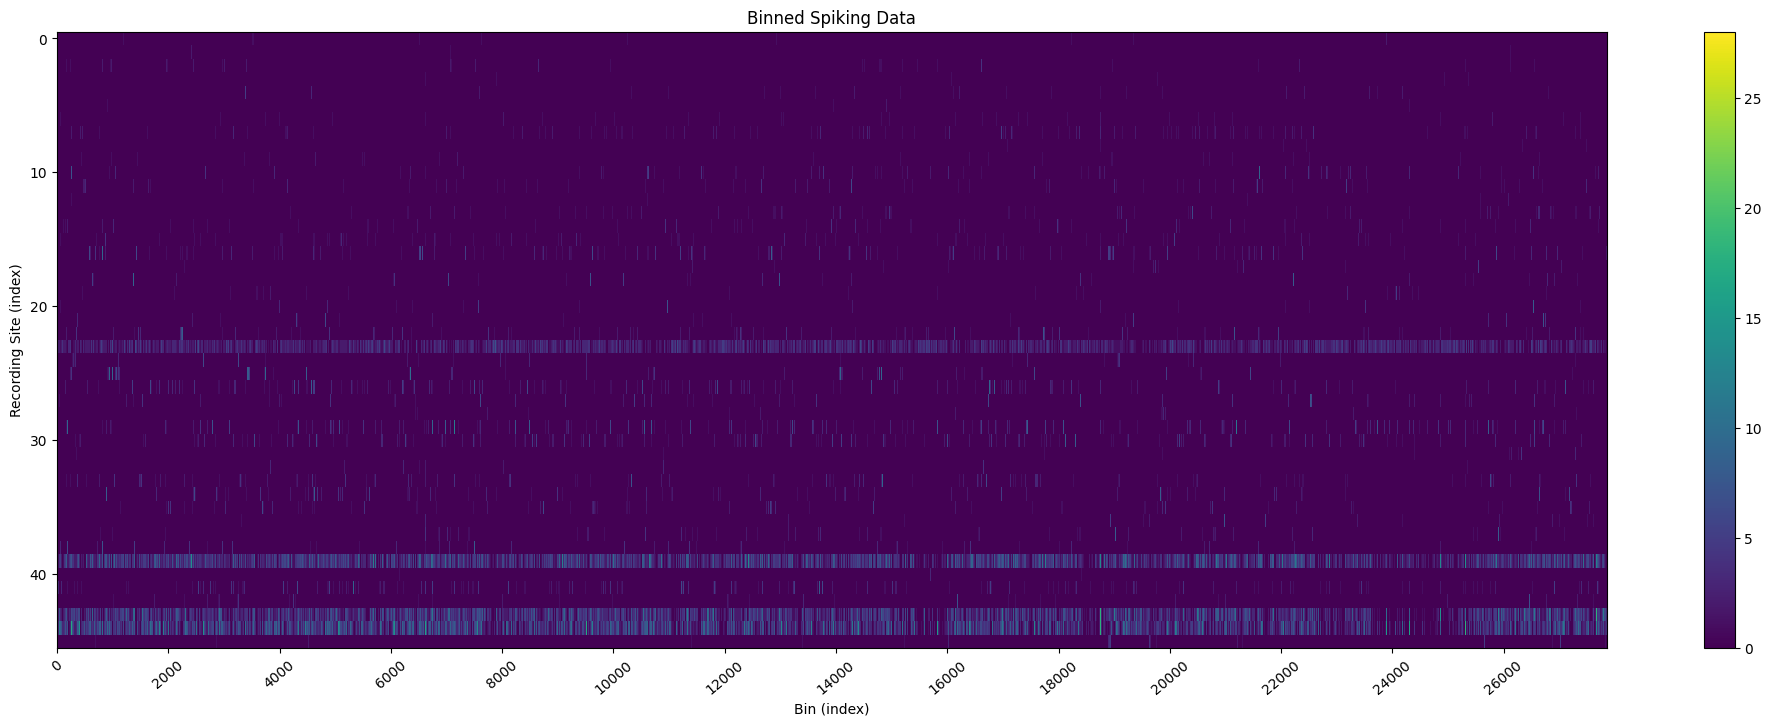

In [ ]:
#@title Visualize Binned Spike Train Data
print(f"Shape of the pruned and binned spike train data:\n\t{pruned_binned_cleaned_spike_data.shape}")
# matplotlib.pyplot.imshow
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Binned Spiking Data")
plt.imshow(pruned_binned_cleaned_spike_data, aspect='auto', interpolation='nearest')
plt.xlabel("Bin (index)")
# matplotlib.pyplot.xticks
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
plt.xticks(np.arange(0, len(pruned_binned_cleaned_spike_data[0]), step=2000), rotation=40)
plt.ylabel("Recording Site (index)")
# matplotlib.pyplot.colorbar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar
plt.colorbar()
plt.show()

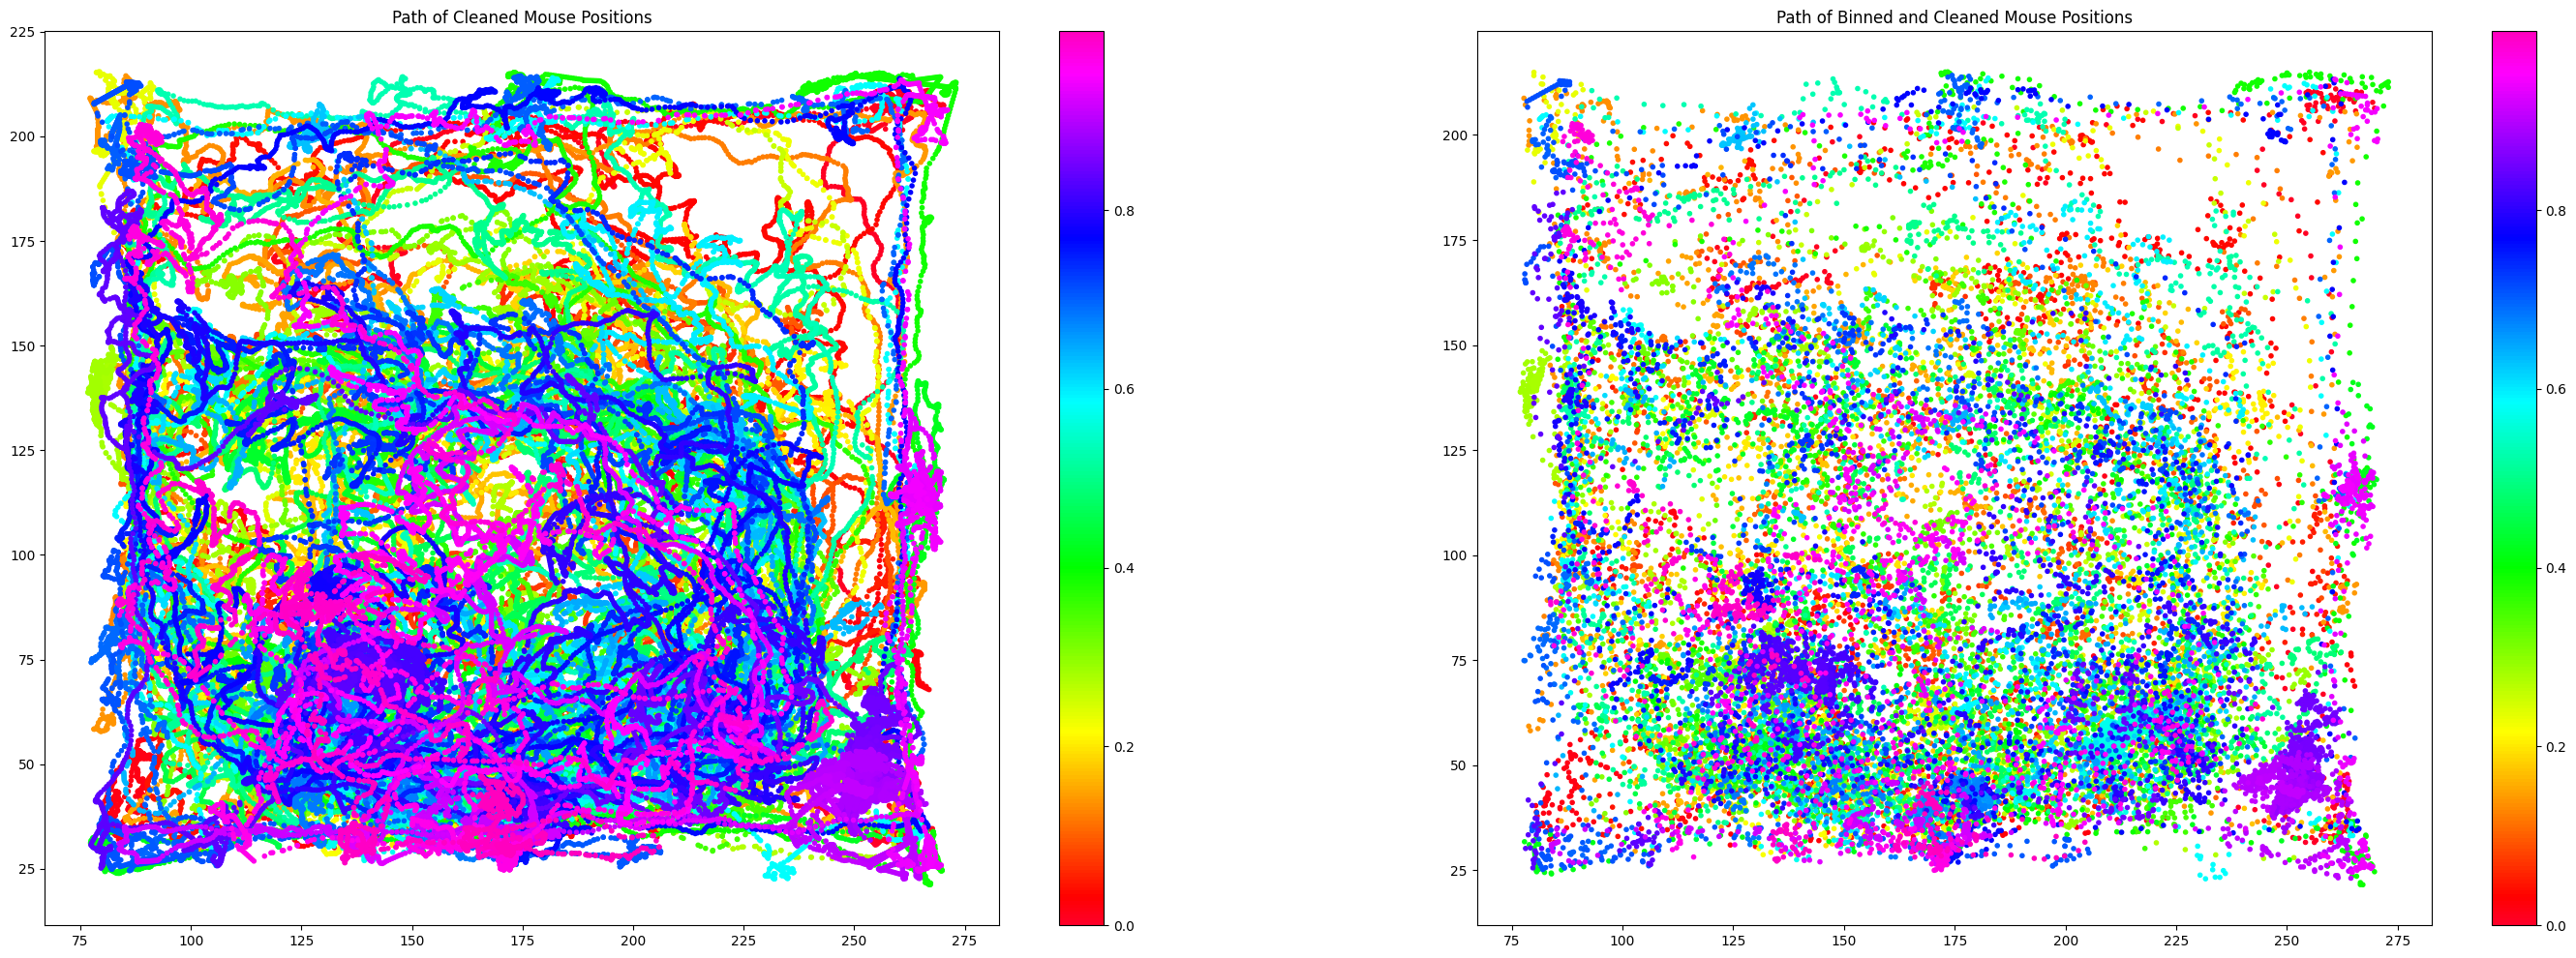

In [ ]:
#@title Plot the Mouse's Raw and Binned Positions
# x_pos = [p[0] for p in cleaned_pos_data]
x_pos = cleaned_pos_data[:, 0]
# y_pos = [p[1] for p in cleaned_pos_data]
y_pos = cleaned_pos_data[:, 1]
colors = np.arange(0, 1, step=1/len(cleaned_pos_data))
plt.rcParams["figure.figsize"] = (35,12)
plt.subplot(1, 2, 1)
# plt.rcParams["figure.figsize"] = (50,9)
plt.title("Path of Cleaned Mouse Positions")
# matplotlib.pyplot.scatter
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# colormaps
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.scatter(
    x_pos, 
    y_pos, 
    c=colors, 
    marker='.', 
    cmap='gist_rainbow'
)
plt.colorbar()

binned_cleaned_x_pos = [pos[0] for pos in binned_cleaned_pos_data]
binned_cleaned_y_pos = [pos[1] for pos in binned_cleaned_pos_data]
colors = np.arange(0, 1, step=1/len(binned_cleaned_pos_data))
plt.subplot(1, 2, 2)
# plt.rcParams["figure.figsize"] = (12,9)
plt.title("Path of Binned and Cleaned Mouse Positions")
# matplotlib.pyplot.scatter
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# colormaps
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.scatter(
    binned_cleaned_x_pos, 
    binned_cleaned_y_pos, 
    c=colors, 
    marker='.', 
    cmap='gist_rainbow'
)
plt.colorbar()
plt.show()

###Imbalaned Dataset

[TensorFlow Tutorial: Classification on Imbalanced Dataset](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

The output values of our dataset are not balanced unfortunately. 
Imbalanced classes may require stratified sampling to ensure that some classes 
are not overrepresented in different datasets.

Note: In the titles for the histograms that contain the word 'Binned', 
'Binned' in this sense means the average of position samples that fall within 
the same spike data bin.


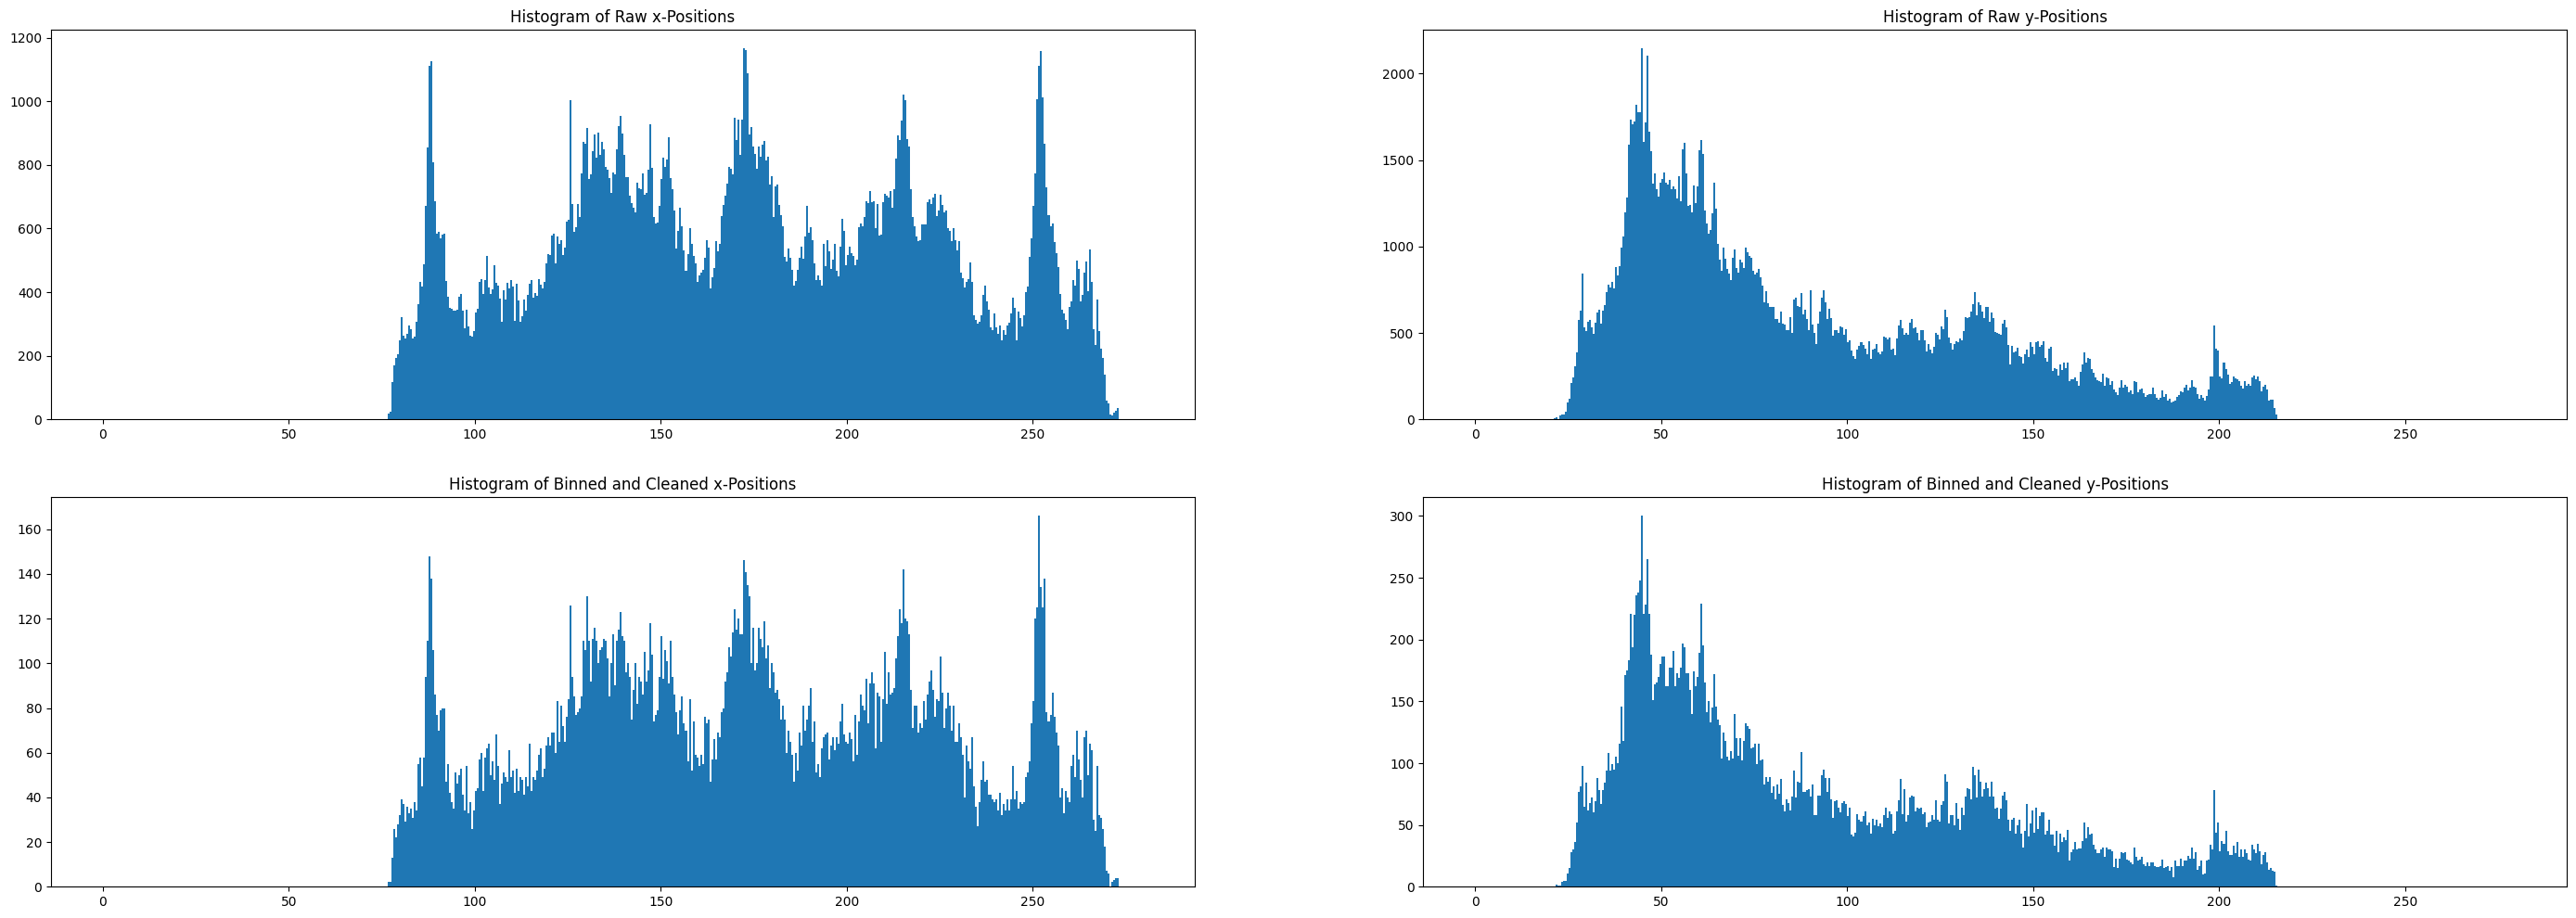

In [ ]:
print("""Note: In the titles for the histograms that contain the word 'Binned', 
'Binned' in this sense means the average of position samples that fall within 
the same spike data bin.""")
bins = np.arange(0, 280, 0.5)
# np.histogram
# the arguments of plt.hist() are passed into np.histogram()
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy.histogram
# matplotlib.pyplot.subplot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
plt.subplot(2, 2, 1)
plt.hist(x_pos, bins=bins)
plt.title("Histogram of Raw x-Positions")
plt.subplot(2, 2, 2)
plt.hist(y_pos, bins=bins)
plt.title("Histogram of Raw y-Positions")
# binned position data
plt.subplot(2, 2, 3)
plt.hist(binned_cleaned_x_pos, bins=bins)
plt.title("Histogram of Binned and Cleaned x-Positions")
plt.subplot(2, 2, 4)
plt.hist(binned_cleaned_y_pos, bins=bins)
plt.title("Histogram of Binned and Cleaned y-Positions")
plt.show()

###Train-Test Split, Stanardize, and Window Data

There are many ways to standrdize the data:
- Only standardize by the recording sites before widnowing.
- Standardize the example features after windowing.

Read [Machine Learning Mastery: When and How to Use StandardScaler and MinMaxScaler Transforms in Python](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/) to get a better idea of what to do about standardization and/or normalization.

In [ ]:
X = pruned_binned_cleaned_spike_data.transpose()
y = binned_cleaned_pos_data

# num_bins_per_recording_site: the number of time bins after binning the spike 
#   data of the entire hc2 dataset
# num_recording_sites: the number of neurons in the entire hc2 dataset
num_time_bins, num_recording_sites = X.shape

if randomly_sample_train_test_datasets:
    # note: by performing random sampling liek this, note that i am not 
    # guaranteed to have exactly 80% of my data become training data. i could
    # try to remedy this by moving some examples to achieve this exact split; 
    # however, for large datasets, this is likely negligible.
    # np.random.default_rng()
    # https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng
    # np.random.Generator.random()
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html#numpy.random.Generator.random
    train_idx = np.random.default_rng(seed=8177).random(num_time_bins) < precent_training_data
    test_idx = np.logical_not(train_idx)
else:
    train_test_split_idx_boundary = math.floor(num_time_bins * precent_training_data)

    train_idx = range(train_test_split_idx_boundary)
    test_idx = range(train_test_split_idx_boundary, num_time_bins)

X_train = X[train_idx, :]
y_train = y[train_idx, :]
X_test = X[test_idx, :]
y_test = y[test_idx, :]
assert X_train.shape[0] == y_train.shape[0], f"The number of examples in X_train ({X_train.shape[0]}) and y_train ({y_train.shape[0]}) do not match."
assert X_test.shape[0] == y_test.shape[0], f"The number of examples in X_test ({X_test.shape[0]}) and y_test ({y_test.shape[0]}) do not match."

if hyperparameters["max_abs_scaling"]:
    # sklearn.preprocessing.MaxAbsScaler
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler
    # as you will later, find out this dataset is very sparse. 
    # preprocessing.MaxAbsScaler was specifically designed for scaling sparse 
    # data and is teh recommended way to go about this.
    # https://scikit-learn.org/stable/modules/preprocessing.html#scaling-sparse-data
    scaler = preprocessing.MaxAbsScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    print(f"Shape of X_train:\n\t{X_train.shape}")
    print("Number of values in X_train greater than 0:", np.sum(X_train > 0))
    print("Number of values in X_train less than 0:", np.sum(X_train < 0))
    print("Number of values in X_train_matrix equal to 0:", np.sum(X_train == 0))
    assert np.sum(np.isnan(X_train)) == 0, f"Expected 0 nan values in X_train_matrix, but there were {np.sum(np.isnan(X_train))}"

    X_test = scaler.transform(X_test)
    print("Number of values in X_test greater than 0:", np.sum(X_test > 0))
    print("Number of values in X_test less than 0:", np.sum(X_test < 0))
    print("Number of values in X_test equal to 0:", np.sum(X_test == 0))
    assert np.sum(np.isnan(X_test)) == 0, f"Expected 0 nan values in X_test, but there were {np.sum(np.isnan(X_test))}"
elif hyperparameters["sklearn_standardization"]:
    # sklearn.preprocessing.StandardScaler
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    # estimate parameters for standardization (0 mean, unit standard deviation) 
    # based on the training dataset performing the train-test split to avoid data
    # leakage.
    # TODO: test to see if StandardScaler works with tensors with rank greater 
    #   than 2.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_matrix_mean = scaler.mean_
    X_train_matrix_std = scaler.scale_
    print(f"Feature vector mean:\n\t{X_train_matrix_mean}\n")
    print(f"Feature vector standard deviation:\n\t{X_train_matrix_std}\n")
    print(f"Feature vector variance:\n\t{scaler.var_}\n")
    X_train_matrix = scaler.transform(X_train)
elif hyperparameters["np_standardization"]: 
    X_train_matrix_mean = np.mean(X_train, axis=0)
    assert X_train_matrix_mean.size == X_train.shape[1]
    X_train_matrix_std = np.std(X_train, axis=0)
    assert X_train_matrix_std.size == X_train.shape[1]
    assert np.count_nonzero(X_train_matrix_std) == X_train_matrix_std.size, "Some of the standard deviations of the dataset were zero. Therefore, the data cannot be standardized de to divide by zero errors."
    print(f"Feature vector mean:\n\t{X_train_matrix_mean}\n")
    print(f"Feature vector standard deviation:\n\t{X_train_matrix_std}\n")
    # i believe that broadcasting will make this work out *crossing fingers*
    X_train_matrix = (X_train - X_train_matrix_mean) / X_train_matrix_std

# standardize the test covariate samples
if sklearn_standardization or np_standardization:
    X_test = (X_test - X_train_matrix_mean) / X_train_matrix_std

def window(X, y):
    """
    window the input X and y data
    """
    num_X_examples = X.shape[0] - pre_bins - post_bins

    X_windowed = np.zeros((
        num_X_examples, 
        num_bins_per_recording_site_per_example * num_recording_sites
    ))
    print(f"\tShape of the windowed input matrix:\n\t\t{X_windowed.shape}")

    # window the data
    present_bin_idx = pre_bins
    for i in range(num_X_examples):
        start_idx: int = present_bin_idx - pre_bins
        end_idx: int = present_bin_idx + post_bins + 1
        # i used .flatten() instead of .ravel() because i will be standardizing the
        # dataset and i would like to keep the unstandardized data just in case.
        X_windowed[i, :] = X[start_idx:end_idx, :].flatten()
        present_bin_idx += 1

    y_windowed = y[pre_bins:-post_bins, :]
    print(f"\tShape of y_train:\n\t\t{y_windowed.shape}")
    assert y_windowed.shape[0] == num_X_examples, f"The number of dataset example labels was expected to be {num_X_examples}, but was actually {y_windowed.shape[0]}."

    return X_windowed, y_windowed

print("\nWindowing training data...")
X_train_matrix, y_train = window(X_train, y_train)
# the order of the axes of the tensor represent (example, binned spike for a bin, recording site)
X_train_tensor = np.reshape(
    X_train_matrix, 
    (X_train_matrix.shape[0], num_bins_per_recording_site_per_example, num_recording_sites)
)
print(f"Shape of X_train_tensor:\n\t{X_train_tensor.shape}")

print("\nWindowing testing data...")
X_test_matrix, y_test = window(X_test, y_test)
# the order of the axes of the tensor represent (example, binned spike for a bin, recording site)
X_test_tensor = np.reshape(
    X_test_matrix,
    (X_test_matrix.shape[0], num_bins_per_recording_site_per_example, num_recording_sites)
)
print(f"Shape of X_test_tensor:\n\t{X_test_tensor.shape}")

num_train_examples, _, _ = X_train_tensor.shape
num_test_examples, _, _ = X_test_tensor.shape
# num_examples: the number of complete data examples given the number of 
#   pre_bins and post_bins the model will use for inference.
num_examples = num_train_examples + num_test_examples

Shape of X_train:
	(22284, 46)
Number of values in X_train greater than 0: 108884
Number of values in X_train less than 0: 0
Number of values in X_train_matrix equal to 0: 916180
Number of values in X_test greater than 0: 23743
Number of values in X_test less than 0: 0
Number of values in X_test equal to 0: 232523

Windowing training data...
	Shape of the windowed input matrix:
		(22276, 414)
	Shape of y_train:
		(22276, 2)
Shape of X_train_tensor:
	(22276, 9, 46)

Windowing testing data...
	Shape of the windowed input matrix:
		(5563, 414)
	Shape of y_train:
		(5563, 2)
Shape of X_test_tensor:
	(5563, 9, 46)


In [ ]:
#TODO: test out zero-centering labels. kording lab did this without an 
# explanation and as far as i know this is not a necessary step for ml since
# feature scaling is supposed to make it such that all features are on a similar
# scale for the learning algorithm. on top of that, we usually create a model
# per dependent variable, so the concern of processing values of vastly 
# different scales through one model should not apply here.
# https://github.com/KordingLab/Neural_Decoding/blob/71a3c9ba2161cb1d8642bcefb96e8f29ccab7366/Examples_hippocampus/Examples_decoders_hc.ipynb
# the tf time series example does not help me make a decision on this since
# the are doing classical time series analysis and draw their labels from 

# here is a post discussing normalizing out put labels. i think that this could
# be helpful. especially for the neural network because the training and 
# validation losses are quite large. i think that this may be because the scale
# of the labels is quite large, so if the intialization scheme is set to be in
# between 0 and 1 for weights, when the labels are on the 100s scale, then the
# intial weights will be nowhere near the scale of the data labels.
# https://datascience.stackexchange.com/questions/24214/why-should-i-normalize-also-the-output-data
# https://datascience.stackexchange.com/questions/22776/is-it-valuable-to-normalize-rescale-labels-in-neural-network-regression

In [ ]:
def test_matrix_windowing(X: np.ndarray):
    assert len(X.shape) == 2
    n, m = X.shape
    for i in range(1, n):
        prev_idx = np.arange(num_recording_sites, m)
        curr_idx = np.arange(0, m - num_recording_sites)
        # before i did construct the error message before the assertion and put
        # it into a variable for readability, but cnstructing a string with a 
        # large matrix was dominating the runtime of this test. therefore, i 
        # just put it as a literal inside of the assertion statement so that the
        # string is only constructed when the assertion fails.
        assert np.asarray(X[i - 1, prev_idx] == X[i, curr_idx]).all(), f"""The overlapping regions of the consecutive data examples
located at indices {i - 1} and {i} are not equivalent. The vector at {i - 1} was:\n
{X[i - 1, prev_idx]}\n
The vector at {i} was:\n
{X[i, curr_idx]}"""
    print("The input matrix passed test_matrix_windowing!")

# becausse i perform standaridzation after the data has been,
# windowed overlapping data do not match exactly.
# TODO: figure out how to untangle the standaridzation, train-test
#   split, and the widnowing code so that you can do standardization
#   before you do windowing to avoid this strange behavior where
#   some the same data appears as a different value across examples.
if not hyperparameters["np_standardization"]:
    test_matrix_windowing(X_train_matrix)

def test_tensor_windowing(X: np.ndarray):
    assert len(X.shape) == 3
    n = X.shape[0]
    for i in range(1, n):
        assert np.asarray(X[i - 1, 1:, :] == X[i, :-1, :]).all(), f"""The overlapping regions of the consecutive data examples
located at indices {i - 1} and {i} are not equivalent. The matrix at {i - 1} was:\n
{X[i - 1, 1:, :]}\n
The matrix at {i} was:\n
{X[i, :-1, :]}"""
    print("The input tensor passed test_tensor_windowing!")

# becausse i perform standaridzation after the data has been,
# windowed overlapping data do not match exactly.
# TODO: figure out how to untangle the standaridzation, train-test
#   split, and the widnowing code so that you can do standardization
#   before you do windowing to avoid this strange behavior where
#   some the same data appears as a different value across examples.
if not hyperparameters["np_standardization"]:
    test_tensor_windowing(X_train_tensor)

The input matrix passed test_matrix_windowing!
The input tensor passed test_tensor_windowing!


###Data Serialization

In [ ]:
with open(data_fn, "wb") as f:
    # np.savez
    # https://numpy.org/doc/stable/reference/generated/numpy.savez.html
    np.savez_compressed(
        f, 
        X_train_matrix=X_train_matrix, 
        X_train_tensor=X_train_tensor, 
        y_train=y_train, 
        X_test_matrix=X_test_matrix, 
        X_test_tensor=X_test_tensor, 
        y_test=y_test
    )

###Exploratory Data Analysis

Practice some basic statsitical analysis with exploratory data analysis. This would be a good opportunity to apply some unsupervised learning algorithm such as dimensionality reduction (PCA) and clustering. I could also try out some descriptive statistics approaches to attempt to summarize and make sense of this large dataset.

In [ ]:
# compute the sparsity score of the whole dataset
spike_data_sparsity_score = (pruned_binned_cleaned_spike_data.size - np.count_nonzero(pruned_binned_cleaned_spike_data)) / pruned_binned_cleaned_spike_data.size
print(f"Sparsity score (0-1) of the entire binned spike data:\n{spike_data_sparsity_score}\n")
# compute the sparsity score of the data per recording site
spike_sparsity_per_recording_site = (num_time_bins - np.count_nonzero(pruned_binned_cleaned_spike_data, axis=1)) / num_time_bins
print(f"Sparsity score (0-1) of binned spike counts per recording site:\n{spike_sparsity_per_recording_site}\n")
# compute the mean of the data per recording site
spike_mean_per_recording_site = np.mean(pruned_binned_cleaned_spike_data, axis=1)
print(f"Mean of binned spike counts per recording site:\n{spike_mean_per_recording_site}\n")
# compute the standard deviation of the data per recording site
spike_std_per_recording_site = np.std(pruned_binned_cleaned_spike_data, axis=1)
print(f"Standard deviation of binned spike counts per recording site:\n{spike_std_per_recording_site}")

Sparsity score (0-1) of the entire binned spike data:
0.8964927067968439

Sparsity score (0-1) of binned spike counts per recording site:
[0.99630228 0.99558428 0.98542452 0.99572788 0.98779393 0.99648178
 0.97806498 0.94083647 0.99658948 0.9813319  0.96528451 0.96697182
 0.99813319 0.96255609 0.9634895  0.95853527 0.91057261 0.99073775
 0.98560402 0.98994794 0.98700413 0.98678873 0.93570275 0.14413929
 0.97996769 0.97224915 0.90296177 0.98452701 0.99393287 0.91193682
 0.90619278 0.99569198 0.99134805 0.93728236 0.95824807 0.9642075
 0.98538862 0.97267995 0.96926943 0.09258661 0.99594328 0.89782804
 0.97831628 0.13430264 0.1264764  0.98772213]

Mean of binned spike counts per recording site:
[3.84132113e-03 5.63633100e-03 1.82732005e-02 4.52342488e-03
 1.78782983e-02 3.76952073e-03 2.40890325e-02 8.82426853e-02
 5.49273021e-03 1.99246096e-02 7.19439957e-02 5.61479088e-02
 3.62591994e-03 6.26817447e-02 5.69377132e-02 6.03841321e-02
 1.86393825e-01 1.75551966e-02 4.04954227e-02 1.3677975

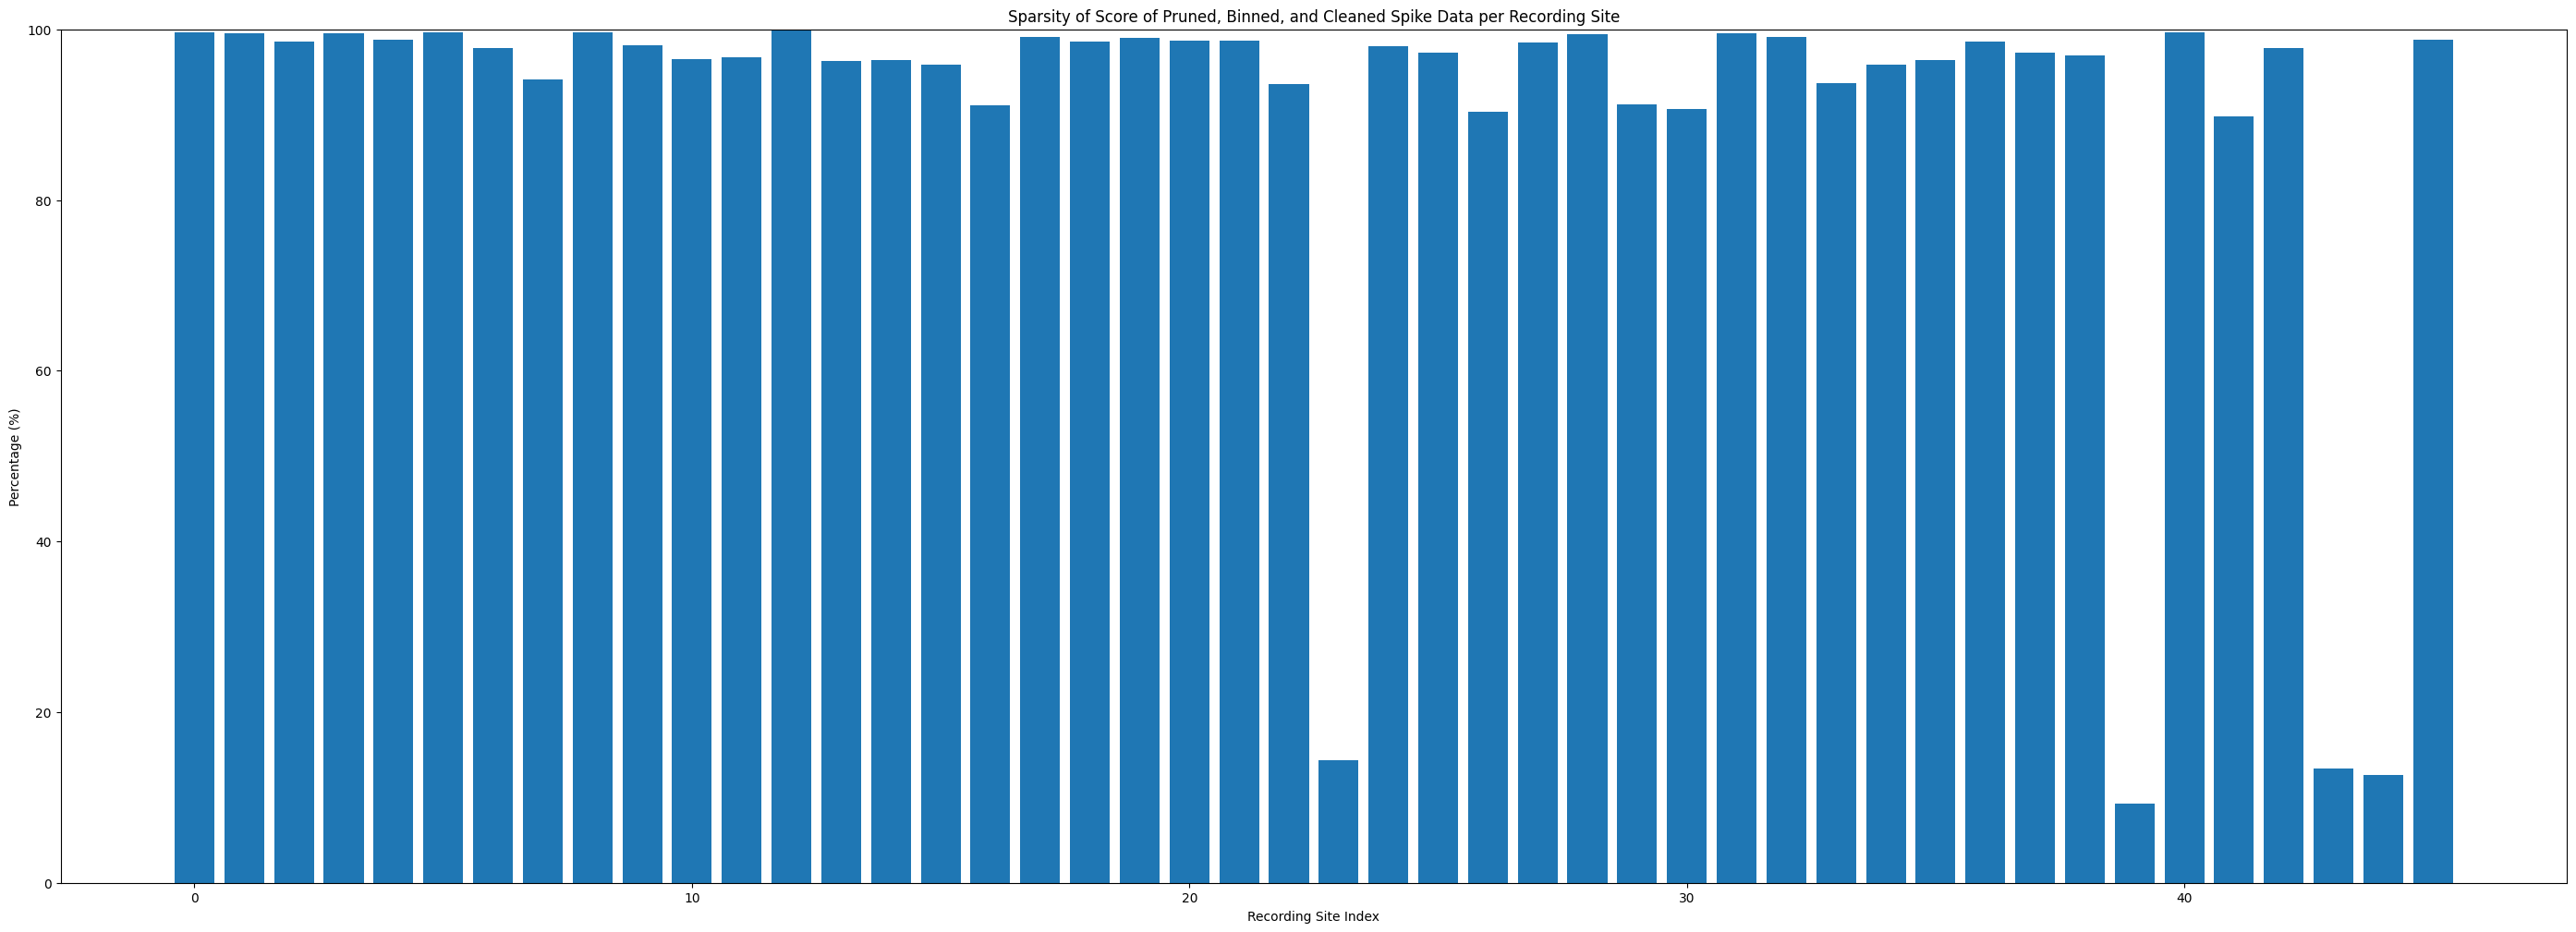

As you can see, most recording sites have a very high sparsity score
meaning that most of our data is 0.

More specifically, 41 out of 46 
recording sites have a sparsity score greater than or equal to 90%.

42 out of 46 recording sites have a 
sparsity score greater than or equal to 80%.

Only 4 out of 46 recording sites have a 
sparsity score less than or equal to 20%.

Clearly, this neural data is quite sparse. The sparsity of the data has posed a 
problem with standardization in that it makes it challenging to divide by the
standrd deviation since it is essentially zero.



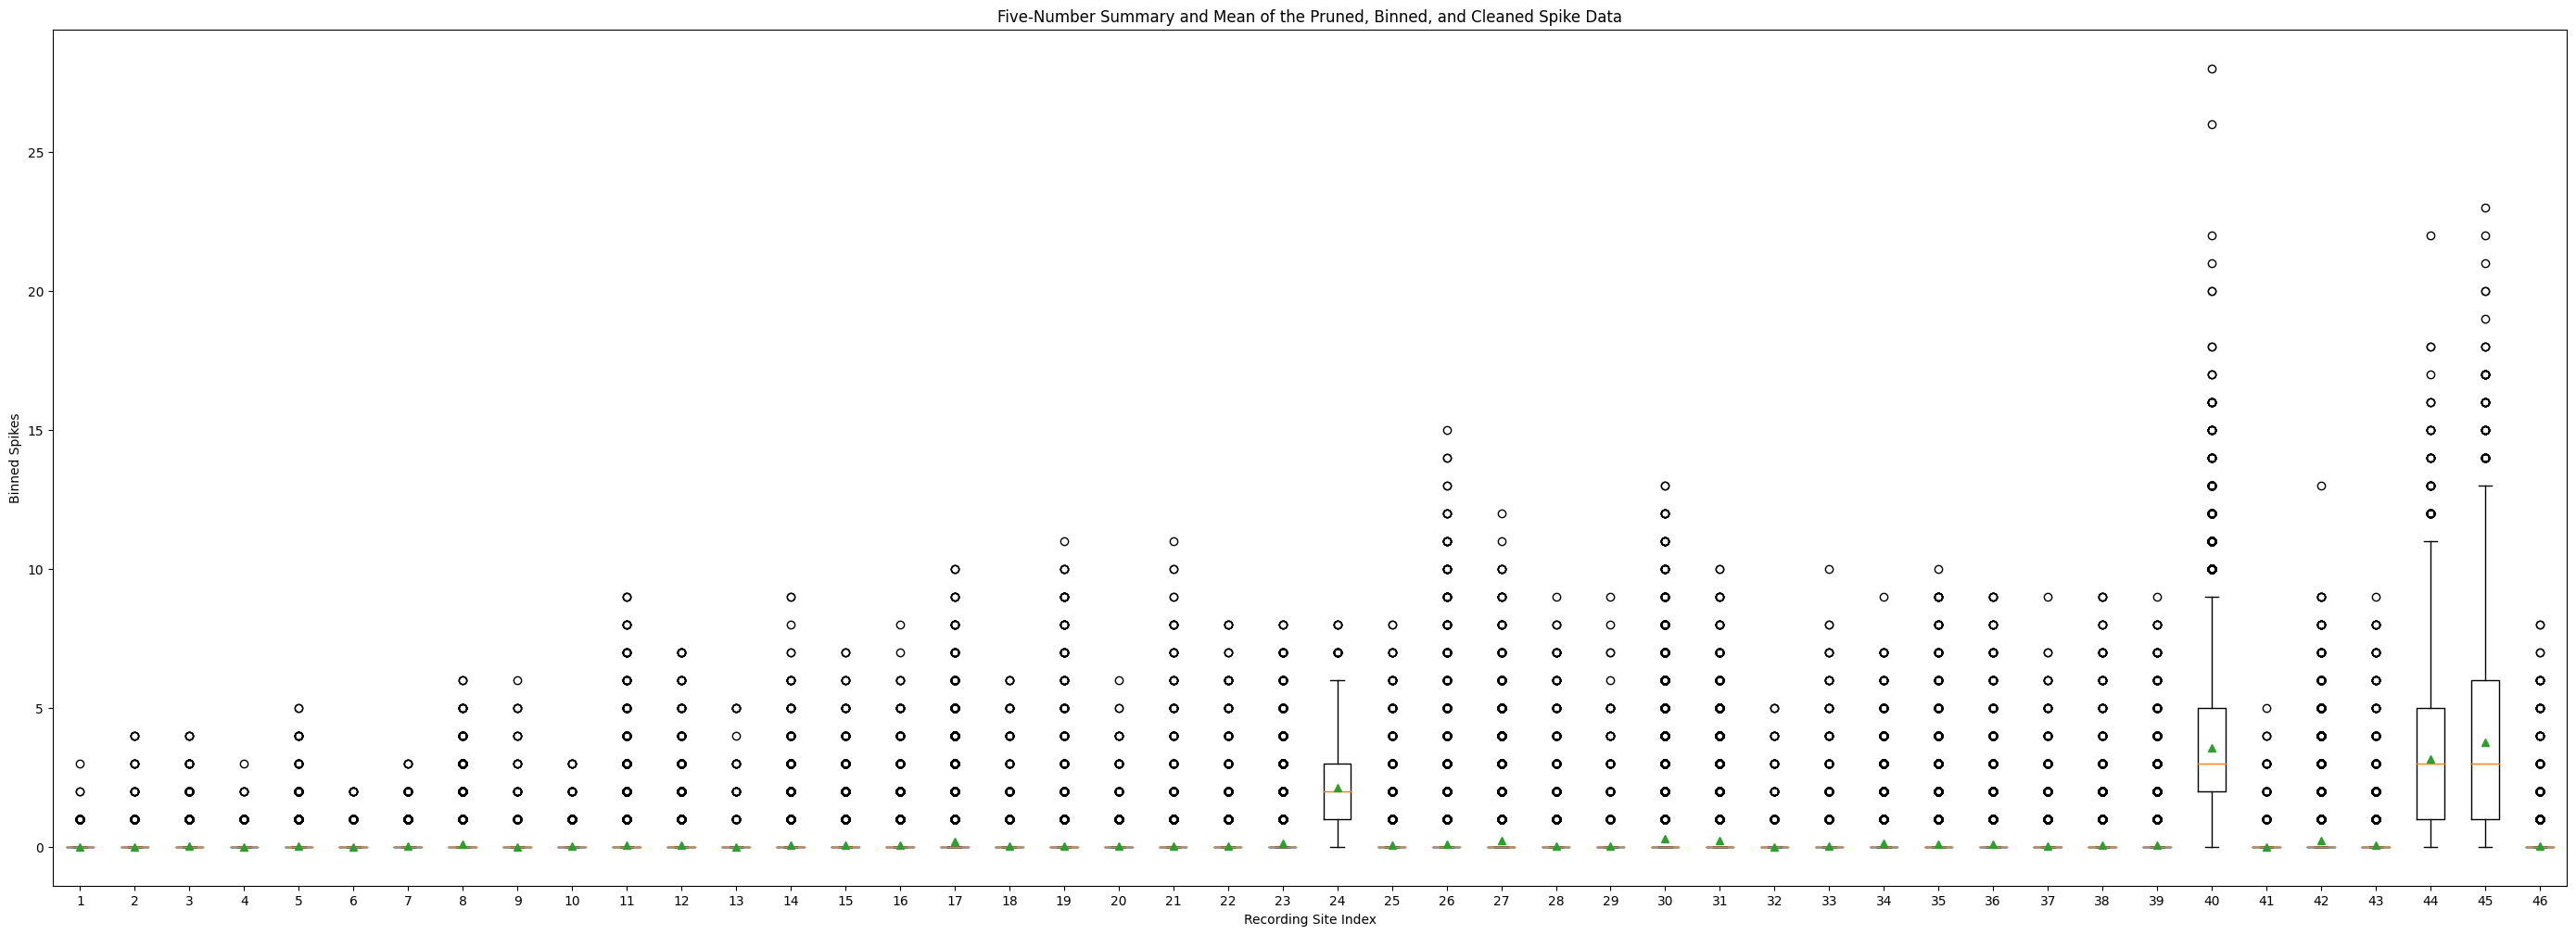

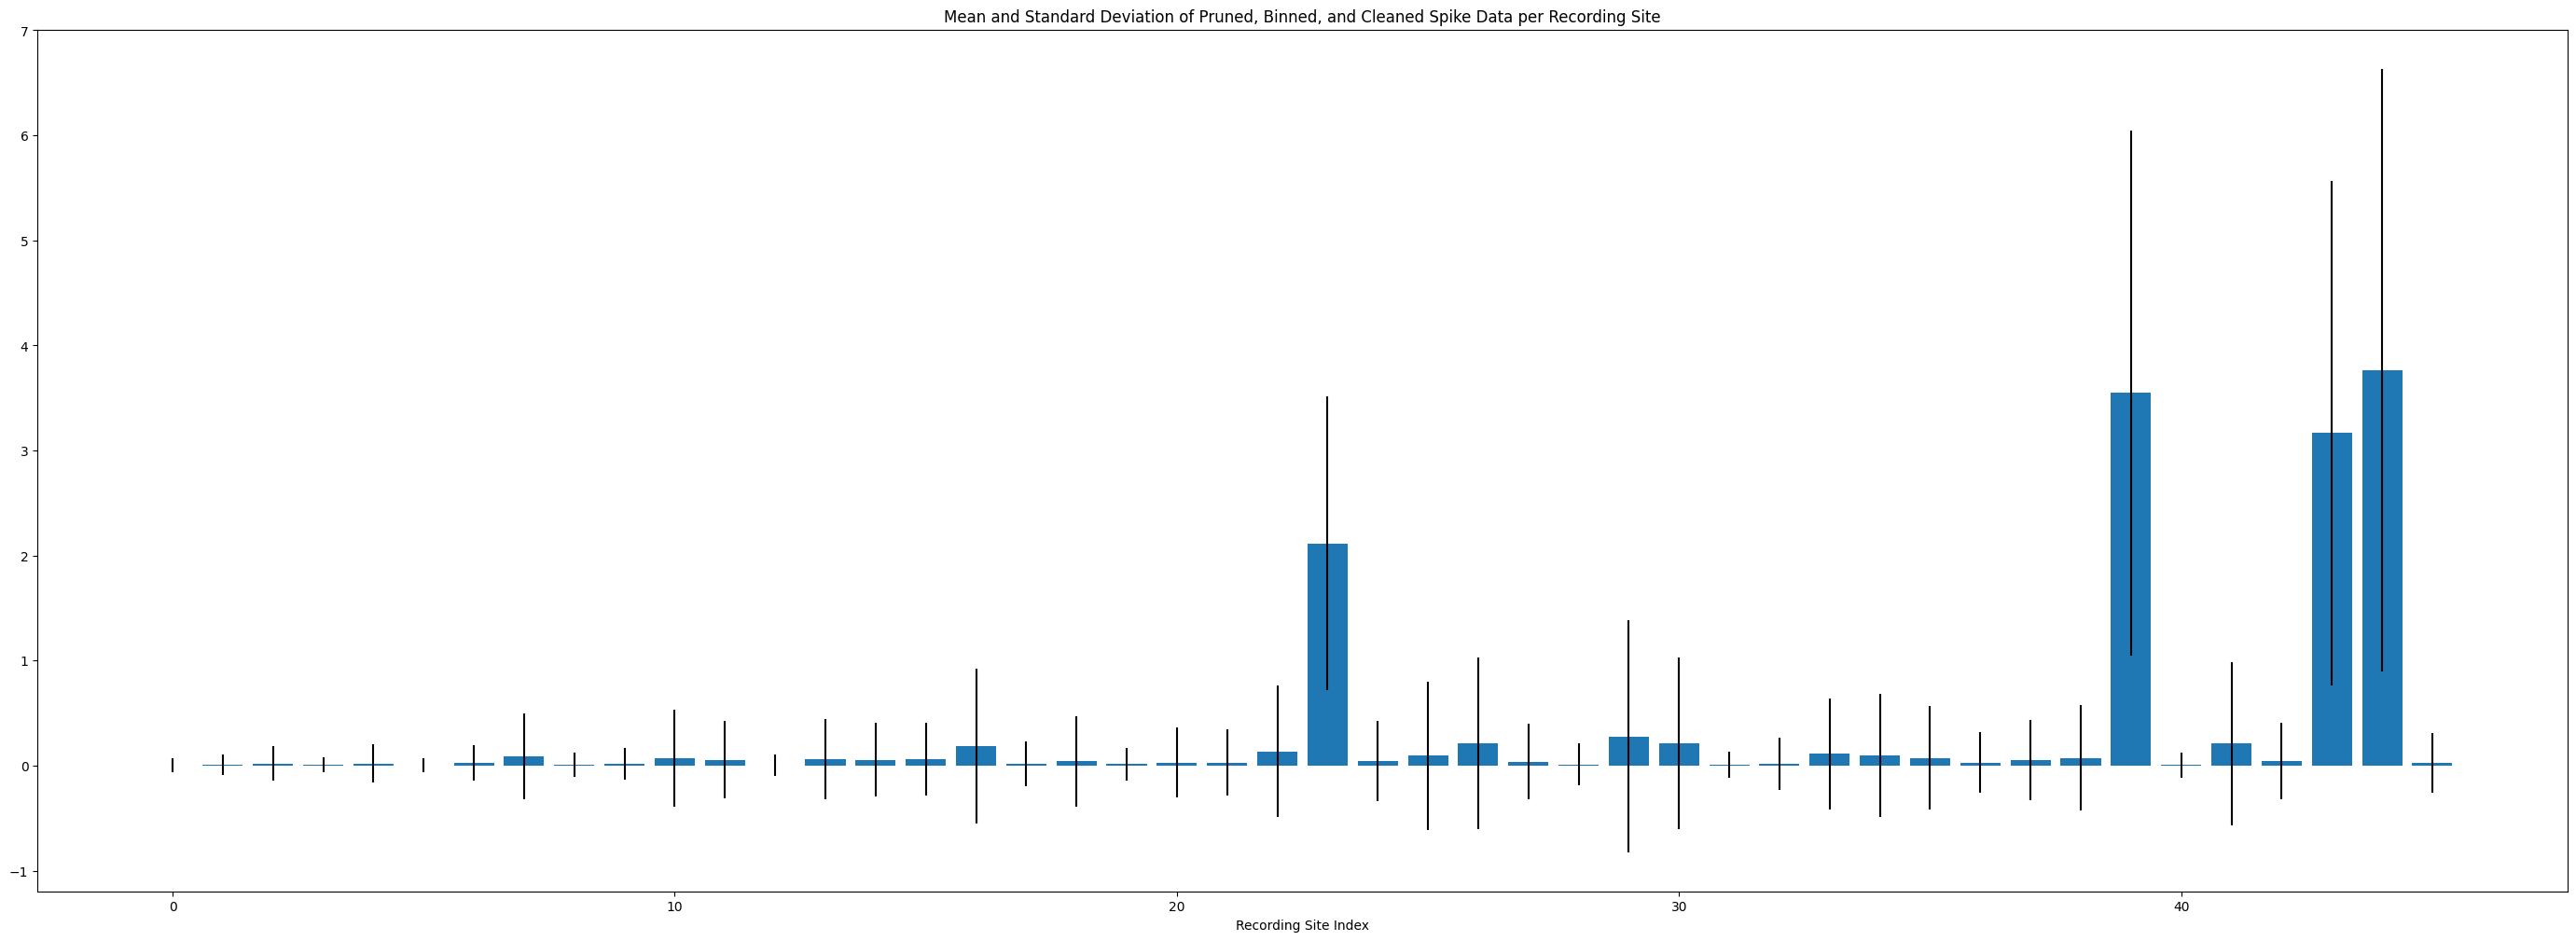

In [ ]:
# matplotlib.pyplot.bar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
# full bar chart example
# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
# i could also represent the sparsity scores as multiple pie charts. but also 
# don't feel like figuring out how to do that.
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pie.html#matplotlib.axes.Axes.pie
plt.bar(range(num_recording_sites), spike_sparsity_per_recording_site * 100)
plt.title("Sparsity of Score of Pruned, Binned, and Cleaned Spike Data per Recording Site")
plt.ylim(top=100)
plt.xlabel("Recording Site Index")
plt.ylabel("Percentage (%)")
plt.show()
print(f"""As you can see, most recording sites have a very high sparsity score
meaning that most of our data is 0.

More specifically, {np.sum(spike_sparsity_per_recording_site >= 0.9)} out of {num_recording_sites} 
recording sites have a sparsity score greater than or equal to 90%.

{np.sum(spike_sparsity_per_recording_site >= 0.8)} out of {num_recording_sites} recording sites have a 
sparsity score greater than or equal to 80%.

Only {np.sum(spike_sparsity_per_recording_site <= 0.2)} out of {num_recording_sites} recording sites have a 
sparsity score less than or equal to 20%.

Clearly, this neural data is quite sparse. The sparsity of the data has posed a 
problem with standardization in that it makes it challenging to divide by the
standrd deviation since it is essentially zero.
""")

# boxplot demo
# https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html#boxplots
plt.boxplot(pruned_binned_cleaned_spike_data.transpose(), showmeans=True)
# the five-number summary consists of the 0th, 1st, 2nd, 3rd, and 4th quartiles 
# of the data
# https://en.wikipedia.org/wiki/Five-number_summary
plt.title("Five-Number Summary and Mean of the Pruned, Binned, and Cleaned Spike Data")
plt.xlabel("Recording Site Index")
plt.ylabel("Binned Spikes")
plt.show()

# matplotlib.pyplot.bar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
# full bar chart example
# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
plt.bar(range(num_recording_sites), spike_mean_per_recording_site, yerr=spike_std_per_recording_site)
plt.title("Mean and Standard Deviation of Pruned, Binned, and Cleaned Spike Data per Recording Site")
plt.xlabel("Recording Site Index")
plt.show("Binned Spikes")

# TODO: compute the range of the data
# TODO: do anomaly or outlier detection

In [ ]:
# compute the sparsity score of the whole dataset
spike_data_sparsity_score = (X_train_matrix.size - np.count_nonzero(X_train_matrix)) / X_train_matrix.size
print(f"Sparsity score (0-1) of the entire training dataset:\n{spike_data_sparsity_score}\n")
# compute the sparsity score of the data per recording site
spike_sparsity_per_feature = (num_time_bins - np.count_nonzero(X_train_matrix, axis=0)) / num_time_bins
print(f"Sparsity score (0-1) of binned spike counts per feature in the training dataset:\n{spike_sparsity_per_feature}\n")
# compute the mean of the data per feature
spike_mean_per_feature = np.mean(X_train_matrix, axis=0)
print(f"Mean of binned spike counts per feature in the training dataset:\n{spike_mean_per_feature}\n")
# compute the standard deviation of the data per feature
spike_std_per_feature = np.std(X_train_matrix, axis=0)
print(f"Standard deviation of binned spike counts per feature in the training dataset:\n{spike_std_per_feature}")

Sparsity score (0-1) of the entire training dataset:
0.8937781438484086

Sparsity score (0-1) of binned spike counts per feature in the training dataset:
[0.99655358 0.99705618 0.98689643 0.99806139 0.98973254 0.99694848
 0.9821935  0.95239634 0.99899479 0.98373721 0.97555197 0.97443906
 0.99892299 0.97325435 0.96919763 0.9635972  0.92155807 0.99343026
 0.98768623 0.99429187 0.98991204 0.98958894 0.94360079 0.31983486
 0.9815114  0.97422366 0.91387543 0.98739903 0.99533297 0.93380004
 0.92008616 0.99734339 0.99188656 0.94765751 0.9630228  0.97131574
 0.99264046 0.97652127 0.97149524 0.26016873 0.99698438 0.9096751
 0.9822653  0.28127805 0.27442111 0.99195836 0.99655358 0.99705618
 0.98689643 0.99806139 0.98973254 0.99694848 0.9821935  0.95239634
 0.99899479 0.98373721 0.97555197 0.97443906 0.99892299 0.97325435
 0.96919763 0.9635972  0.92155807 0.99343026 0.98768623 0.99429187
 0.98991204 0.98958894 0.94360079 0.31979896 0.9815114  0.97422366
 0.91387543 0.98739903 0.99533297 0.9338000

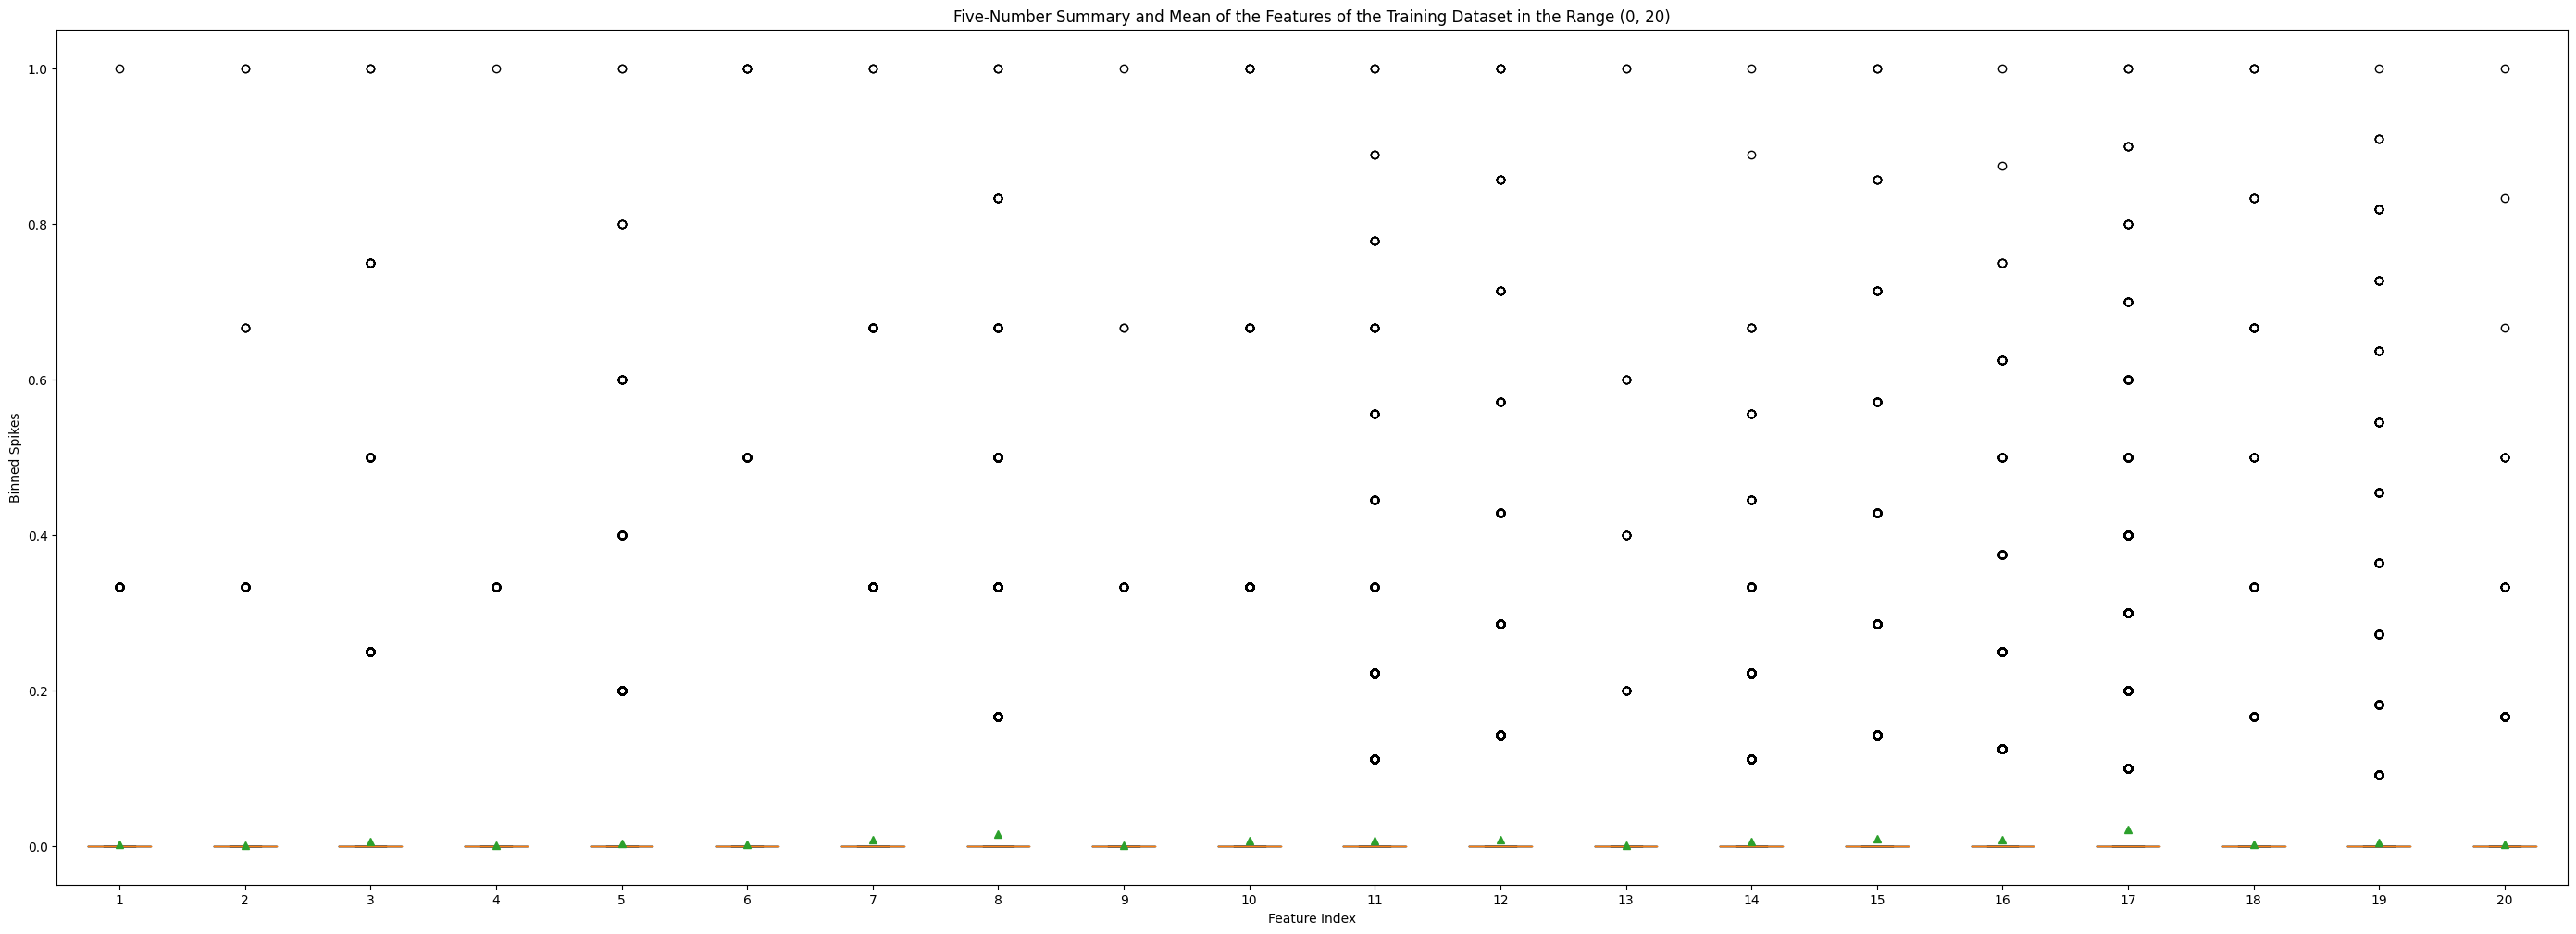

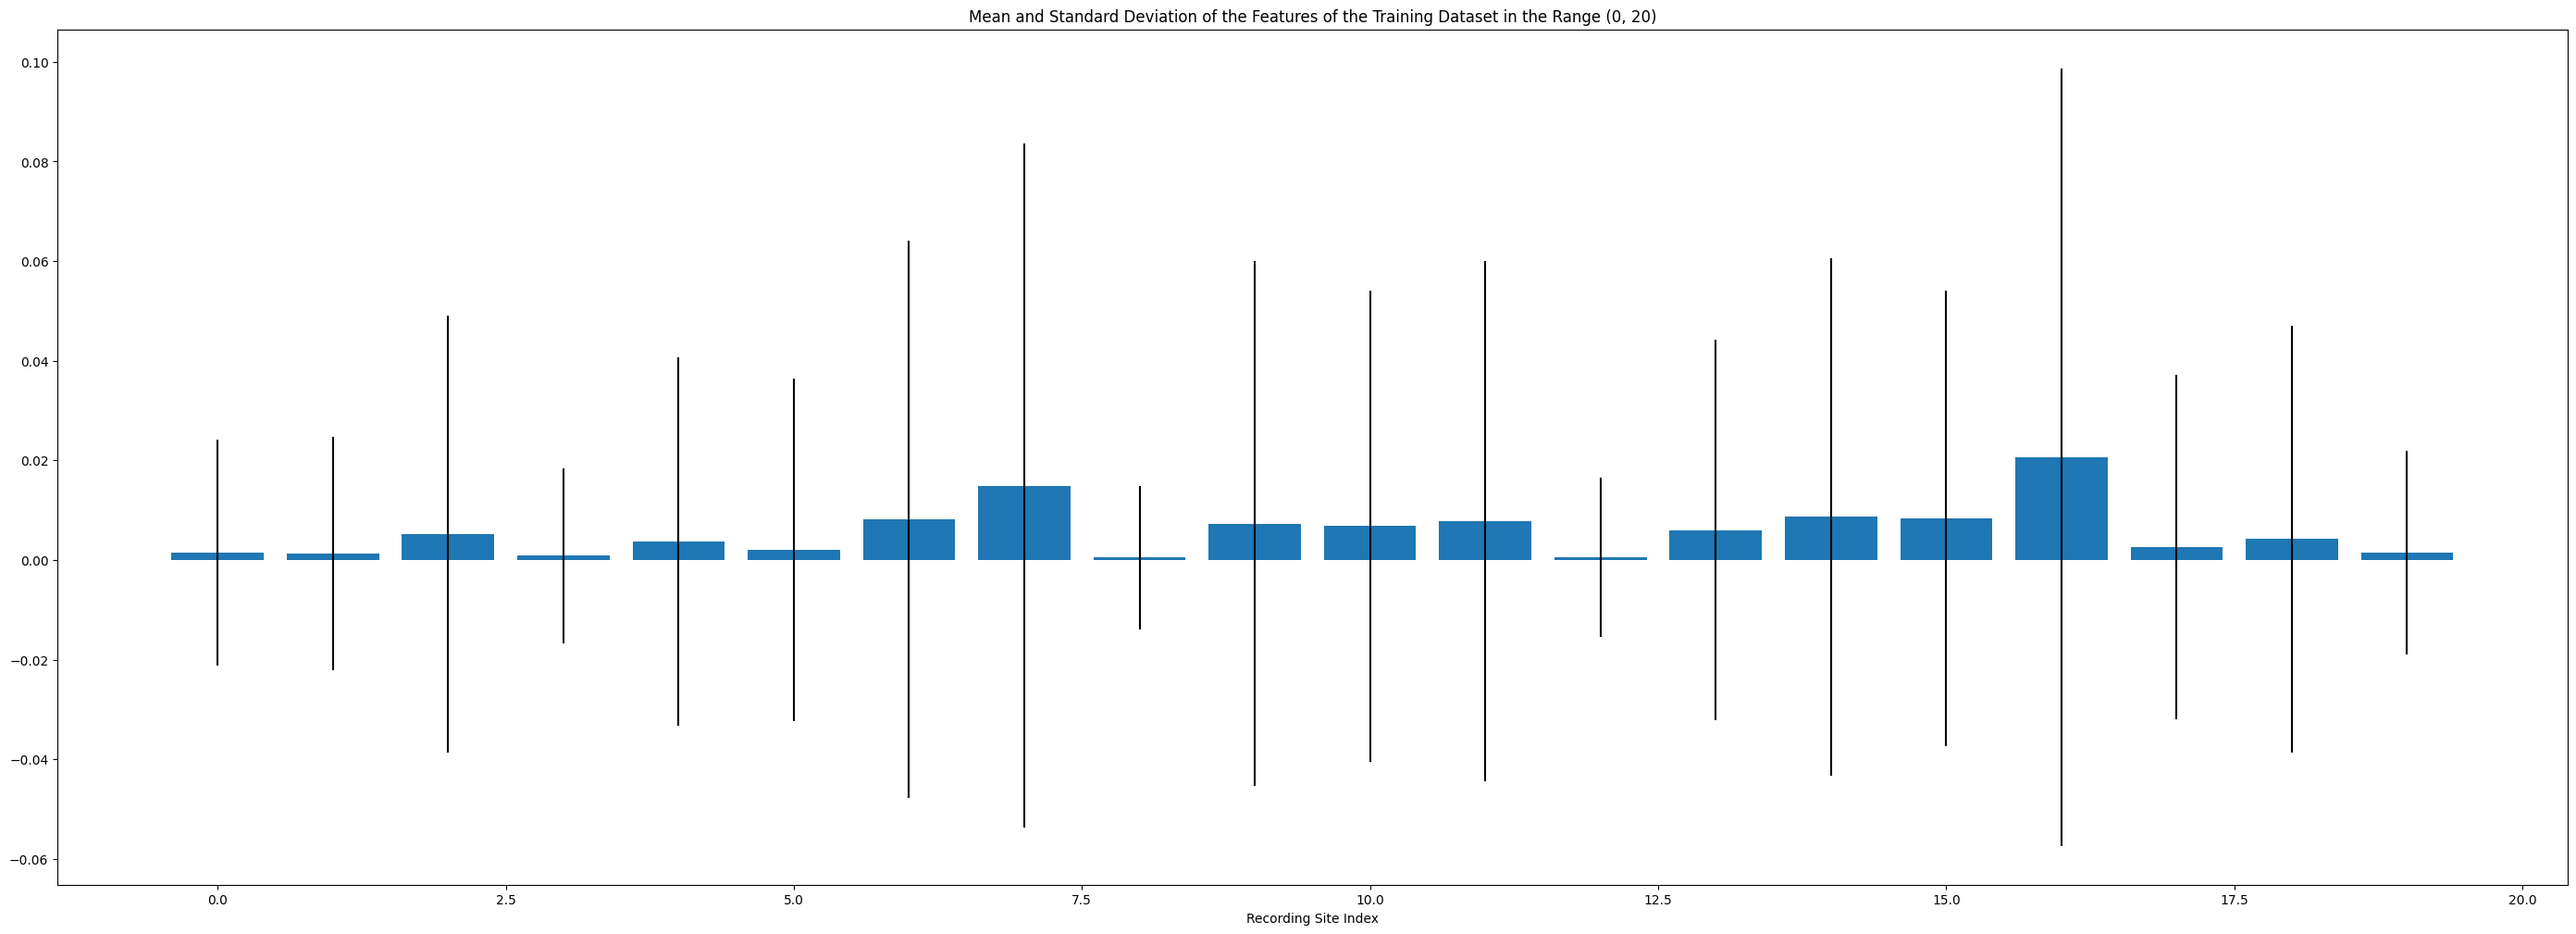

In [ ]:
feature_viz_range = (0, 20)  # (inclusive, exclusive)

# boxplot demo
# https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html#boxplots
# a boxplot is drawn for each column of the input matrix
plt.boxplot(
    X_train_matrix[:, feature_viz_range[0]:feature_viz_range[1]],
    showmeans=True
)
# the five-number summary consists of the 0th, 1st, 2nd, 3rd, and 4th quartiles 
# of the data
# https://en.wikipedia.org/wiki/Five-number_summary
plt.title(f"Five-Number Summary and Mean of the Features of the Training Dataset in the Range {feature_viz_range}")
plt.xlabel("Feature Index")
plt.ylabel("Binned Spikes")
plt.show()

# matplotlib.pyplot.bar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar
# full bar chart example
# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
plt.bar(
    range(*feature_viz_range),
    spike_mean_per_feature[feature_viz_range[0]:feature_viz_range[1]], 
    yerr=spike_std_per_feature[feature_viz_range[0]:feature_viz_range[1]]
)
plt.title(f"Mean and Standard Deviation of the Features of the Training Dataset in the Range {feature_viz_range}")
plt.xlabel("Recording Site Index")
plt.show("Binned Spikes")

# TODO: compute the range of the data
# TODO: do anomaly or outlier detection

##Machine Learning for Neural Decoding

I can also do random sampling now on the data examples by created a random vector and associating the index in the random vector with an index in X_tensor/_matrix and move the example into train or test based on if the random numebr is less than the percent_training_data. However, one problem with this is that I cannot apply the fix that I previously did

In [ ]:
def plot_preds_vs_truth(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    """
    plots the predicted value of the dependent variable vs the ground truth 
    value of the dependent variable.
    """
    assert y_true.shape == y_pred.shape, f"The shape of y_true is {y_true.shape} and the shape of y_pred is {y_pred.shape}; however, these two ndarrays were expected to have the same shape."
    plt.rcParams["figure.figsize"] = (25,8)
    plt.title(title)
    # matplotlib.pyplot.plot
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    plt.plot(y_true)
    plt.plot(y_pred)
    # matplotlib.pyplot.legend
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    plt.legend(["True Labels", "Predicted Lables"])
    plt.show()

def trace_pred_vs_true_paths(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    """
    plots the predicted mouse's path vs the ground truth mouse path.
    It would also be cool if this were animated to help elucidate which pairs of
    predicted and true labels are associated with one another.
    """
    pass

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
r2_scorer = make_scorer(r2_score)

if os.path.exists(data_fn):
    with np.load(data_fn) as data:
        # np.load
        # https://numpy.org/doc/stable/reference/generated/numpy.load.html
        X_train_matrix=data["X_train_matrix"]
        X_train_tensor=data["X_train_tensor"]
        y_train=data["y_train"]
        X_test_matrix=data["X_test_matrix"]
        X_test_tensor=data["X_test_tensor"]
        y_test=data["y_test"]
        
        num_train_examples, _, _ = X_train_tensor.shape
        num_test_examples, _, _ = X_test_tensor.shape
        # num_examples: the number of complete data examples given the number of 
        #   pre_bins and post_bins the model will use for inference.
        num_examples = num_train_examples + num_test_examples

###Neural Decoder ML Model Validation

First, I will use k-fold cross-validation for model selection and hyperparameter tuning among the followng machine learning algorithms to select an optimal learning algorithm configuration for training and evaluation:

- Linear Regression
- Ridge Regression
- LASSO Regression
- Polynomial Regression
- Support Vector Regression
- Artificial Neural Network
- k-Nearest Neighbors Regression

If I want I can use nested k-fold cross-validation to optimize hyperparameters + select an ML algorithm and then report the generalization perofrmance of the final model. The final model is considered to be the mean/median of the hyperparameters from teh outer loop of k-fold cross-validation. The confiuration of the final model can then be retrained on the ENTIRE dataset. [CIS 520: Cross-Validation](https://alliance.seas.upenn.edu/~cis520/dynamic/2022/wiki/index.php?n=Lectures.NestedCross-validation)

####Evaluation Metric

The evaluation metric for validation (and evaluation) will be the coefficient of determination ($R^2$). A value of less than 1 indicates that the model performed worse than simply guessing the mean label. A value of 1 indicates that the true and estimated labels were exactly the same.

In [ ]:
# map of machine learning algorithm name to tuple of score and hyperparameters
all_reg_val_info = {}
revalidate: bool = True

if os.path.exists(all_reg_val_info_fn) and not revalidate:
    with open(all_reg_val_info_fn, "rb") as f:
        all_reg_val_info = pickle.load(f)
        print(f"The validation information of the models have been deserialized from the located at:\n\t{os.path.realpath(f.name)}")
print(json.dumps(all_reg_val_info, indent=4, sort_keys=False))

def validate_regressor(regressor, param_grid, name, cv=10, X=X_train_matrix, y=y_train):
    if not revalidate:
        return

    assert X.shape[0] == y.shape[0], f"X with {X.shape[0]} examples and y with {y.shape[0]} examples unexpectedly do not have the same number of training examples."

    grid_search_cross_validator = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=r2_scorer, cv=cv)

    # fit regressor to x-position data
    start = time.time()
    grid_search_cross_validator.fit(X=X, y=y[:, 0])
    end = time.time()
    elapsed_time_mins = (end - start) / 60

    # .best_score_ contains the mean cross-validated score of the best_estimator
    x_pos_val_score = grid_search_cross_validator.best_score_
    x_pos_val_reg = grid_search_cross_validator.best_estimator_
    x_pos_best_hp = grid_search_cross_validator.best_params_

    print(f"The coefficient of determination (R^2 score) from cross-validation on the X dataset for {name} with x positions as labels:\n\t{x_pos_val_score}")
    print(f"The optimal hyperparameters for {name} evaluated with cross-validation on the X dataset with x positions as labels:\n\t{x_pos_best_hp}")
    print(f"The time elapsed for validating the {name} regressor for x-positions:\n\t{elapsed_time_mins} minutes")

    y_pred = x_pos_val_reg.predict(X)
    plot_preds_vs_truth(y[:, 0], y_pred, f"{name}: X-Position Predictions vs Ground Truth")


    # fit regressor to y-position data
    start = time.time()
    grid_search_cross_validator.fit(X=X, y=y[:, 1])
    end = time.time()
    elapsed_time_mins = (end - start) / 60

    # .best_score_ contains the mean cross-validated score of the best_estimator
    y_pos_val_score = grid_search_cross_validator.best_score_
    y_pos_val_reg = grid_search_cross_validator.best_estimator_
    y_pos_best_hp = grid_search_cross_validator.best_params_

    print(f"The coefficient of determination (R^2 score) from cross-validation on the X dataset for {name} with y positions as labels:\n\t{y_pos_val_score}")
    print(f"The optimal hyperparameters for {name} evaluated with cross-validation on the X dataset with y positions as labels:\n\t{y_pos_best_hp}")
    print(f"The time elapsed for validating the {name} regressor for y-positions:\n\t{elapsed_time_mins} minutes")

    y_pred = y_pos_val_reg.predict(X)
    plot_preds_vs_truth(y[:, 1], y_pred, f"{name}: Y-Position Predictions vs Ground Truth")

    reg_val_score = (x_pos_val_score + y_pos_val_score) / 2
    all_reg_val_info[name] = (reg_val_score, (x_pos_best_hp, y_pos_best_hp))
    print(f"The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for {name}:\n\t{reg_val_score}")

{}


####Linear Regression

The optimization algorithm used for this linear regression model was [ordinary least squares](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares).

The Wiener filter is a type of linear regression; however, the implementation that I referenced is far more complicated than a traditional linear regression. On top of that the Wiener filter assumes that the random process is wide-sense stationary (the expectation and correlation is constant across time lags), so onlt a small subset fo the data is used for training (i.e. the same amount of data necessary to compute the Wiener filter). This same filter is then applied at every prediction.

A traditional linear regression could be fit on more than the amount of data ncessary to make a prediction. Consequently, the linear regression may perform better on a larger amount of data.

[Learning to Control a Brain–Machine Interface for Reaching and Grasping by Primates](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC261882/): This paper discusses using linear regression for neural decoding of neural data.

[scikit-learn linear regression example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#linear-regression-example)

Linear Regression on Sparse Matrices:
- [stackoverflow](https://stackoverflow.com/questions/68244768/python-linear-regression-dense-vs-sparse)
- [stackexchange](https://stats.stackexchange.com/questions/215308/linear-regression-on-large-sparse-feature-set)
- [NYU Sparse Regression](https://cims.nyu.edu/~cfgranda/pages/OBDA_spring16/material/sparse_regression.pdf)
- [Sparse regression for large data sets with outliers](https://www.sciencedirect.com/science/article/pii/S037722172100477X)

The coefficient of determination (R^2 score) from cross-validation on the X dataset for lin with x positions as labels:
	0.3085527977785829
The optimal hyperparameters for lin evaluated with cross-validation on the X dataset with x positions as labels:
	{'fit_intercept': True}
The time elapsed for validating the lin regressor for x-positions:
	0.5398852388064067 minutes


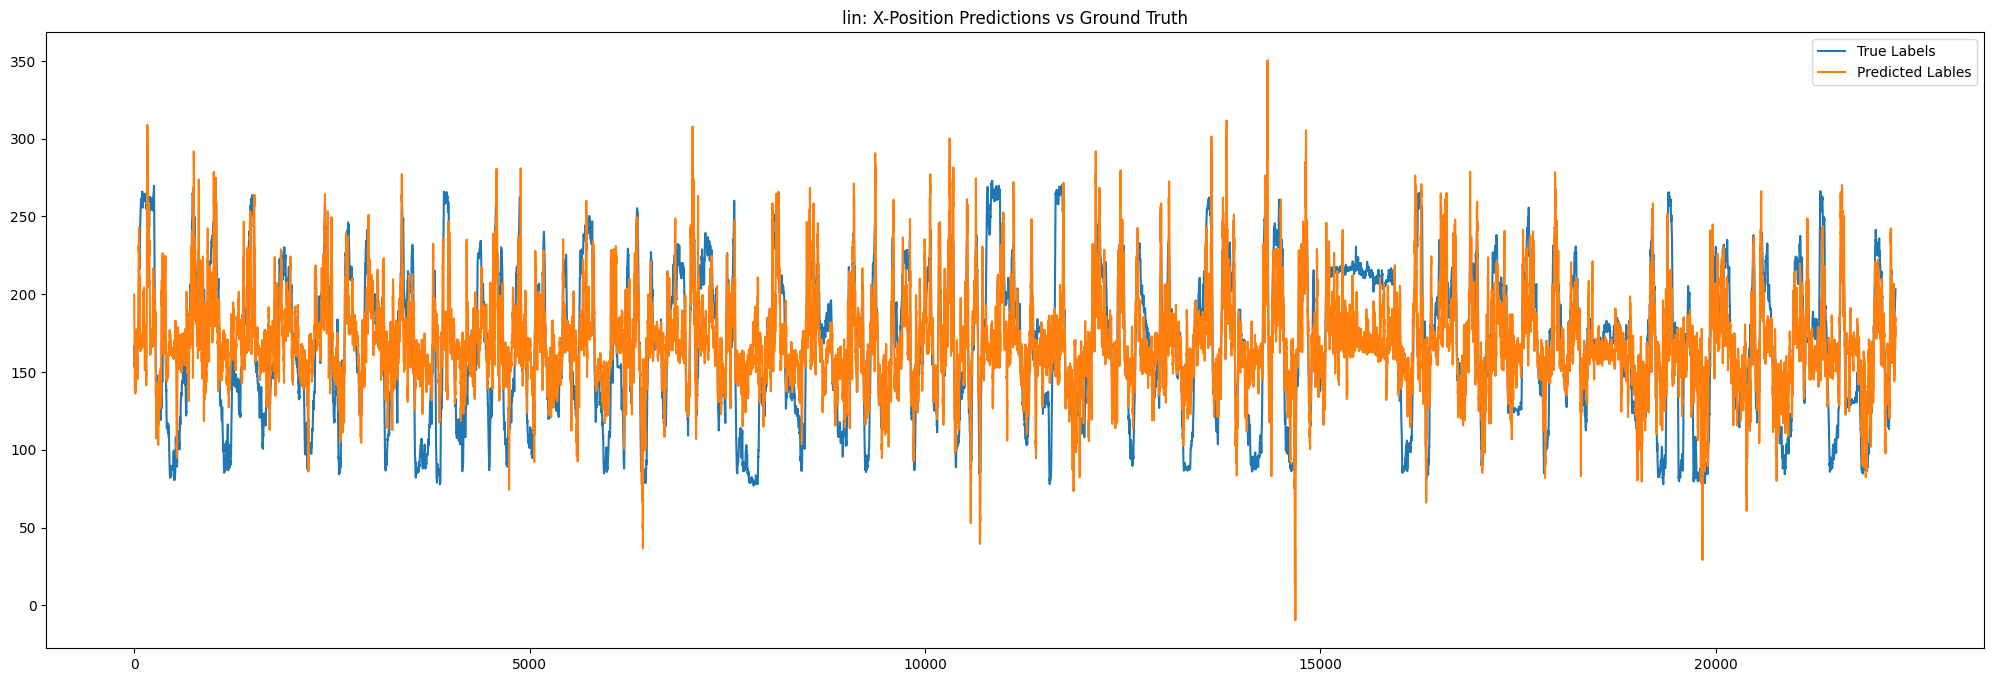

The coefficient of determination (R^2 score) from cross-validation on the X dataset for lin with y positions as labels:
	0.4156959775369865
The optimal hyperparameters for lin evaluated with cross-validation on the X dataset with y positions as labels:
	{'fit_intercept': True}
The time elapsed for validating the lin regressor for y-positions:
	0.397953462600708 minutes


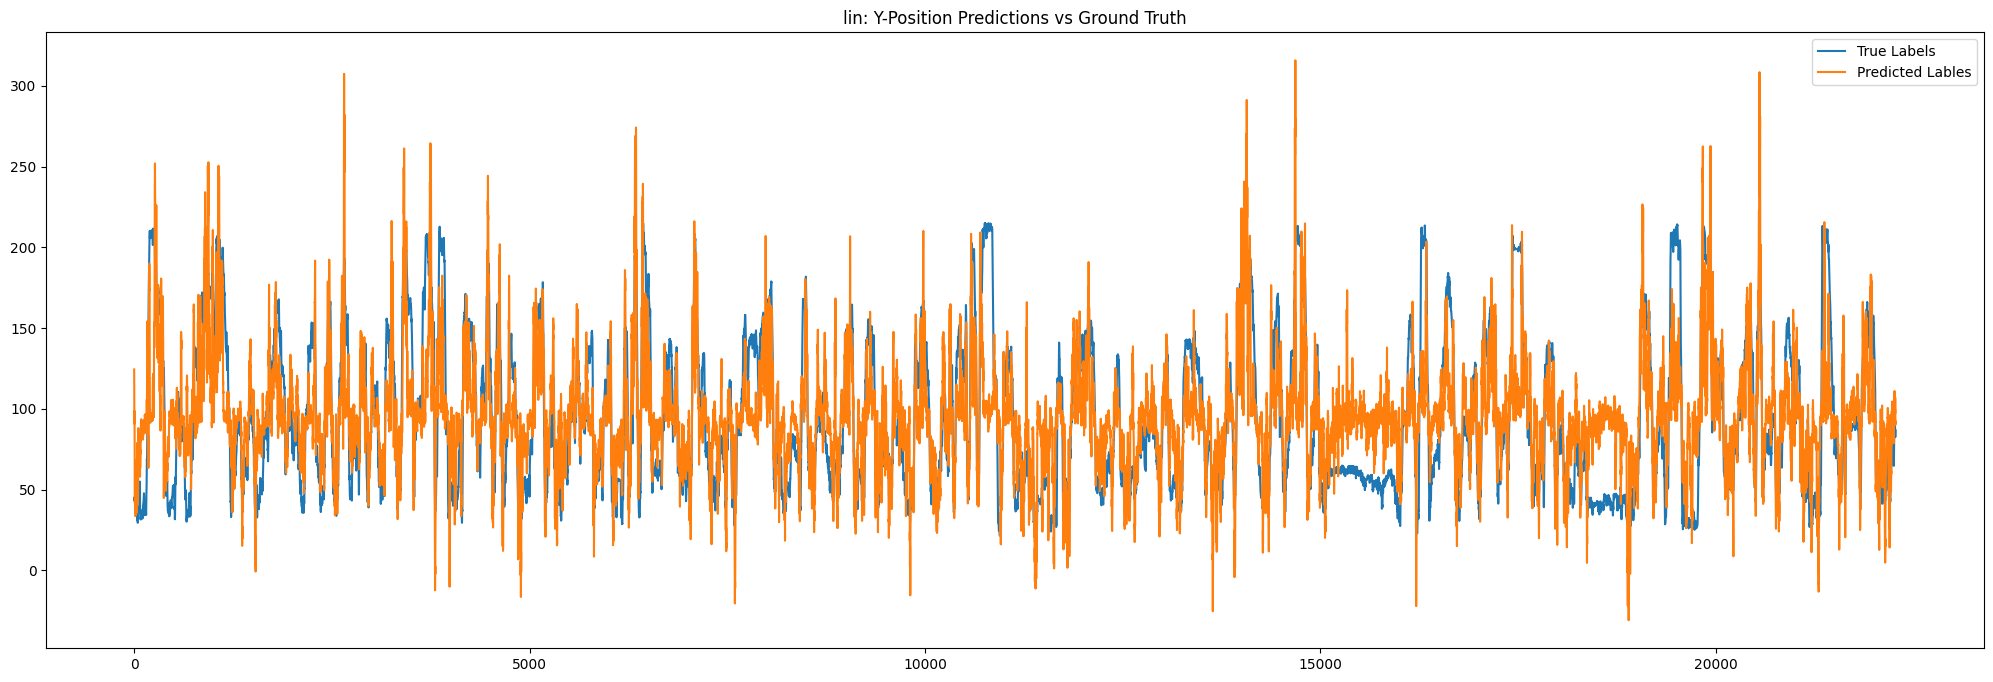

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for lin:
	0.3621243876577847


In [ ]:
# sklearn.linear_model.LinearRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# linear regression example
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#linear-regression-example
lin_reg = linear_model.LinearRegression()

param_grid = {"fit_intercept": [True, False]}

validate_regressor(lin_reg, param_grid, "lin")

####LASSO Regression

The coefficient of determination (R^2 score) from cross-validation on the X dataset for lasso with x positions as labels:
	0.31081800437239493
The optimal hyperparameters for lasso evaluated with cross-validation on the X dataset with x positions as labels:
	{'alpha': 0.01}
The time elapsed for validating the lasso regressor for x-positions:
	0.6205078999201457 minutes


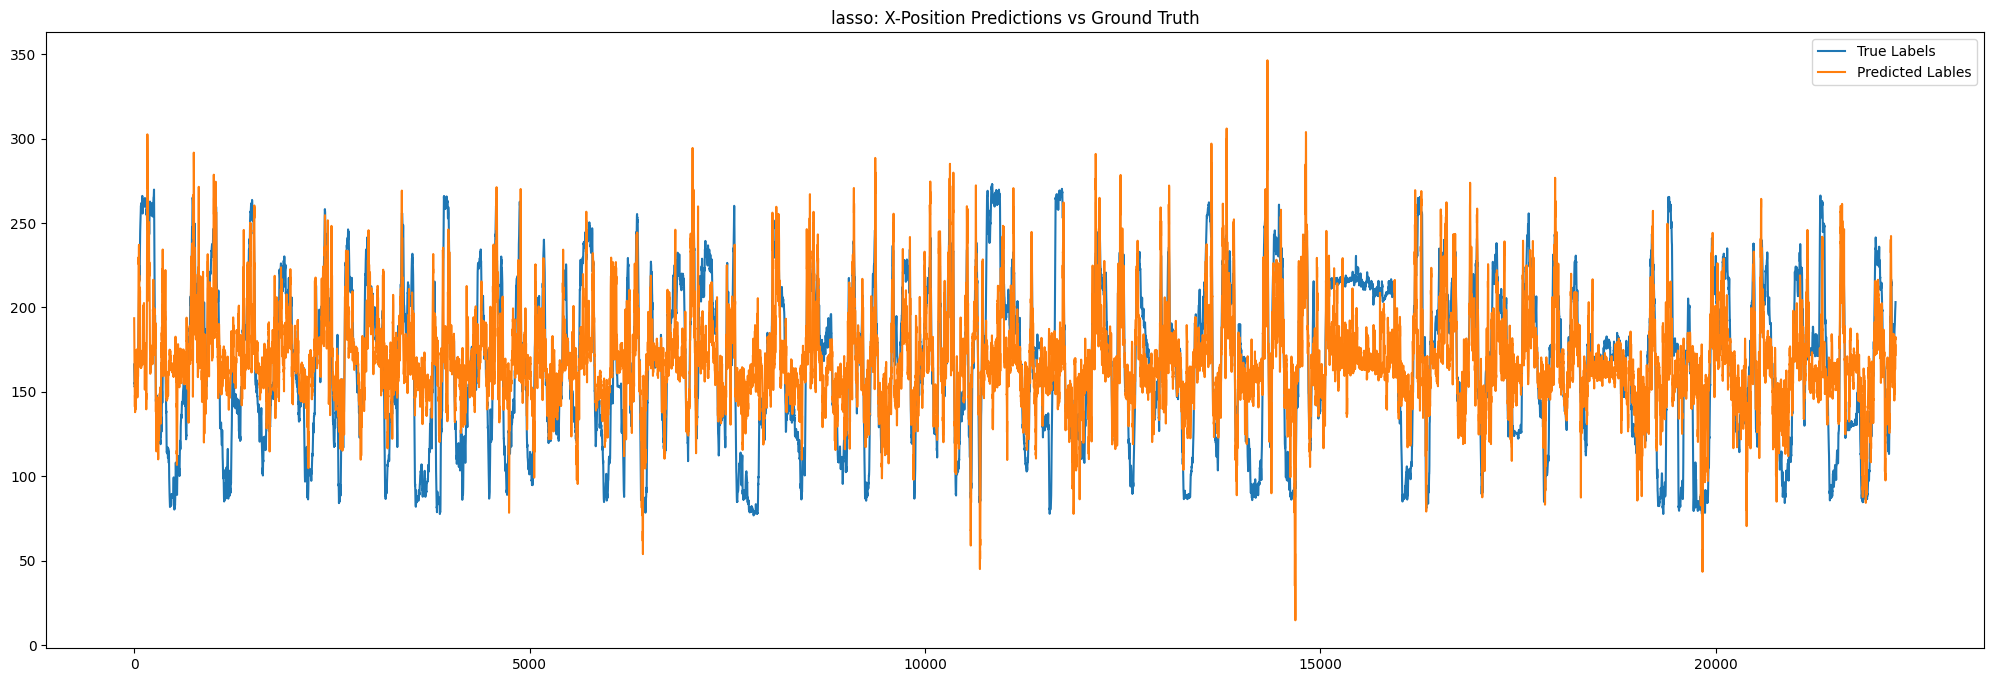

The coefficient of determination (R^2 score) from cross-validation on the X dataset for lasso with y positions as labels:
	0.41852308872326976
The optimal hyperparameters for lasso evaluated with cross-validation on the X dataset with y positions as labels:
	{'alpha': 0.01}
The time elapsed for validating the lasso regressor for y-positions:
	0.6411816795667012 minutes


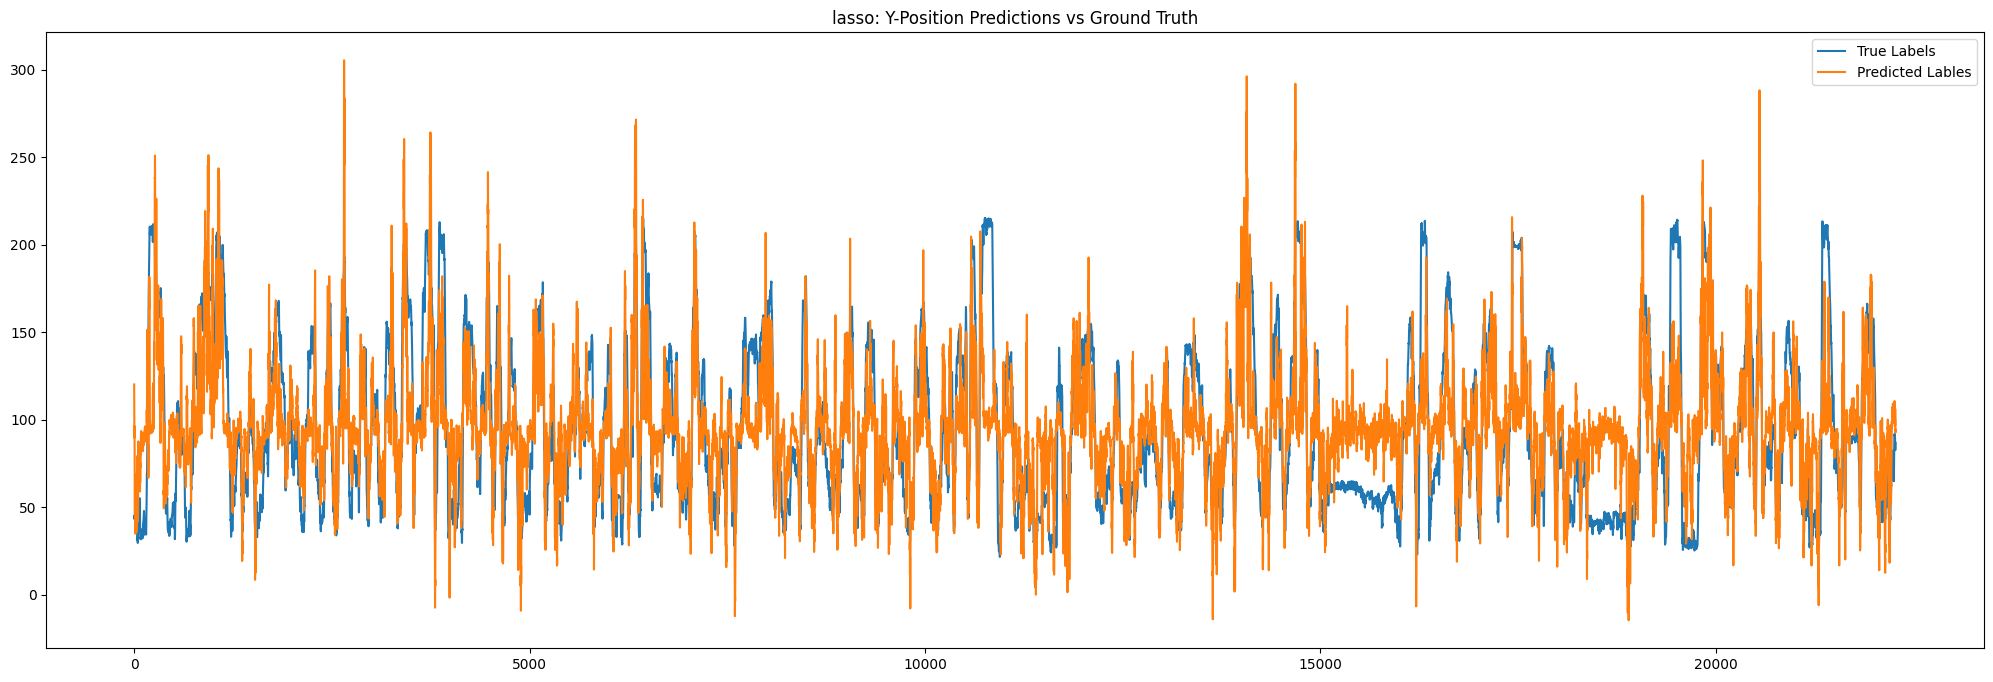

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for lasso:
	0.3646705465478324


In [ ]:
# sklearn.linear_model.Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
lasso_reg = linear_model.Lasso()

# sklearn.model_selection.KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
param_grid = {"alpha": [1e-2, 0.5e-1, 1e-1, 0.5, 1, 0.5e1, 1e1, 0.5e2, 1e2, 0.5e3, 1e3]}

validate_regressor(lasso_reg, param_grid, 'lasso')

####Ridge Regression

The hyperparameter alpha is the coefficient o the $L^2$ norm of the ridge regularization term. The hyperparameter term selected a large value for alpha which implies that the weights minimizing the sum of squared errors actually have considerably large values.

If the large values of the weights becomes a problem, I can attempt to rescale the labels.

The coefficient of determination (R^2 score) from cross-validation on the X dataset for ridge with x positions as labels:
	0.312285369890366
The optimal hyperparameters for ridge evaluated with cross-validation on the X dataset with x positions as labels:
	{'alpha': 10.0}
The time elapsed for validating the ridge regressor for x-positions:
	0.56585267384847 minutes


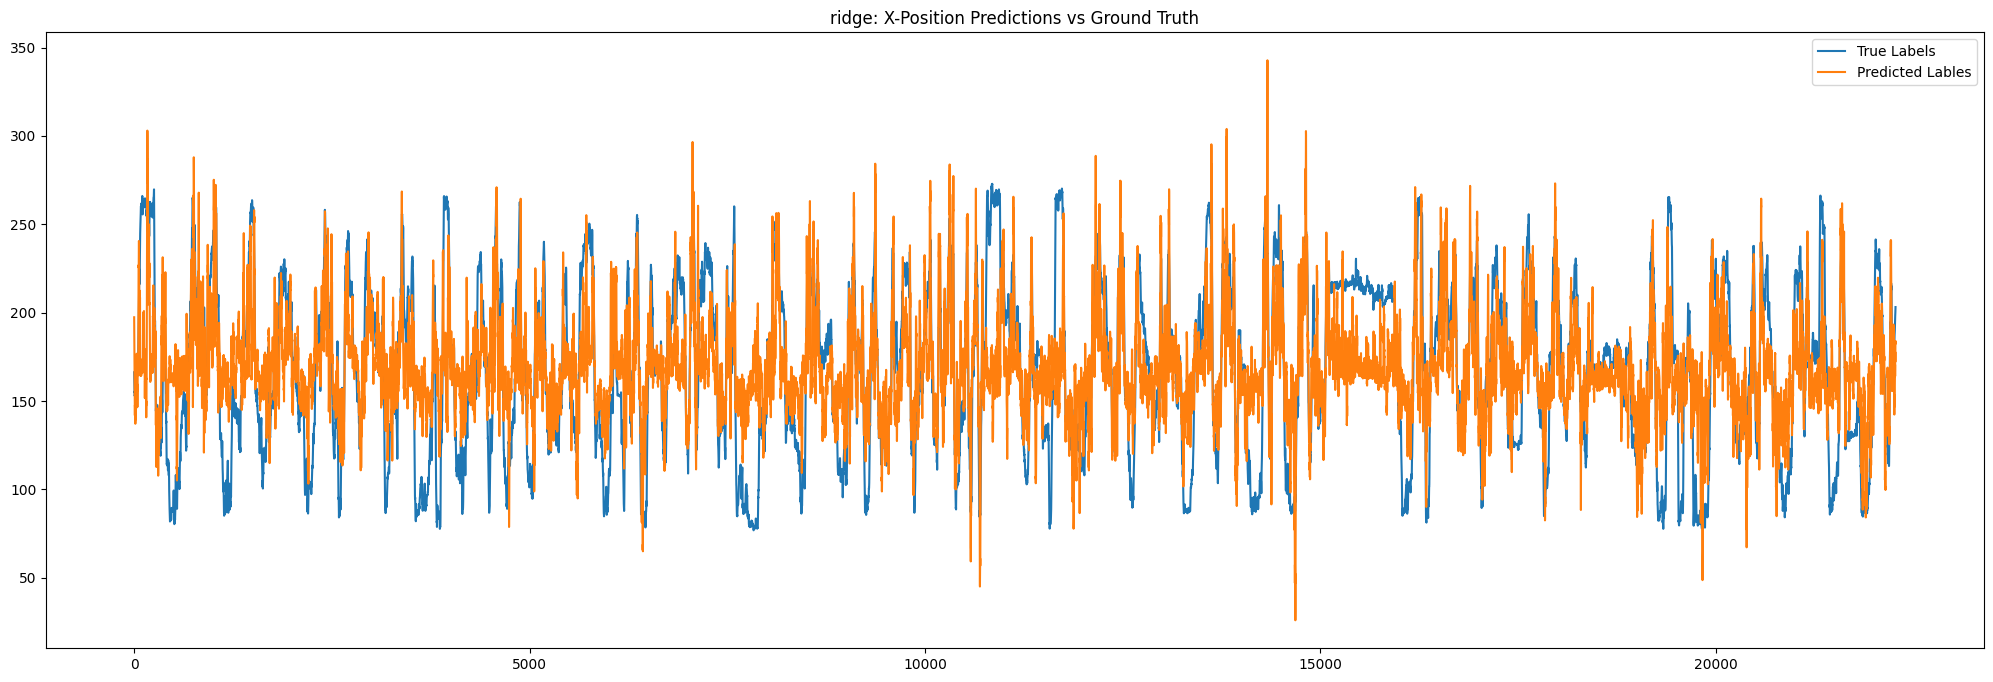

The coefficient of determination (R^2 score) from cross-validation on the X dataset for ridge with y positions as labels:
	0.41998588591786046
The optimal hyperparameters for ridge evaluated with cross-validation on the X dataset with y positions as labels:
	{'alpha': 5.0}
The time elapsed for validating the ridge regressor for y-positions:
	0.6012721657752991 minutes


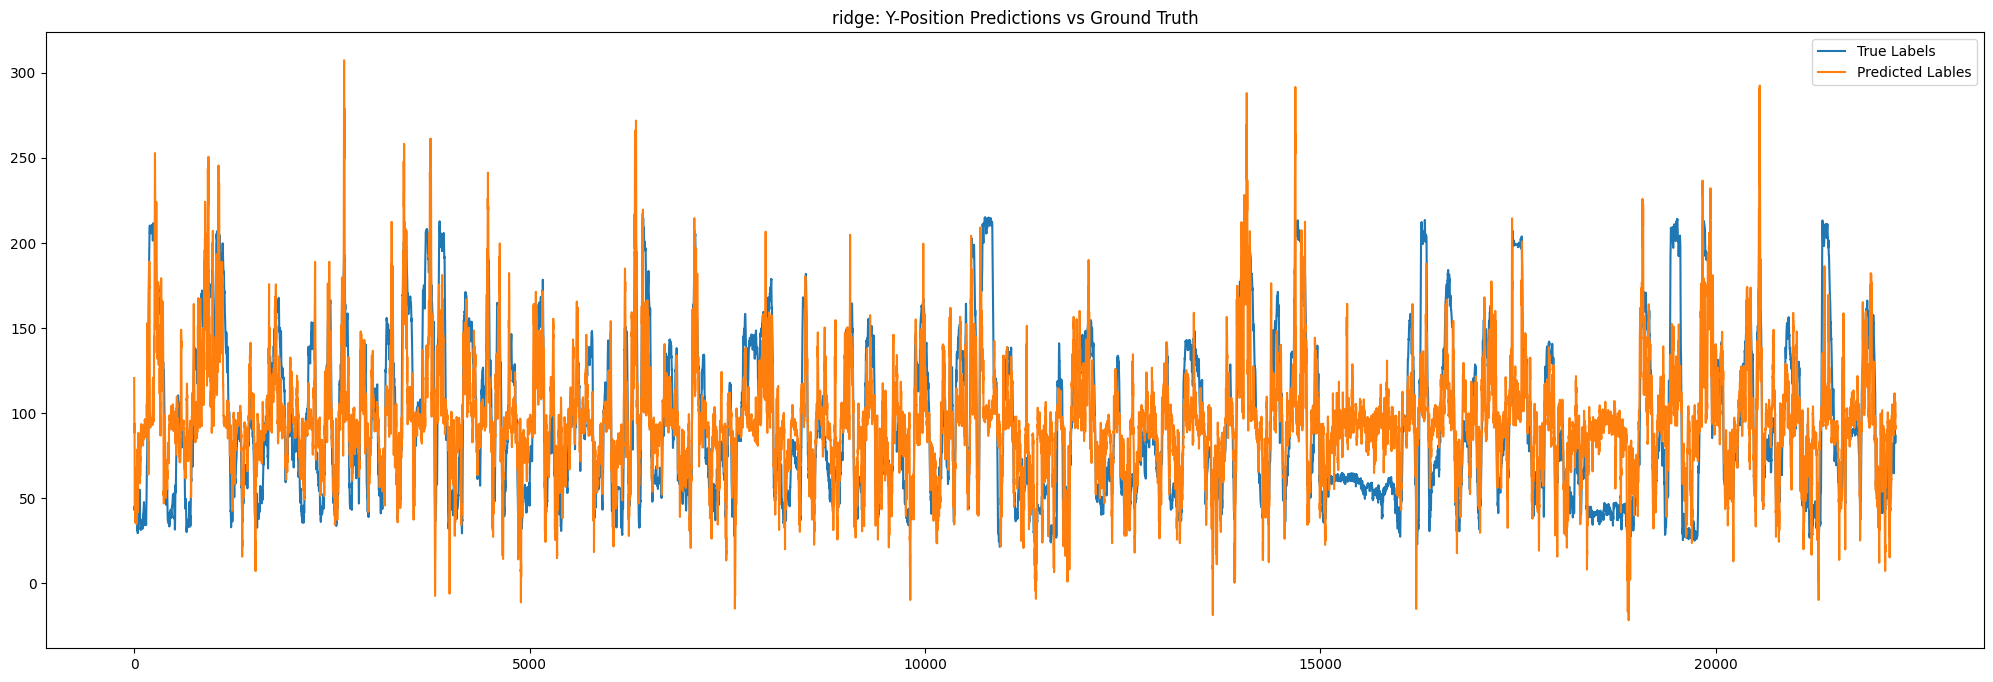

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for ridge:
	0.36613562790411325


In [ ]:
# sklearn.linear_model.Ridge
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
ridge_reg = linear_model.Ridge()

param_grid = {"alpha": [1e-2, 0.5e-1, 1e-1, 0.5, 1, 0.5e1, 1e1, 0.5e2, 1e2, 0.5e3, 1e3]}

validate_regressor(ridge_reg, param_grid, "ridge")

####Support Vector Machine Regression

The scikit-learn training complexity is greater than quadratic in the number of samples. Consequently, training does not scale well beyond a couple of 10,000 training examples.

[sklearn.svm.SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

[MathWorks: Understanding Support Vector Machine Regression](https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html)

#####Linear Support Vector Machine Regression

Using sklearn.svm.SVR(kernel='linear') takes a long time to train with the amount of training data used in this project.


The coefficient of determination (R^2 score) from cross-validation on the X dataset for lin_svm with x positions as labels:
	0.30576900436176907
The optimal hyperparameters for lin_svm evaluated with cross-validation on the X dataset with x positions as labels:
	{'C': 5.0, 'epsilon': 10.0, 'tol': 0.01}
The time elapsed for validating the lin_svm regressor for x-positions:
	2.6552692651748657 minutes


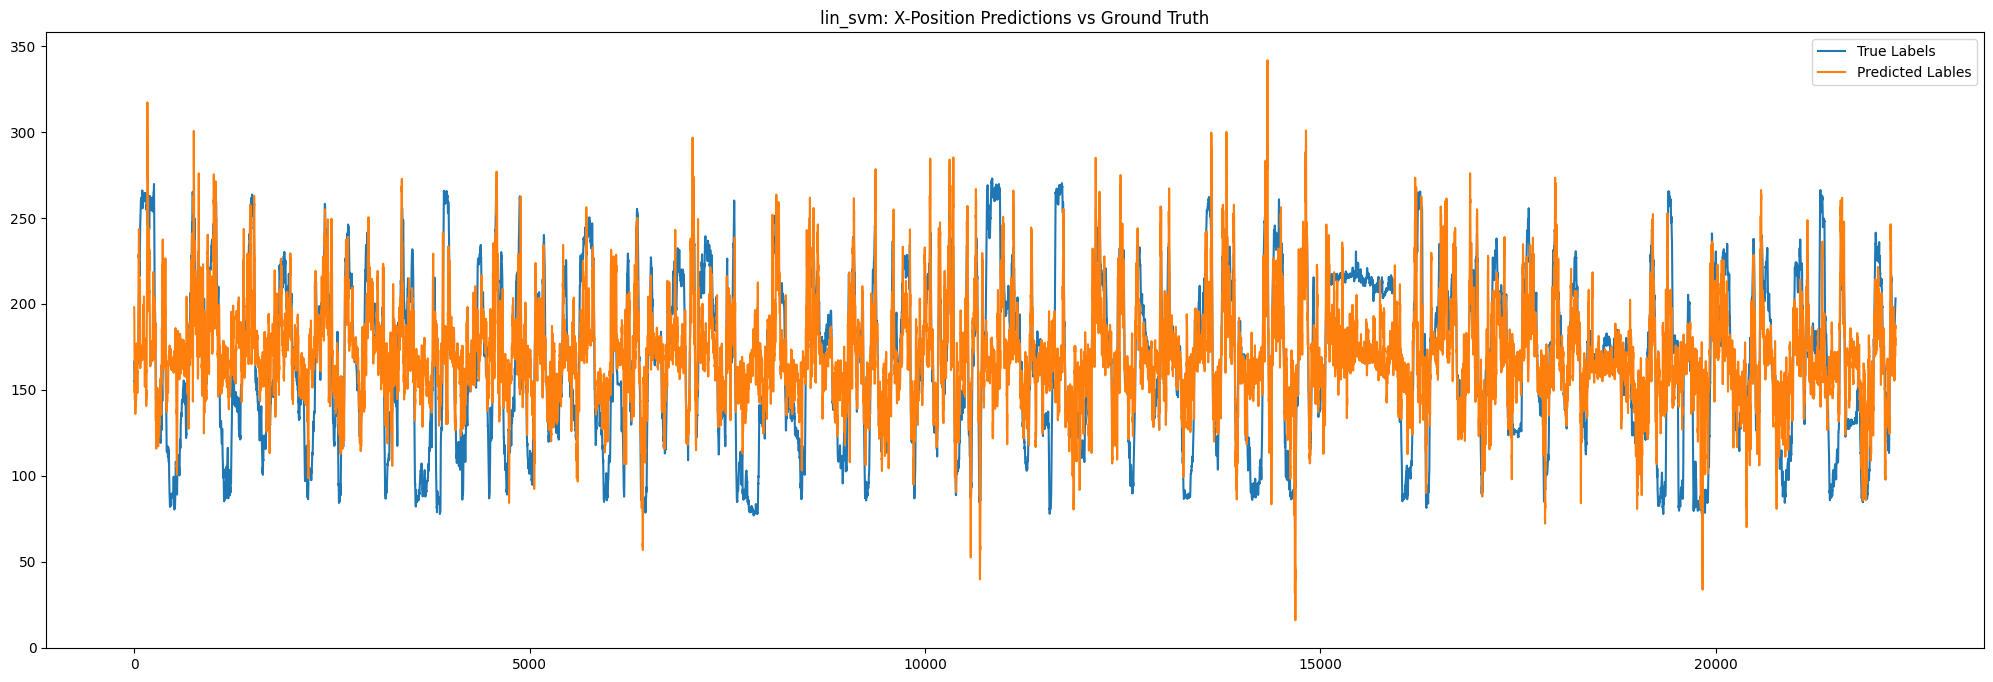

The coefficient of determination (R^2 score) from cross-validation on the X dataset for lin_svm with y positions as labels:
	0.3936354779643142
The optimal hyperparameters for lin_svm evaluated with cross-validation on the X dataset with y positions as labels:
	{'C': 10.0, 'epsilon': 10.0, 'tol': 0.01}
The time elapsed for validating the lin_svm regressor for y-positions:
	3.7806514461835223 minutes


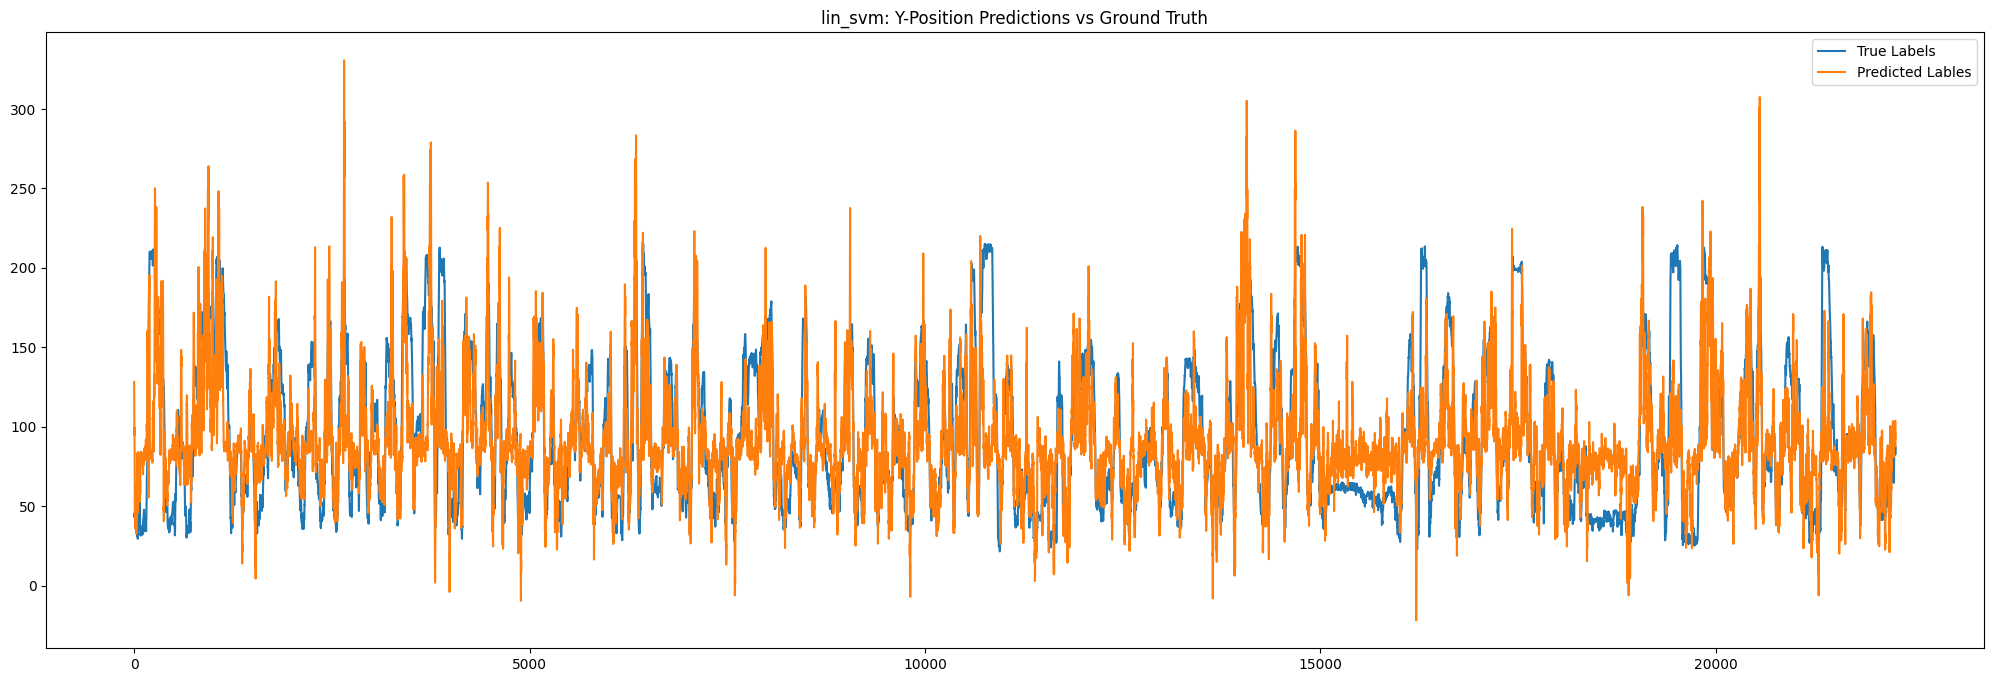

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for lin_svm:
	0.3497022411630416


In [ ]:
# sklearn.svm.linearSVR
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR
lin_svm_reg = svm.LinearSVR(loss='epsilon_insensitive', max_iter=2000)

param_grid = {
    'tol': [1e-4, 1e-3, 1e-2, 1e-1], # if the optimization algorithm is iterative, then this tolerance represents the threshold for stopping when the difference between 2 values is sfficiently small
    'C': [0.5e-2, 1e-2, 0.5e-1, 1e-1, 0.5, 1, 0.5e1, 1e1], # C is the cost associated with making an incorrect decisions during training. the higher C is the more averse the model will be to training misclassification leading to overfitting.
    'epsilon': [1, 1e1, 1e2] # the margin width of the SVM hyperplane. predictions within the margin do not have ay penalty applied
}

validate_regressor(lin_svm_reg, param_grid, 'lin_svm')

#####Polynomial Support Vector Machine Regression

Polynomial SVMR simply takes too long to train. Even with a relaxed tolerance of 10, performing k-fold cross validation for only 2 configurations of the hyperparameters takes at least 15 minutes (I stopped it early).

The last time I successfully got the polynomial SVM estimator for oly the x-position took 30 minutes and the coefficient of determination was less than that of ridge regression (around 0.2).

I do not believe polynomial SVMR is a good candidate for the amount of data involved in this project.

I have tested polynomial SVMR with 10% of the datastet so that th emodel can finish traiing while in a reasonable amount of time. So I have finally seen the model results of a polynomial SVMR of degree 2, and the regression's results were awful. It looked like it was guessing approximately the average of the data. I am not sure why the polynomial SVMR is performing so poorly. I would expect for it to perform at least as well as linear SVMR.

On top of that, when I put both degree 1 and 2 into the hyperparameter optimization routine, the optimization selects 1 as the degree surprisingly. On top of this, the linear SVMR selceetd through the polynomial hperparmater does not perform as well as linearSVR. This may be due to the fact that I am using only 10% of my data or maybe it is due to the routines using 2 different optimization algorithms.

The coefficient of determination (R^2 score) from cross-validation on the X dataset for poly_svm with x positions as labels:
	0.04968497880591353
The optimal hyperparameters for poly_svm evaluated with cross-validation on the X dataset with x positions as labels:
	{'C': 100, 'degree': 1, 'epsilon': 10, 'tol': 0.01}
The time elapsed for validating the poly_svm regressor for x-positions:
	4.111910923322042 minutes


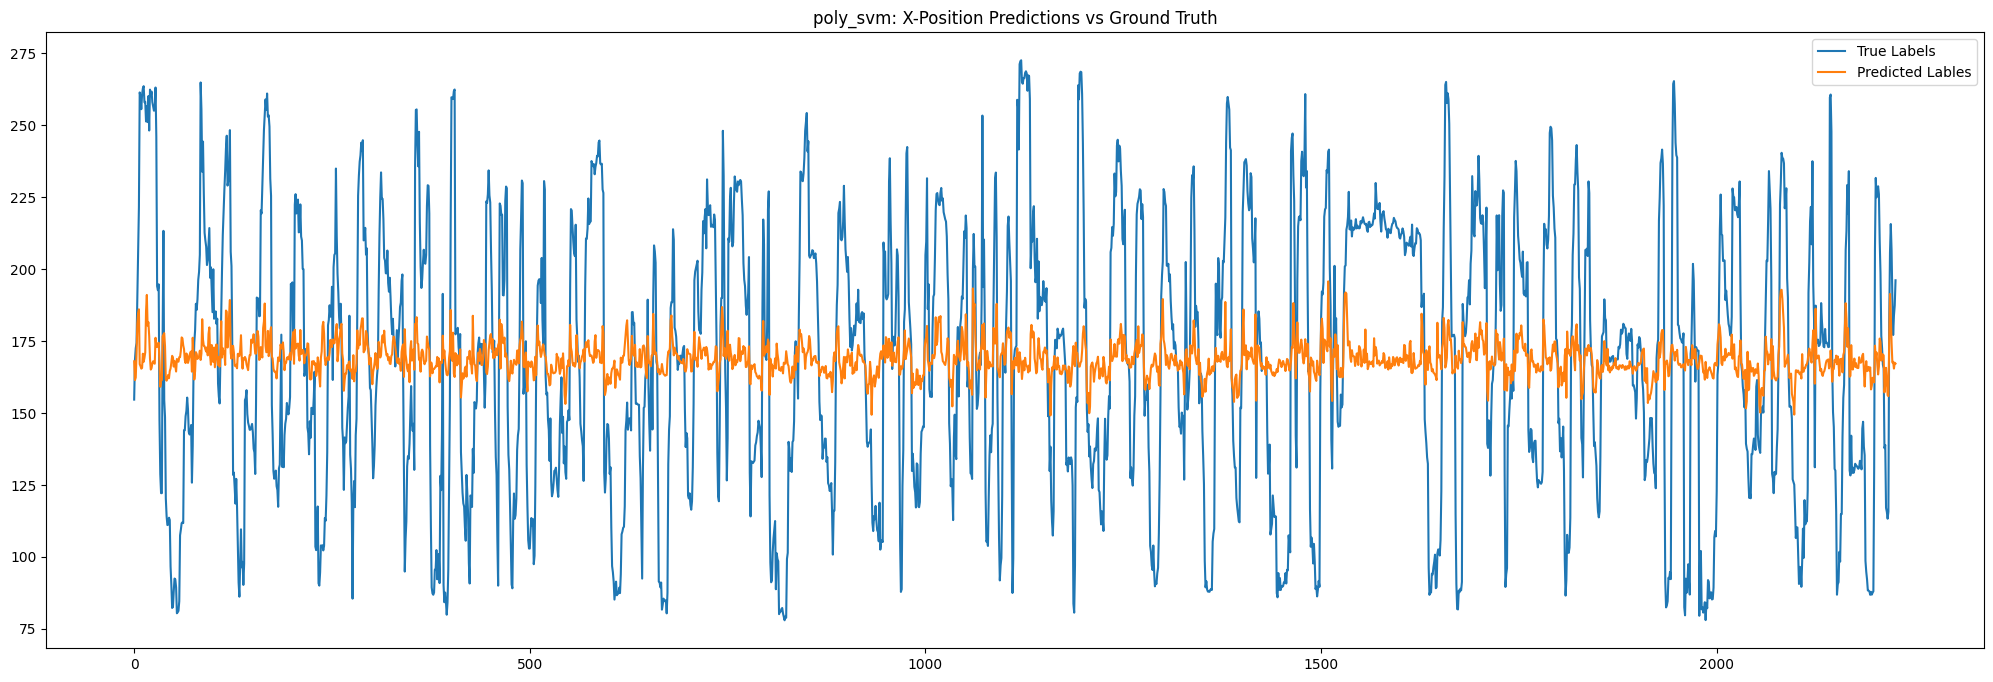

The coefficient of determination (R^2 score) from cross-validation on the X dataset for poly_svm with y positions as labels:
	0.028706891459519435
The optimal hyperparameters for poly_svm evaluated with cross-validation on the X dataset with y positions as labels:
	{'C': 100, 'degree': 1, 'epsilon': 10, 'tol': 0.0001}
The time elapsed for validating the poly_svm regressor for y-positions:
	4.072463774681092 minutes


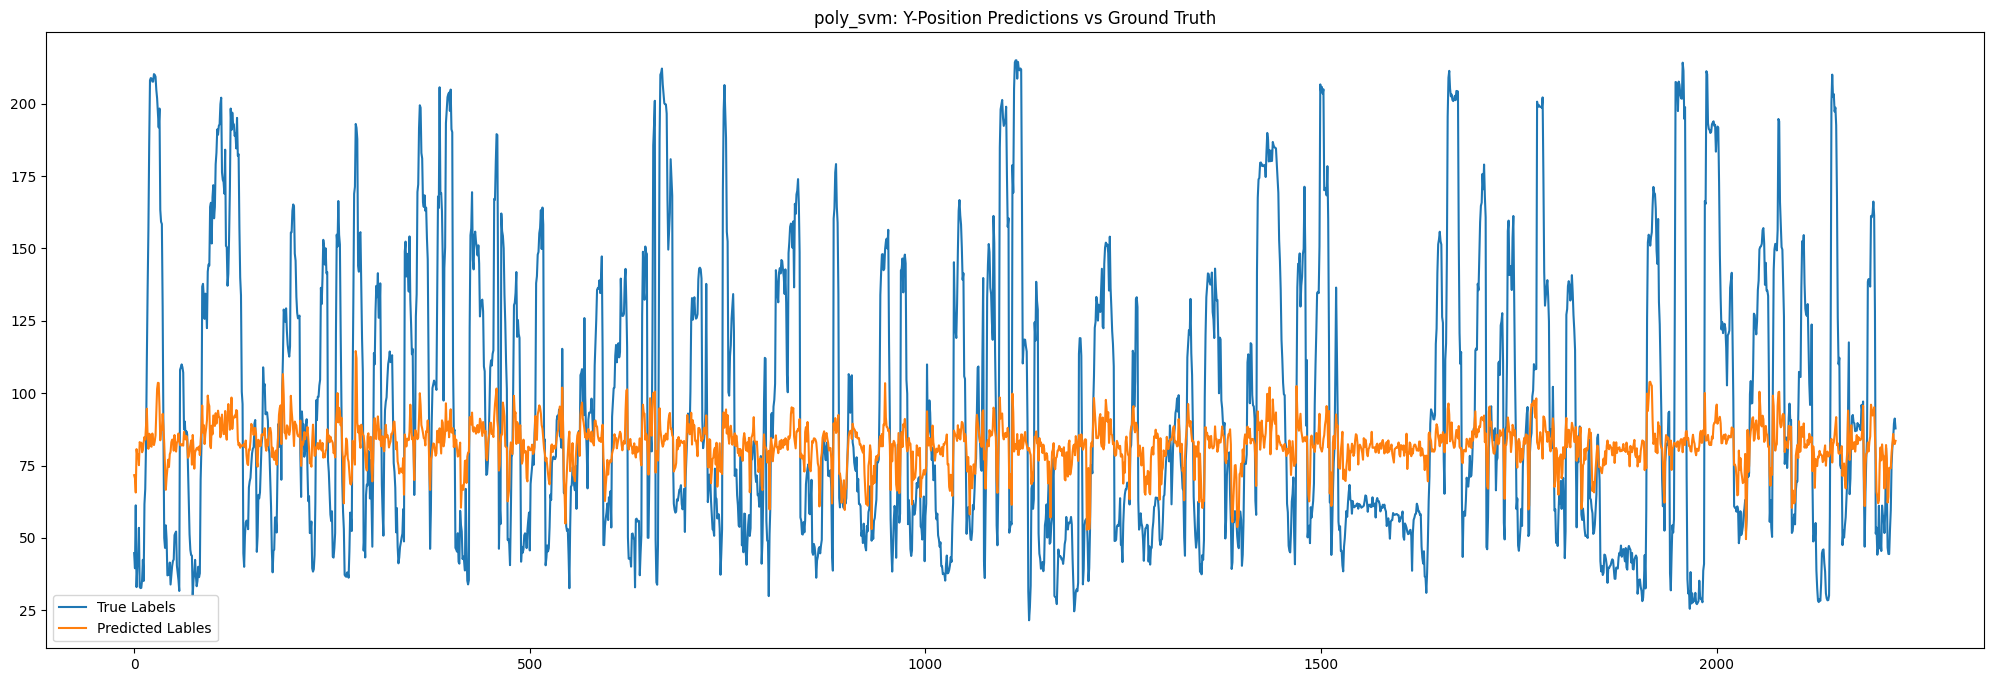

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for poly_svm:
	0.03919593513271648


In [ ]:
# sklearn.svm.SVR
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
poly_svm_reg = svm.SVR(kernel='poly', gamma='auto', coef0=0)
revalidate = True

# sklearn.svm.SVR is not recommended for large datasets. therefore, i will be 
# using polynomial regression with a very limited grid search.
param_grid = {
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'degree': [1, 2],
    'C': [1e-2, 1, 5, 10, 100], # C is the cost associated with making an incorrect decisions during training. the higher C is the more averse the model will be to training misclassification leading to overfitting.
    'epsilon': [10] # the margin width of the SVM hyperplane. predictions within the margin do not have any penalty applied
}
# , 3, 4, 5
# , 1e-1, 1, 1e1
# , 1, 1e2

# i am training polynomial support vector machine regression with less data 
# because of its extremely slow training time.
poly_svm_idx = np.random.default_rng().random(num_train_examples) > 0.9
validate_regressor(poly_svm_reg, param_grid, 'poly_svm', X=X_train_matrix[poly_svm_idx, :], y=y_train[poly_svm_idx])

####k Nearest Neighbors (k-NN) Regression

In k-NN regression, the predicted label is determined by the weighted average of the knearest training examples.

[sklearn: k-NN Regression](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression)

The coefficient of determination (R^2 score) from cross-validation on the X dataset for knn with x positions as labels:
	0.15574611123722953
The optimal hyperparameters for knn evaluated with cross-validation on the X dataset with x positions as labels:
	{'n_neighbors': 50, 'weights': 'distance'}
The time elapsed for validating the knn regressor for x-positions:
	1.503029223283132 minutes


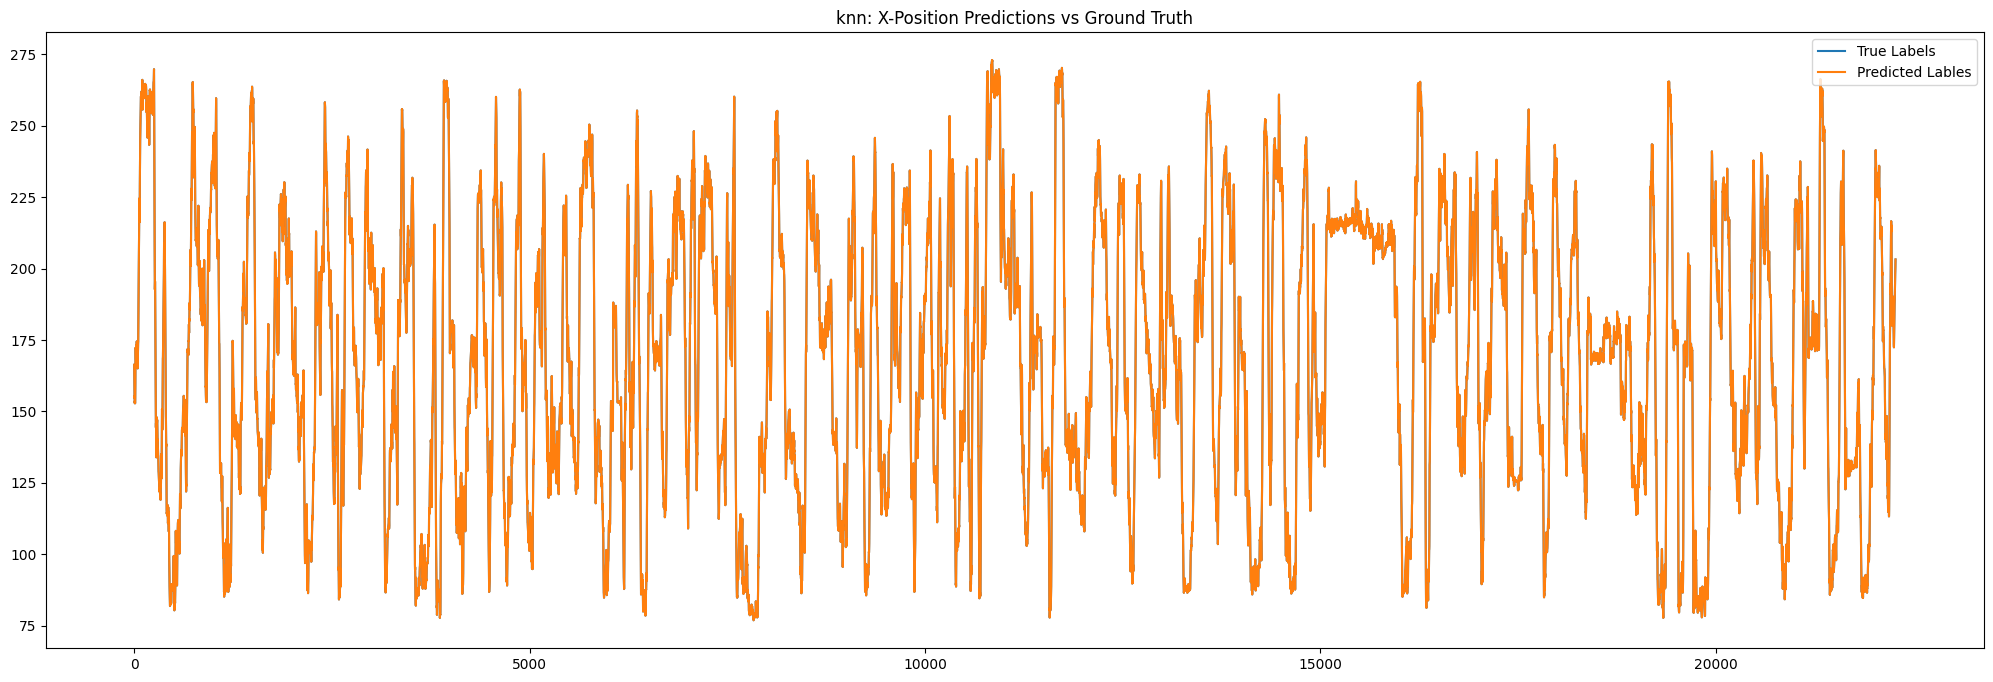

The coefficient of determination (R^2 score) from cross-validation on the X dataset for knn with y positions as labels:
	0.2555124460088291
The optimal hyperparameters for knn evaluated with cross-validation on the X dataset with y positions as labels:
	{'n_neighbors': 10, 'weights': 'distance'}
The time elapsed for validating the knn regressor for y-positions:
	1.5401217341423035 minutes


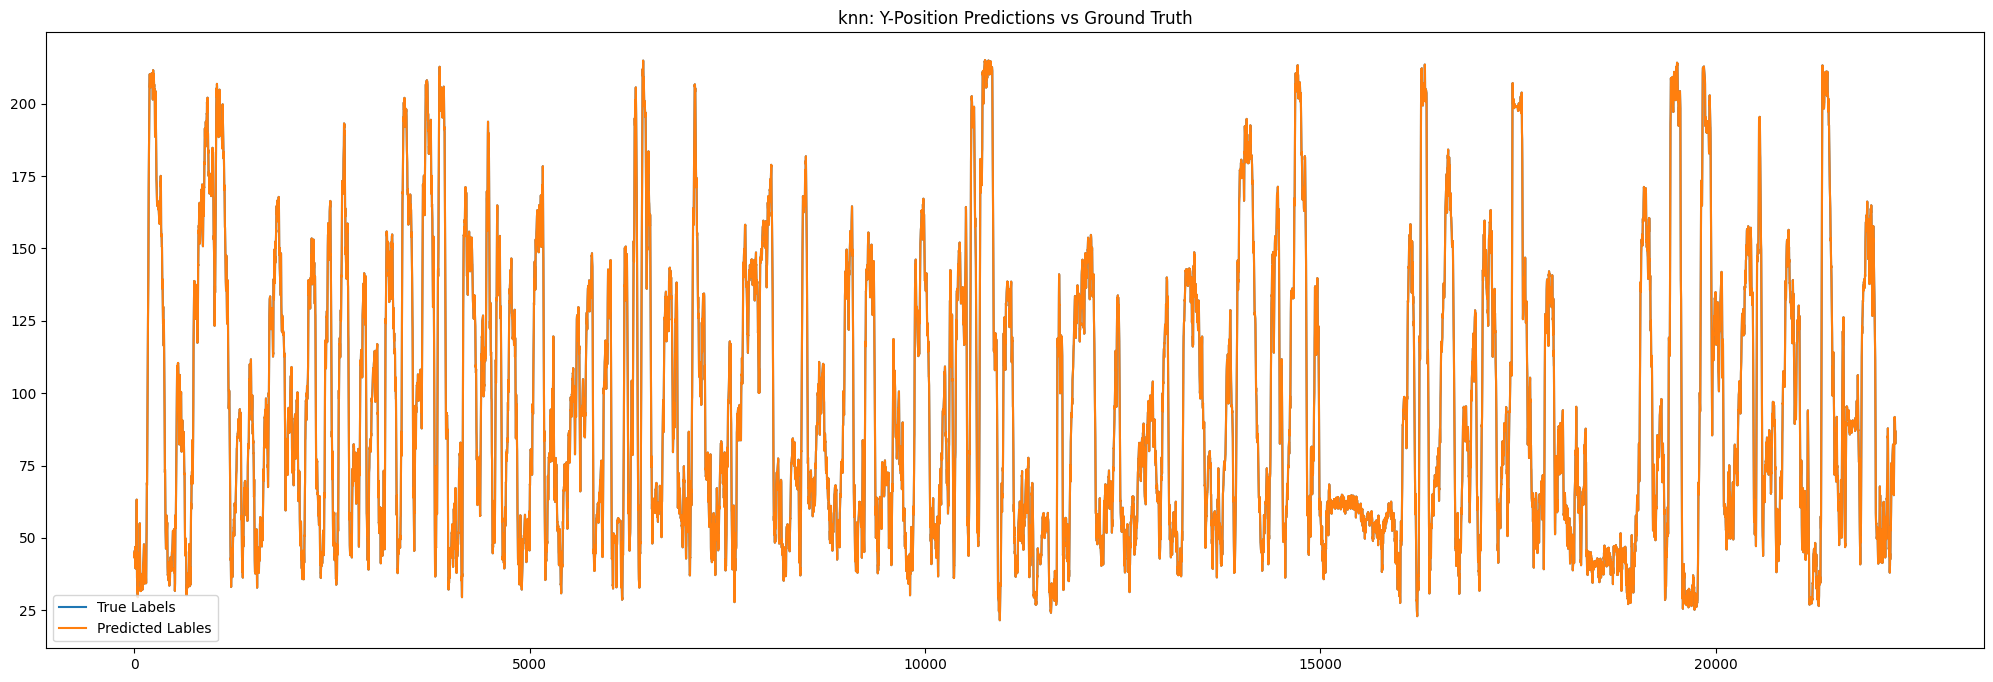

The average coefficient of determination (R^2 score) from cross-validation on the X_train_matrix dataset for knn:
	0.20562927862302932


In [ ]:
# sklearn.neighbors.KNeighborsRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
knn_reg = neighbors.KNeighborsRegressor(algorithm='brute')

param_grid = {
    'n_neighbors': [5, 10, 50],
    'weights': ['uniform', 'distance']
}

validate_regressor(knn_reg, param_grid, 'knn')

####Decision Trees Regression

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

[sklearn: Forest of Randomized Trees](https://scikit-learn.org/stable/modules/ensemble.html#forest)

####Artificial Neural Network

Out of all of my model types, ridge regression is the best performing; however, this is just a linear model with an L2 penalty. I should at least be able to recreate this performance in a neural network.

I think that I should really try to cross-validate the neural network data. The validation loss tends to spike during trianing. This maybe because the validation set is not representative of the training set. To fix this I should consider using cross-validation to receive several datasets which may increase my chances of finding a validation-training split that is more mutually representative than the set I have selected. 

[Neural Network Initialization](https://www.deeplearning.ai/ai-notes/initialization/index.html)

The S-shaped learning curve seems to also occur when the weights are intialized to values that are either too large or too small. In order to remedy this issue, maybe I should consider normalizing my labels or changing my neural network intialization scheme.

After normalizing my labels, the initial plateau seems to have disappeared, but I did not test this in isolation of other model changes, so the disappearance of the initial plateau may or may not be due to normalizing the data labels.

[tf.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)

[Debugging TensorFlow](https://www.freecodecamp.org/news/debugging-tensorflow-a-starter-e6668ce72617/)

[Introduction to Gradient Clipping Techniques with Tensorflow
](https://cnvrg.io/gradient-clipping/)

For training my neural networks, I will be using mean-squared error (MSE) as my loss function. Therefore, my objective function during traiing is to minimize the MSE. However, for the meta-learning problem of selecting the optimal model architecture during validation, I will maximize the $R^2$ score.

[Make sure that you have GPU acceleration on.](https://www.tensorflow.org/guide/gpu)

Use an algorithm called evolutionary constructive and pruning algorithm (ECPA) to determine the structure of the neural network (i.e. number of hidden units and number of layers) $^{[3]}$ (https://www.sciencedirect.com/science/article/abs/pii/S0925231212001154?via%3Dihub)

The paper does cost money, but there are other algorithms that have their disadvantages such as constructive, pruning, and evolutionary algorithms. References for these may be available for free, but also if the original paper that I found has source code, I can just reference that fro the algorithm definition.

Use early stopping to make sure that the model doesn't overfit and lose its ability generalize.

Try using state of the art methods that tend to improve the performance of base models such as drop out, batch normalization, and layer normalization (to normalize the values passed in between layers).

I may also want to test out methods in Neural Architecture Search.

[A Gentle Introduction to Exploding Gradients in Neural Networks](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/#:~:text=How%20to%20Fix%20Exploding%20Gradients%3F%201%201.%20Re-Design,Gradient%20Clipping%20...%204%204.%20Use%20Weight%20Regularization)

[R2 Score Loss Function Keras 0](https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score)

[R2 Score Loss Function Keras 1](https://stackoverflow.com/questions/65840698/how-to-make-r2-score-in-nn-lstm-pytorch)

In [ ]:
nn_hp = {
    "max_epochs": 20,
    "learning_rate": 1e-1,
    "batch_size": 16,   # set to 32 for mini-batch gradient descent
    "precent_val_data": 0.2    # this is the percentage of the training data used for validation.
}

# i did not see any examples of readily available solutions for performing 
# k-fold cross-validation with a keras neural network model. specifically with
# kt. so, for simplicity and speed, i will just set aside a validation set from
# the training set.
# the fact that cross-validation is not an option with neural networks may also 
# be a good thing. since neural networks often have extremely long training 
# times.
# TODO: write code for cv with a tf nn
tv_boundary = int(np.round(num_train_examples * nn_hp["precent_val_data"] - num_train_examples))
X_train_matrix_nn = X_train_matrix[:tv_boundary, :]
X_train_tensor_nn = X_train_tensor[:tv_boundary, :, :]
y_train_nn = y_train[:tv_boundary, :]
X_val_matrix_nn = X_train_matrix[tv_boundary:, :]
X_val_tensor_nn = X_train_tensor[tv_boundary:, :, :]
y_val_nn = y_train[tv_boundary:, :]

scaler = preprocessing.StandardScaler().fit(y_train_nn)
y_train_nn_mean = scaler.mean_
y_train_nn_std = scaler.scale_
print(f"Labels mean:\n\t{y_train_nn_mean}\n")
print(f"Labels standard deviation:\n\t{y_train_nn_std}\n")
print(f"Labels variance:\n\t{scaler.var_}\n")
y_train_nn = scaler.transform(y_train_nn)
y_train_nn_inv = scaler.inverse_transform(y_train_nn)
y_val_nn = scaler.transform(y_val_nn)

def neg_r2_score_tf(y_true, y_pred):
    SSres = tf.math.squared_difference(y_true, y_pred)
    # tf.math.reduce_mean
    # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
    SStot = tf.math.squared_difference(y_true, tf.reduce_mean(y_pred))
    assert SSres.shape == SStot.shape, f"SSres of shape {SSres.shape} and SStot of shape {SStot.shape} do not have the same shape."
    # negate the typical loss function so that when tf minimizes this function, 
    # it is actually maximizing the r2 score
    return -1 * (1 - SSres / SStot)


def plot_nn_loss_curve(hist):
    """
    plot the loss at the end of every epoch
    """
    # training loss after each epoch
    plt.plot(hist.history['loss'], label='loss')
    # validation loss after each epoch
    plt.plot(hist.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [dstance units squared]')
    plt.legend(("training loss", "validation loss"))
    plt.grid(True)
    plt.show()

def validate_nn(
    architect_nn, 
    X_train=X_train_matrix_nn, 
    y_train=y_train_nn,
    X_val=X_val_matrix_nn,
    y_val=y_val_nn
):
    """
    hyperparameter tuning in keras
    https://www.tensorflow.org/tutorials/keras/keras_tuner
    """
    # kt.Hyperband
    # https://keras.io/api/keras_tuner/tuners/hyperband/
    tuner = kt.Hyperband(
        architect_nn,  # a callable that takes hyperparameters and returns a tf.keras.Model
        # the selection of hyperparameters is determined by a model instance's final
        # r2-score
        # https://keras.io/api/keras_tuner/tuners/objective/#objective-class
        objective=kt.Objective(name="neg_r2_score_tf", direction="min"),
        max_epochs=10,
        factor=2,  # the recursive reduction factor for each bracket
        directory='kt',
        project_name='nnhpopt'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # the arguments for search() are the same as fit()
    # tf.keras.Model.fit()
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    tuner.search(
        X_train, 
        y_train, 
        batch_size=nn_hp["batch_size"],
        epochs=75, 
        validation_data=(X_val, y_val), 
        callbacks=[stop_early]
    )

    # get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps, tuner.hypermodel.build(best_hps)

def print_nn_weights(nn):
    print(nn.layers)
    for l in nn.layers:
        print(l)
        w = l.get_weights()[0]
        print(f'weight matrix (shape:{w.shape}, size:{w.size}):')
        print(w)
        b = l.get_weights()[1]
        print(f'bias vector (shape:{b.shape}, size:{b.size}):')
        print(b)
        print()

Labels mean:
	[167.60273166 106.29551952]

Labels standard deviation:
	[49.72494612 51.31790564]

Labels variance:
	[2472.57026637 2633.52743911]



#####Multilayer Perceptron

The optimal hyperparameters for mlp:
	{'hp_units_d0': 64, 'hp_units_d1': 64, 'hp_l1_alpha': 0.1, 'hp_l2_alpha': 0.001, 'hp_learning_rate': 0.0001, 'hp_clipvalue': 0.5, 'tuner/epochs': 10, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0030'}

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d0 (Dense)                  (None, 64)                26560     
                                                                 
 do (Dense)                  (None, 2)                 130       
                                                                 
Total params: 26,690
Trainable params: 26,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
279/279 [==============================] - 3s 8ms/step - loss: 0.9522 - neg_r2_score_tf: 968.3144 - mean_squared_error: 0.9522 - val_loss: 0.8347 - val_neg_r2_score

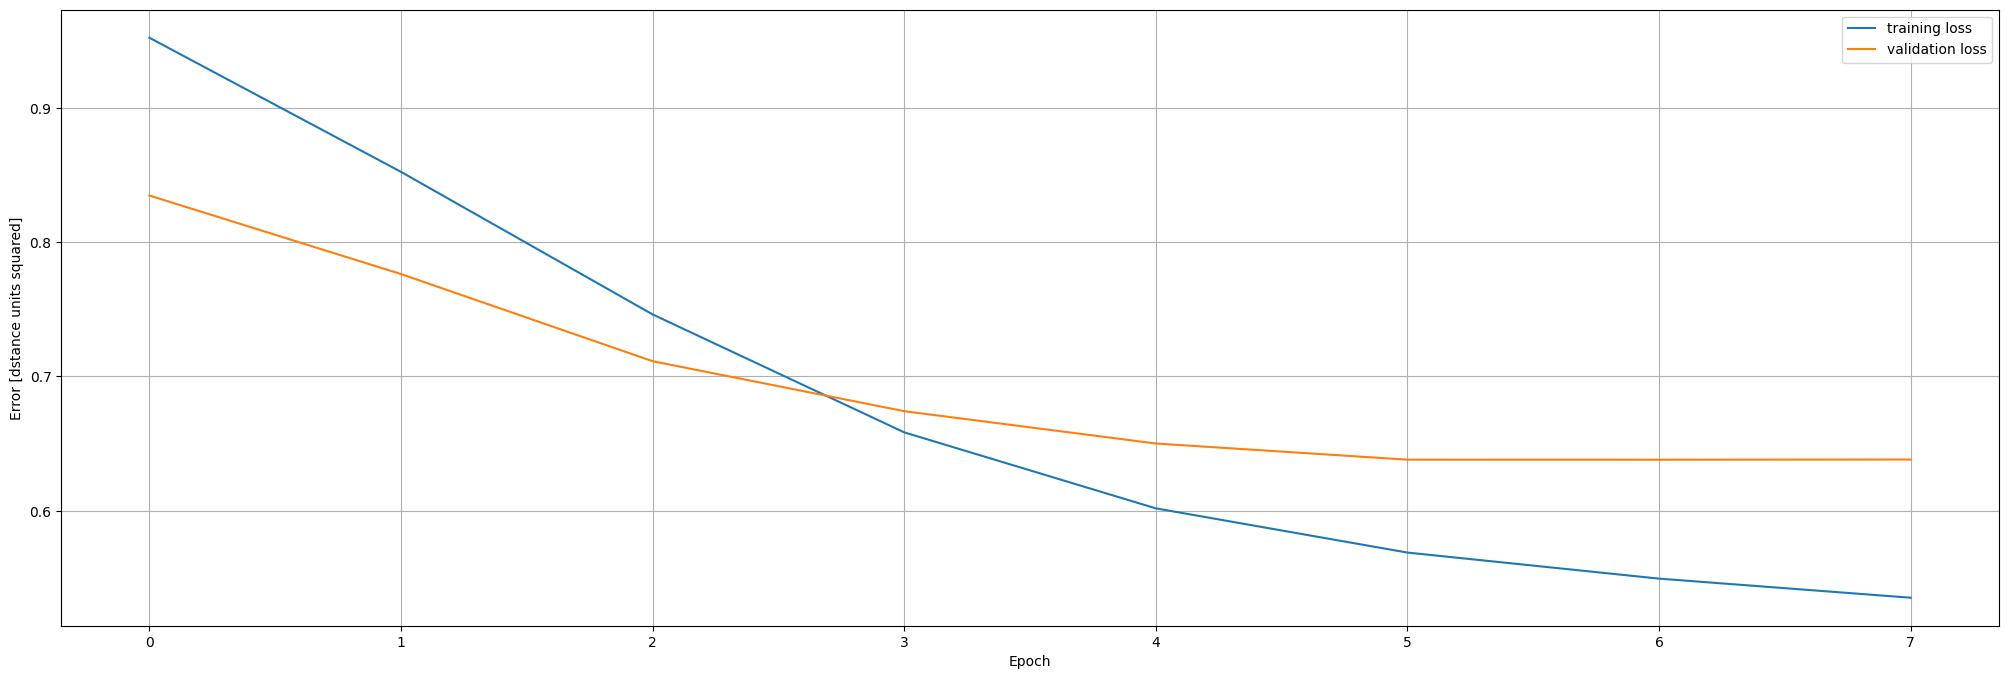

140/140 [==============================] - 0s 2ms/step


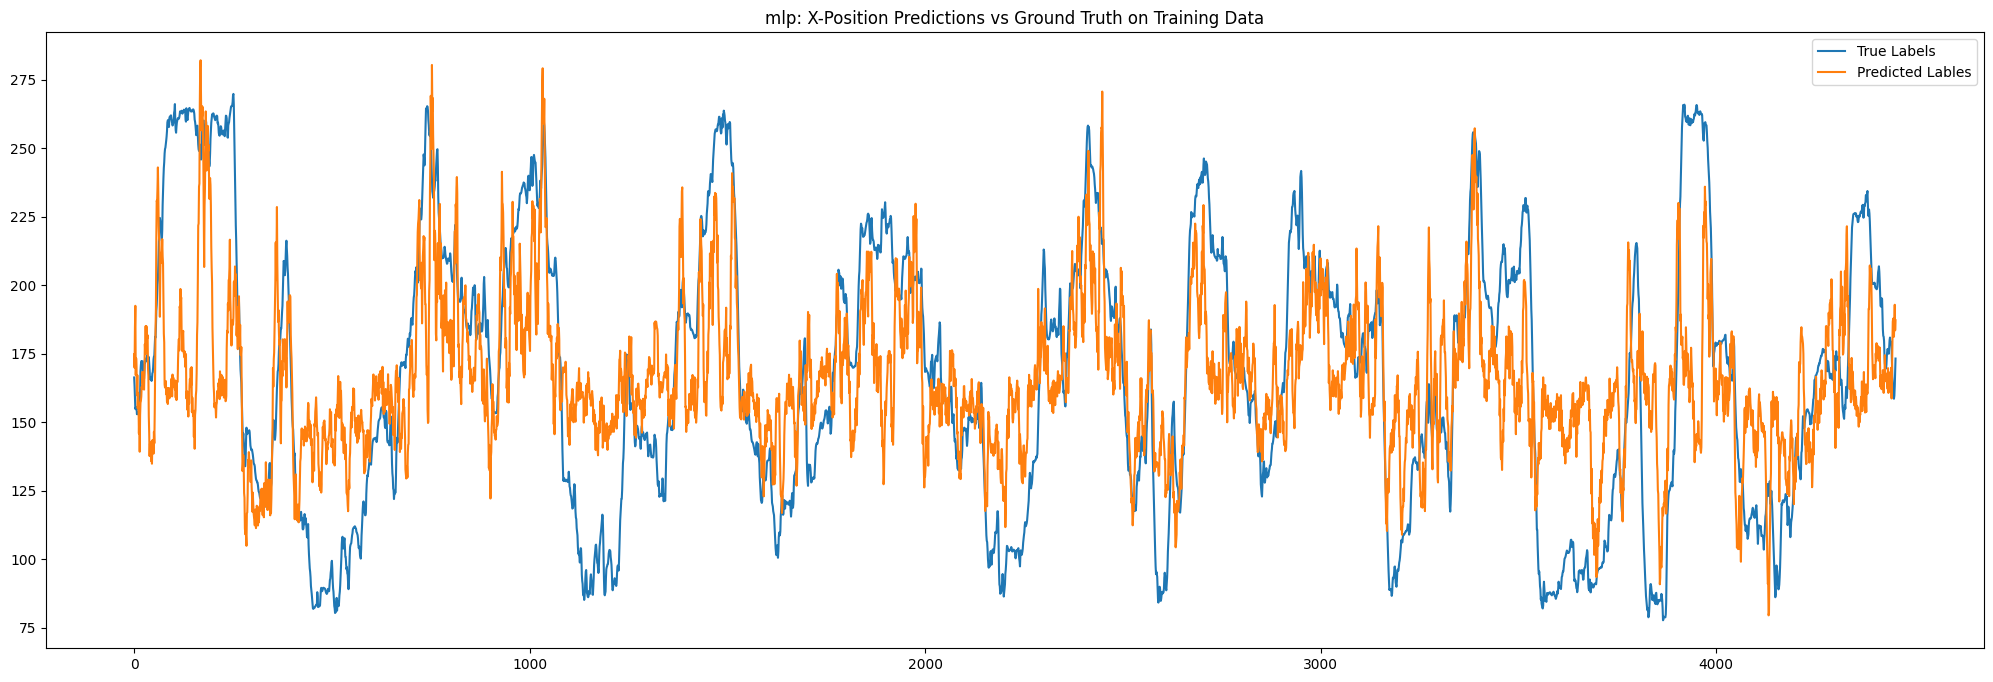

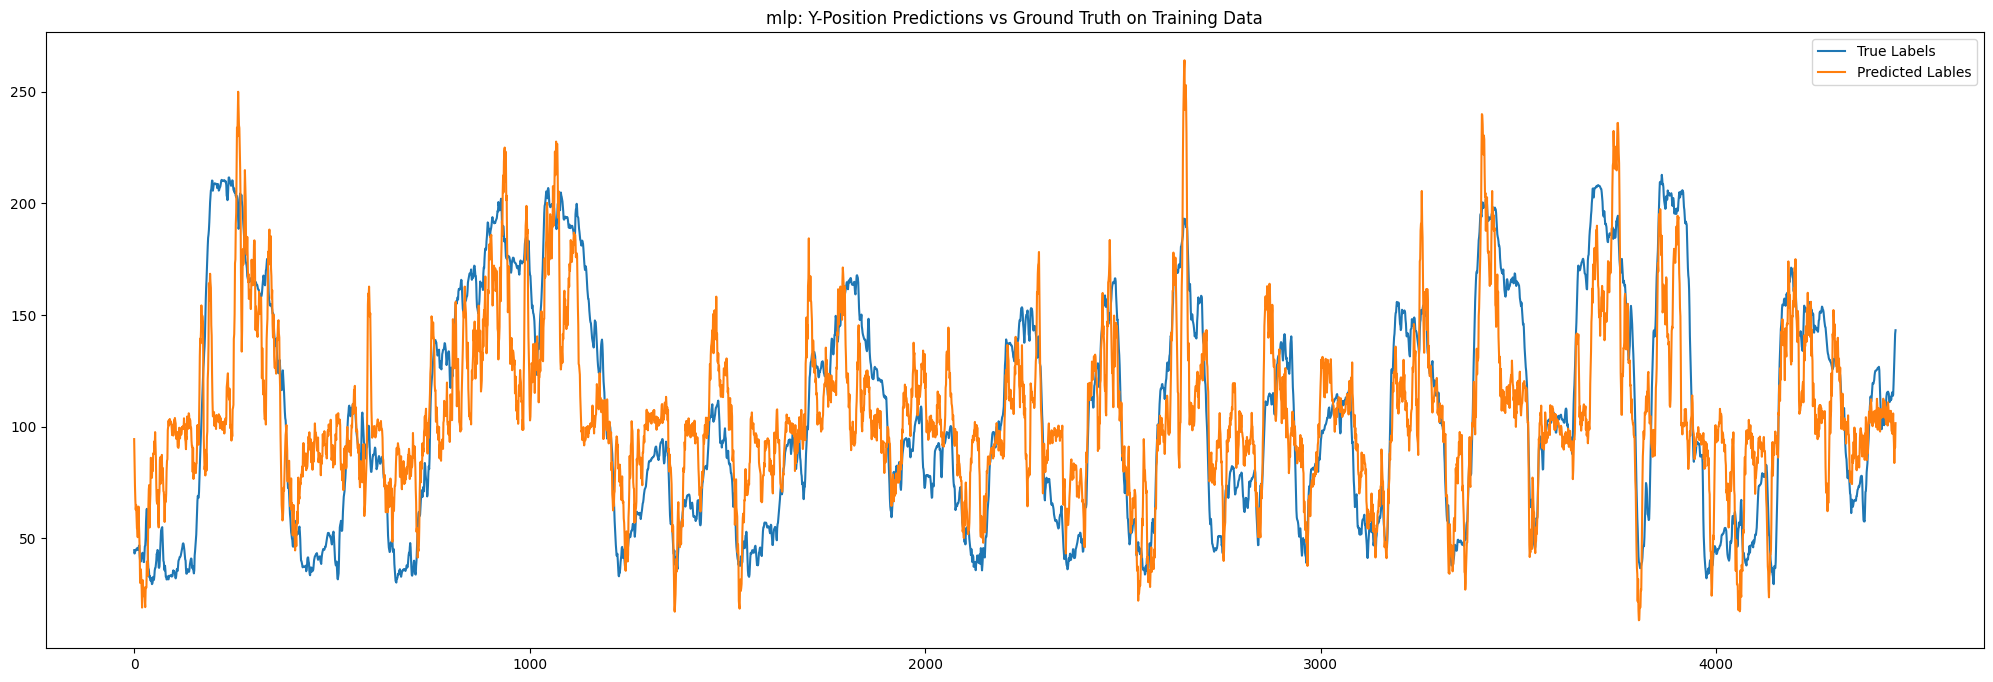

In [ ]:
def architect_mlp(hp):
    """
    kt.HyperParameters
    https://keras.io/api/keras_tuner/hyperparameters/#int-method

    tf.keras.layers.Dense
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

    tf.keras.regularizers.Regularizer
    https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
    tf.keras.regularizers.L1L2
    https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1L2

    mlp learnings
    -------------
    my mlp model was making predictions very close to 0. i originally had no 
    idea why this was happening. i suspected that this may be due to weights 
    close to zero, but observing the weights did not really help diagnose the 
    problem since i only expected for the weights to be larger, but i did not 
    know how large they should be.

    i also tried changing the loss function. i wanted the loss function to be 
    the r2 score since that was the metric i was using to select for validation;
    however, using the mean-squared error continued training with more epochs
    before being stopped by early stopping and had far more stable gradients 
    than the ones produced by r2. so, for the sake of learning, i changed the 
    loss function from r2 to mse.

    i then interpreted this x-intercept prediction trend to mean that the model
    was not learning the features of the data very well. the problem in this 
    case was not overfitting, as is a common problem in mlp, but severe 
    underfitting. i included multiple regularization methods from my first 
    attempts at mlp, so since was underfitting and i know that mlp should have 
    at least the expressive/approximation power of ridge regression, i started
    removing regularization methods one by one (early stopping, L1 
    regularization, L2 regulraization).

    after removing the L1L2 penalties, the model started learning again.

    i actually think that i started in all of these penalties because i wanted 
    to see if i could make the loss function the r2 score.
    """
    hp_units_d0 = hp.Int('hp_units_d0', min_value=32, max_value=128, step=16)
    # hp_units_d1 = hp.Int('hp_units_d1', min_value=16, max_value=128, step=16)
    # hp_d0_l1_alpha = hp.Choice('hp_l1_alpha', values=[0.0, 1e-3, 1e-2, 1e-1, 1.0])
    # hp_d0_l2_alpha = hp.Choice('hp_l2_alpha', values=[0.0, 1e-3, 1e-2, 1e-1, 1.0])

    nn = tf.keras.Sequential(
        [
            tf.keras.Input(name='in', shape=X_train_matrix_nn.shape[1]),
            tf.keras.layers.Dense(name='d0', units=hp_units_d0, activation='relu'), #, kernel_regularizer=tf.keras.regularizers.L1L2(hp_d0_l1_alpha, hp_d0_l2_alpha)),
            # tf.keras.layers.Dense(name='d1', units=hp_units_d1, activation='relu'),#, kernel_regularizer=tf.keras.regularizers.L1L2(hp_l1_alpha, hp_l2_alpha)),
            # tf.keras.layers.Dense(name='d2', units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(hp_l1_alpha, hp_l2_alpha)),
            tf.keras.layers.Dense(name='do', units=2)
        ],
        name='mlp')

    # a large learning rate (1e-1) was causing my training to terminate after 
    # only a few epochs
    hp_learning_rate = hp.Choice('hp_learning_rate', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
    hp_clipvalue = hp.Choice('hp_clipvalue', values=[0.1, 0.5, 1.0, 100.0, 200.0])
    # hp_loss = hp.Choice('hp_loss', values=[tf.keras.metrics.mean_squared_error, neg_r2_score_tf])

    # tf.keras.Model.compile()
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
    # tf.keras.losses.MeanSquaredError
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
    nn.compile(
        loss=tf.keras.metrics.mean_squared_error,
        # tf.keras.optimizers.Adam
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp_learning_rate,
            clipvalue=hp_clipvalue  # added gradient clipping to see if that helps with the exploding gradient.
        ),
        metrics=[neg_r2_score_tf, tf.keras.metrics.mean_squared_error]
    )

    return nn

name = 'mlp'

meta_optimal_hp, meta_optimal_mlp = validate_nn(architect_mlp)
print(f"The optimal hyperparameters for {name}:\n\t{meta_optimal_hp.values}\n")

meta_optimal_mlp.summary()

# tf.keras.callbacks.EarlyStopping
# stop training when a monitored metric has stopped improving.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1, # number of epochs with no improvement after which training will be stopped
    mode='min'
)

# tf.keras.Model.fit()
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = meta_optimal_mlp.fit(
    X_train_matrix_nn,
    y_train_nn,
    batch_size=nn_hp["batch_size"],
    epochs=100,
    validation_data=(X_val_matrix_nn, y_val_nn),
    callbacks=[early_stopping]
)

plot_nn_loss_curve(hist)

# tf.keras.Model.evaluate()
# returns the loss value and metrics values for the model in test mode.
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# the metrics and the loss may differ because of penalty terms. the value 
# returned by the loss also includes athe addition of any penalty terms.
# https://stackoverflow.com/questions/58876233/tensorflow-should-loss-and-metric-be-identical
val_metrics = meta_optimal_mlp.evaluate(X_val_matrix_nn, y_val_nn)
# TODO: figure out why json won't allow you to serialize the model configuration
#   information dircetly. it may be related to this stackoverflow post:
#   https://stackoverflow.com/questions/53082708/typeerror-object-of-type-float32-is-not-json-serializable
#   "optimizer": f"{meta_optimal_mlp.optimizer.get_config()}", 
#   "architecture": f"{meta_optimal_mlp.get_config()}"
all_reg_val_info[name] = (
    -val_metrics[meta_optimal_mlp.metrics_names.index('neg_r2_score_tf')],
    meta_optimal_hp.values
)

# Model.predict()
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
y_pred = scaler.inverse_transform(meta_optimal_mlp.predict(X_train_matrix_nn))
plot_preds_vs_truth(y_train_nn_inv[:, 0], y_pred[:, 0], f"{name}: X-Position Predictions vs Ground Truth on Training Data")
plot_preds_vs_truth(y_train_nn_inv[:, 1], y_pred[:, 1], f"{name}: Y-Position Predictions vs Ground Truth on Training Data")

# y_pred = meta_optimal_mlp.predict(X_train_matrix_nn)
# plot_preds_vs_truth(y_train_nn[:, 0], y_pred[:, 0], f"{name}: X-Position Predictions vs Ground Truth of Training Data")
# plot_preds_vs_truth(y_train_nn[:, 1], y_pred[:, 1], f"{name}: Y-Position Predictions vs Ground Truth of Training Data")

In [ ]:
print_nn_weights(meta_optimal_mlp)

[<keras.layers.core.dense.Dense object at 0x7f6ccafb5790>, <keras.layers.core.dense.Dense object at 0x7f6ccafb5640>]
weight matrix (shape:(414, 64), size:26496):
[[ 0.09827077  0.02693807  0.00975786 ...  0.08527311  0.09247516
   0.02773822]
 [ 0.01499895  0.06326845  0.00701304 ...  0.12225238  0.01553686
   0.04158475]
 [ 0.13697234 -0.06738754  0.15881321 ...  0.06008835 -0.03465328
   0.02423977]
 ...
 [-0.06435911  0.08768882 -0.0591662  ...  0.01658399  0.10492875
  -0.02798153]
 [ 0.11177069  0.03584841 -0.02183997 ... -0.0977648  -0.03966948
  -0.02830481]
 [-0.02905444  0.0855772  -0.0902755  ...  0.09511038 -0.04536831
   0.10731925]]
bias vector (shape:(64,), size:64):
[ 0.01951452  0.04393106  0.02173767 -0.00955593  0.01375477 -0.00585574
  0.00597811 -0.00712571  0.0383521   0.03711241  0.02642999 -0.00547138
  0.00876174  0.01204754  0.03210704  0.01107854 -0.00156049  0.00637334
  0.03329933  0.02715987 -0.00688714  0.02674698 -0.0014111   0.03770349
  0.03030864  0.01

#####Recurrent Neural Network

Recurrent neural networks are the best performing type of neural network for BMI neural decoding $^{[3]}$. To address model staleness, they included error connections that are reminiscent of residuals.

[Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)

[Tips for training recurrent neural networks](https://danijar.com/tips-for-training-recurrent-neural-networks/)

[100-Page ML Book: RNNs](https://www.dropbox.com/s/uh48e6wjs4w13t5/Chapter6.pdf?dl=0)

[Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation)

#####Long Short-Term Memory

[Kording Lab: LSTM Regression](https://github.com/KordingLab/Neural_Decoding/blob/71a3c9ba2161cb1d8642bcefb96e8f29ccab7366/Neural_Decoding/decoders.py#L594)

The optimal hyperparameters for lstm:
	{'hp_units_d0': 64, 'hp_units_d1': 64, 'hp_l1_alpha': 0.1, 'hp_l2_alpha': 0.001, 'hp_learning_rate': 0.0001, 'hp_clipvalue': 0.5, 'tuner/epochs': 10, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0030', 'hp_units_lstm0': 32, 'learning_rate': 0.0001}

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm0 (LSTM)                (None, 32)                10112     
                                                                 
 do (Dense)                  (None, 2)                 66        
                                                                 
Total params: 10,178
Trainable params: 10,178
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
279/279 [==============================] - 10s 17ms/step - loss: 0.9888 - neg_r2_score_tf: 2.6269 - mean_s

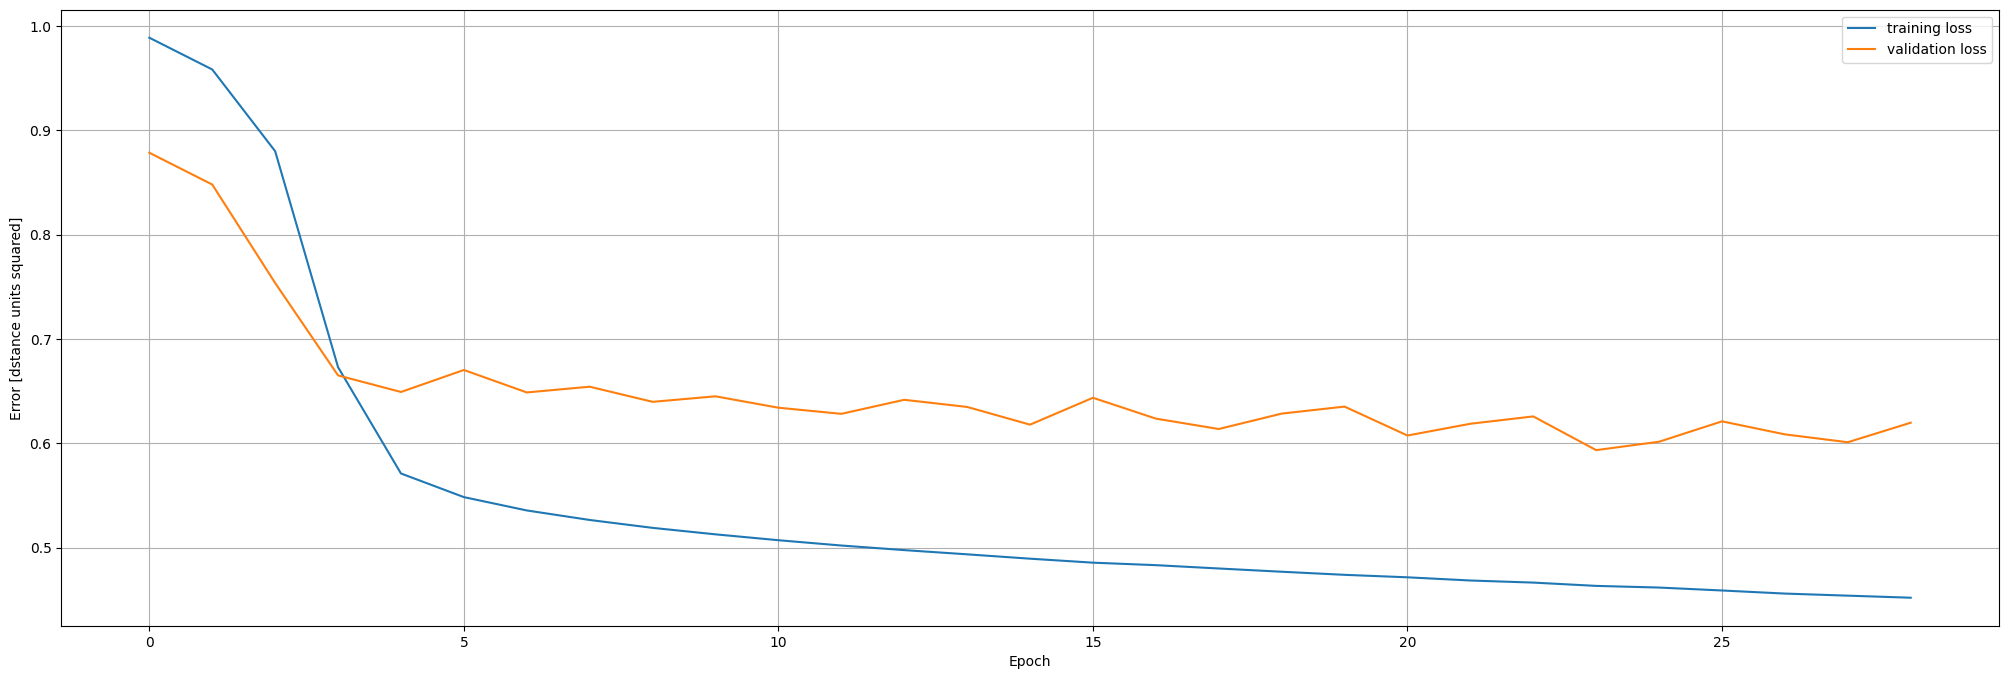

140/140 [==============================] - 1s 4ms/step


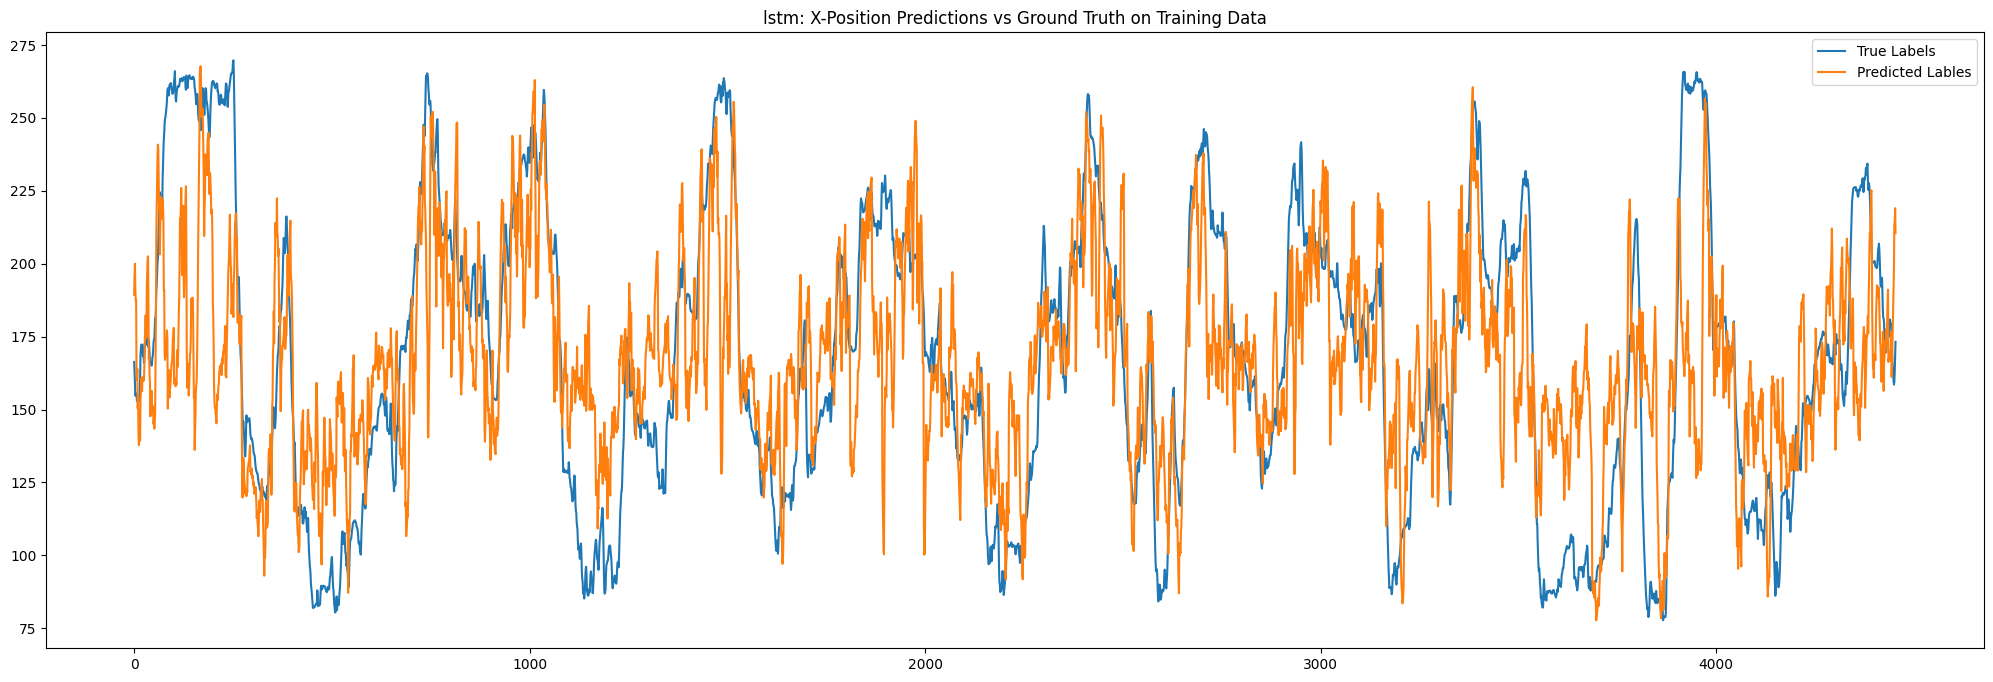

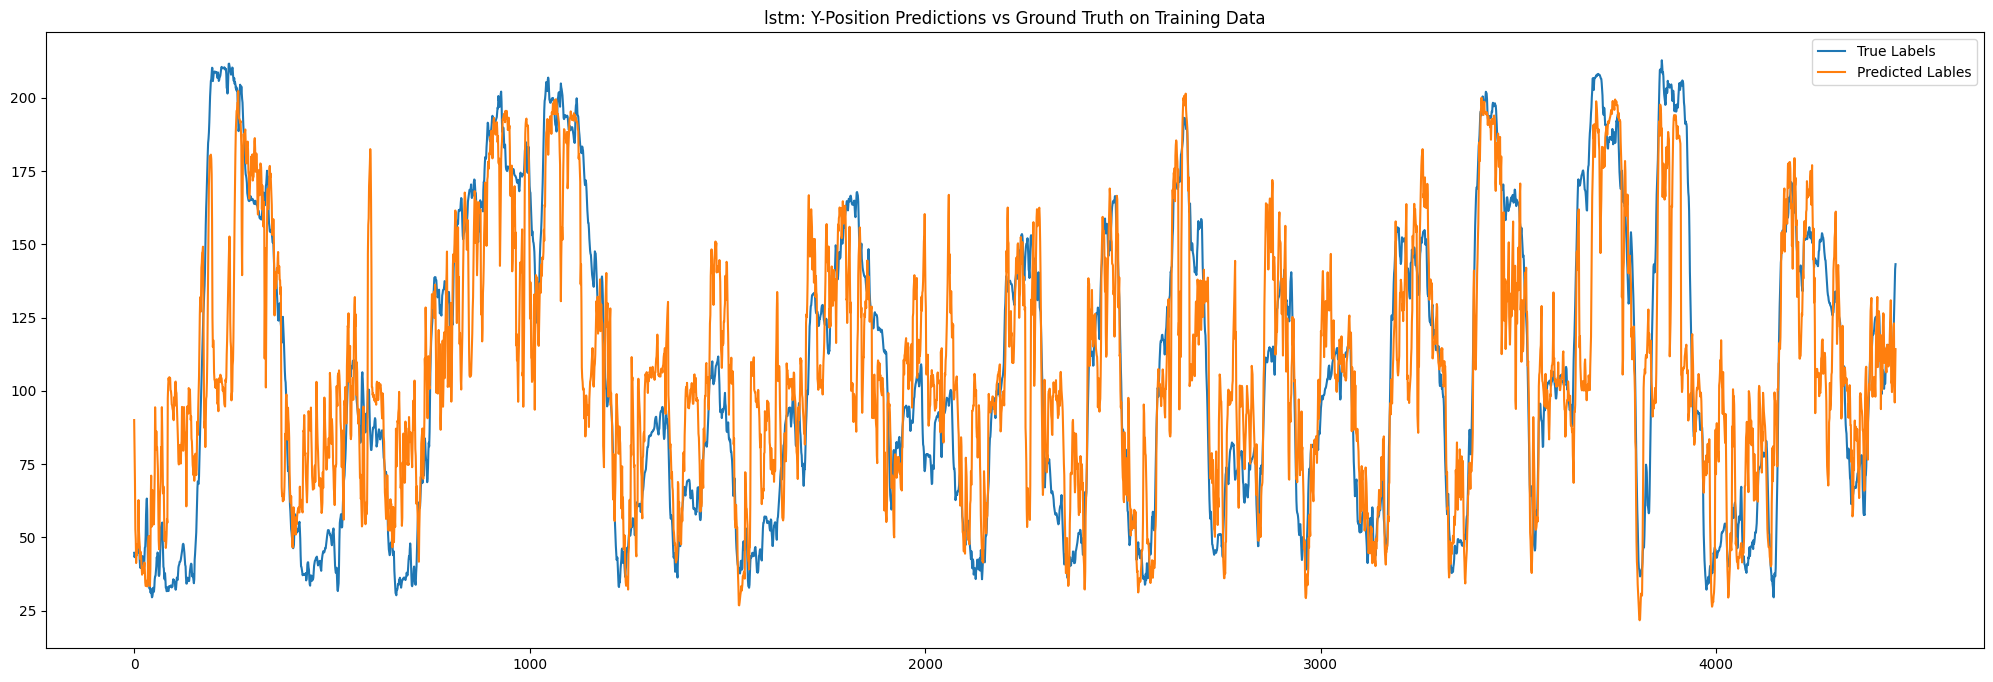

In [ ]:
def architect_lstm(hp):
    """
    kt.HyperParameters
    https://keras.io/api/keras_tuner/hyperparameters/#int-method

    tf.keras.layers.LSTM
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
    """
    hp_units_lstm0 = hp.Int('hp_units_lstm0', min_value=32, max_value=96, step=32)
    # hp_l1_alpha = hp.Choice('hp_l1_alpha', values=[0.0, 1e-3, 1e-2, 1e-1, 1.0])
    # hp_l2_alpha = hp.Choice('hp_l2_alpha', values=[0.0, 1e-3, 1e-2, 1e-1, 1.0])

    lstm_model = tf.keras.models.Sequential([
        # the input to an inference call on lstm is a matrix with shape equal to
        # the last 2 axes of the training data
        tf.keras.Input(name='in', shape=X_train_tensor_nn.shape[1:]),
        # the input to this layer is the vector of 1 element of the sequence
        tf.keras.layers.LSTM(
            name='lstm0',
            units=hp_units_lstm0,
            activation='tanh',
            # kernel_regularizer=tf.keras.regularizers.L1L2(hp_l1_alpha, hp_l2_alpha),
            return_sequences=False
        ),
        # the labels that the lstm will predict
        tf.keras.layers.Dense(name='do', units=2)
    ])

    # a large learning rate (1e-1) was causing my training to terminate after 
    # only a few epochs
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8])

    # tf.keras.Model.compile()
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
    # tf.keras.losses.MeanSquaredError
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
    lstm_model.compile(
        loss=tf.keras.metrics.mean_squared_error,
        # tf.keras.optimizers.Adam
        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[neg_r2_score_tf, tf.keras.metrics.mean_squared_error]
    )

    return lstm_model

name = 'lstm'

meta_optimal_hp, meta_optimal_lstm = validate_nn(
    architect_lstm,
    X_train=X_train_tensor_nn,
    y_train=y_train_nn,
    X_val=X_val_tensor_nn,
    y_val=y_val_nn
)
print(f"The optimal hyperparameters for {name}:\n\t{meta_optimal_hp.values}\n")

meta_optimal_lstm.summary()

# tf.keras.callbacks.EarlyStopping
# stop training when a monitored metric has stopped improving.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # number of epochs with no improvement after which training will be stopped
    mode='min'
)

hist = meta_optimal_lstm.fit(
    X_train_tensor_nn,
    y_train_nn,
    batch_size=nn_hp["batch_size"],
    epochs=100,
    validation_data=(X_val_tensor_nn, y_val_nn),
    callbacks=[early_stopping]
)

plot_nn_loss_curve(hist)

# Model.evaluate()
# returns the loss value and metrics values for the model in test mode.
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
val_metrics = meta_optimal_lstm.evaluate(X_val_tensor_nn, y_val_nn)
# TODO: figure out why json won't allow you to serialize the model configuration
#   information dircetly. it may be related to this stackoverflow post:
#   https://stackoverflow.com/questions/53082708/typeerror-object-of-type-float32-is-not-json-serializable
#   "optimizer": f"{meta_optimal_mlp.optimizer.get_config()}", 
#   "architecture": f"{meta_optimal_mlp.get_config()}"
all_reg_val_info[name] = (
    -val_metrics[meta_optimal_lstm.metrics_names.index('neg_r2_score_tf')],
    meta_optimal_hp.values
)

# Model.predict()
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
y_pred = scaler.inverse_transform(meta_optimal_lstm.predict(X_train_tensor_nn))
plot_preds_vs_truth(y_train_nn_inv[:, 0], y_pred[:, 0], f"{name}: X-Position Predictions vs Ground Truth on Training Data")
plot_preds_vs_truth(y_train_nn_inv[:, 1], y_pred[:, 1], f"{name}: Y-Position Predictions vs Ground Truth on Training Data")

In [ ]:
print_nn_weights(meta_optimal_lstm)

[<keras.layers.rnn.lstm.LSTM object at 0x7f6cd81dfcd0>, <keras.layers.core.dense.Dense object at 0x7f6cd81dfb80>]
weight matrix (shape:(46, 128), size:5888):
[[ 0.03655303  0.07538559  0.19923311 ...  0.01483326  0.14268419
  -0.1844029 ]
 [-0.2831911   0.0096496   0.00258098 ... -0.07136065  0.12379607
  -0.04605821]
 [-0.15494652  0.2647812   0.03439214 ... -0.09598805 -0.01768538
  -0.23886311]
 ...
 [ 0.11410492  0.0018266   0.11907908 ... -0.00181322 -0.13707167
  -0.03079008]
 [-0.05453411  0.00661665  0.04923081 ...  0.07241055 -0.19925658
   0.09575672]
 [ 0.15697856  0.00707341 -0.04514886 ...  0.29256025 -0.06154621
   0.33717105]]
bias vector (shape:(32, 128), size:4096):
[[ 0.0687042   0.22380425  0.16751012 ... -0.02510259 -0.00449351
  -0.05321838]
 [ 0.03279334  0.06440281  0.1039691  ...  0.09854861 -0.11670253
   0.072602  ]
 [ 0.19161072  0.04240321  0.09299452 ... -0.03930552  0.20679003
   0.09051252]
 ...
 [-0.01698862 -0.30460048 -0.00556337 ...  0.02589843 -0.019

In [ ]:
print(json.dumps(all_reg_val_info, indent=4, sort_keys=False))
with open(all_reg_val_info_fn, "wb") as f:
    pickle.dump(all_reg_val_info, f, pickle.HIGHEST_PROTOCOL)
    print(f"The validation information of the models have been serialized to this location:\n\t{os.path.realpath(f.name)}\n")

{
    "lin": [
        0.3621243876577847,
        [
            {
                "fit_intercept": true
            },
            {
                "fit_intercept": true
            }
        ]
    ],
    "lasso": [
        0.3646705465478324,
        [
            {
                "alpha": 0.01
            },
            {
                "alpha": 0.01
            }
        ]
    ],
    "ridge": [
        0.36613562790411325,
        [
            {
                "alpha": 10.0
            },
            {
                "alpha": 5.0
            }
        ]
    ],
    "lin_svm": [
        0.3497022411630416,
        [
            {
                "C": 5.0,
                "epsilon": 10.0,
                "tol": 0.01
            },
            {
                "C": 10.0,
                "epsilon": 10.0,
                "tol": 0.01
            }
        ]
    ],
    "knn": [
        0.20562927862302932,
        [
            {
                "n_neighbors": 50,
                "w

#####Physics-Informed Neural Networks

PINNs overcome the low data availability of some biological and engineering systems that makes most state-of-the-art machine learning techniques lack robustness, rendering them ineffective in these scenarios.

###Neural Decoder ML Model Training

When moedling it is typically a good idea to have a baseline model; however, I have selceted my model metric to be the coefficient of determination. If I assume that my baseline model is the mean of the target labels, then I have a comparison between my baseline and my final model builtin to my metric. Specifically, if the metric is less than 1, then that means that my model performs worse than the baseline model (guessing the average of the target labels). Therefore, for now I will not create a baseline model and instead leverage the convenience of the R2 score.

####Baseline Model

The baseline model will simply be guessing the average label of the training set.

In [ ]:
restore_session = False
if restore_session:
    with open(all_reg_val_info_fn, "rb") as f:
        all_reg_val_info = pickle.load(f)
        print(json.dumps(all_reg_val_info, indent=4, sort_keys=False))

    with np.load(data_fn) as data:
        X_train_matrix=data["X_train_matrix"]
        X_train_tensor=data["X_train_tensor"]
        y_train=data["y_train"]
        X_test_matrix=data["X_test_matrix"]
        X_test_tensor=data["X_test_tensor"]
        y_test=data["y_test"]
        
        num_train_examples, _, _ = X_train_tensor.shape
        num_test_examples, _, _ = X_test_tensor.shape
        # num_examples: the number of complete data examples given the number of 
        #   pre_bins and post_bins the model will use for inference.
        num_examples = num_train_examples + num_test_examples

{
    "lin": [
        0.3621243876577847,
        [
            {
                "fit_intercept": true
            },
            {
                "fit_intercept": true
            }
        ]
    ],
    "lasso": [
        0.3646705465478324,
        [
            {
                "alpha": 0.01
            },
            {
                "alpha": 0.01
            }
        ]
    ],
    "ridge": [
        0.36613562790411325,
        [
            {
                "alpha": 10.0
            },
            {
                "alpha": 5.0
            }
        ]
    ],
    "lin_svm": [
        0.3497022411630416,
        [
            {
                "C": 5.0,
                "epsilon": 10.0,
                "tol": 0.01
            },
            {
                "C": 10.0,
                "epsilon": 10.0,
                "tol": 0.01
            }
        ]
    ],
    "knn": [
        0.20562927862302932,
        [
            {
                "n_neighbors": 50,
                "w

In [ ]:
np.mean(y_train, axis=0)

array([168.68113868,  94.96906995])

####Optimal Model

From the validation phase, this was surprsingly ridge regression.

In [ ]:
max_r2_reg = max(all_reg_val_info, key=lambda x: x[0])
print(f"The model type with best hyperparameters and performance on the validation dataset or through cross-validation is:\n\t{max_r2_reg}")

x_pos_reg_hp = all_reg_val_info[max_r2_reg][1][0]
y_pos_reg_hp = all_reg_val_info[max_r2_reg][1][1]
print(f"The best hyperparameters of the best performing model for the x-position regressor is:\n\t{x_pos_reg_hp}")
print(f"The best hyperparameters of the best performing model for the y-position regressor is:\n\t{y_pos_reg_hp}")
print("Now it is finally time to train on the full dataset!!! :D")

The model type with best hyperparameters and performance on the validation dataset or through cross-validation is:
	ridge
The best hyperparameters of the best performing model for the x-position regressor is:
	{'alpha': 10.0}
The best hyperparameters of the best performing model for the y-position regressor is:
	{'alpha': 5.0}
Now it is finally time to train on the full dataset!!! :D


In [ ]:
# sklearn.linear_model.Ridge
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
ridge_reg_x = linear_model.Ridge(**x_pos_reg_hp)
ridge_reg_y = linear_model.Ridge(**y_pos_reg_hp)

ridge_reg_x.fit(X_train_matrix, y_train[:, 0])
ridge_reg_y.fit(X_train_matrix, y_train[:, 1])

Ridge(alpha=5.0)

###Neural Decoder ML Model Evaluation

Select the best metric for evaluating the performance of the final model. I may also want to try evaluating peroformance based on infernece performanc metrics.

Also, try creating a [regression table](https://www.freecodecamp.org/news/https-medium-com-sharadvm-how-to-read-a-regression-table-661d391e9bd7-708e75efc560/) for your best performing regression models in order to compare your models based on even more metrics. Also check out [reading regression tables](http://svmiller.com/blog/2014/08/reading-a-regression-table-a-guide-for-students/) if I require additional resources.

Compute the statistical significance of your findings (?).

In [ ]:
y_pred_x_pos = ridge_reg_x.predict(X_test_matrix)
y_pred_y_pos = ridge_reg_y.predict(X_test_matrix)

eval_x_pos_reg = r2_score(y_test[:, 0], y_pred_x_pos)
eval_y_pos_reg = r2_score(y_test[:, 1], y_pred_y_pos)

print(f"The final R2 score for the x-position regressor:\n\t{eval_x_pos_reg}")
print(f"The final R2 score for the y-position regressor:\n\t{eval_y_pos_reg}")

The final R2 score for the x-position regressor:
	-0.06466509595202852
The final R2 score for the y-position regressor:
	0.0021764324125010948


The $R^2$ scores for this regression problem are pretty abyssmal. Using the average of the test labels would have been a better predictor than ridge regression. The y-position regressor is only marginally better than guessing the mean.

This shows that the target function that I am trying to approximate is very challengiing to approximate its general form. The orginal performance of ridge regression was much higher than this. This must also mean that the training set is not well represented by the test set.

###Neural Decoder MLOps

Attempt to deploy this model to an ARM target hardware that would be used with Neuralink's Link. Also, make some kind of streaming program that doesn't pre-compute predictions, but makes inferences in real-time on incoming data. Do the actual engineering work and create some kind of test production environment. The data that I can use fro streaming can be my test dataset.

Also, use this opportunity to try out some online ML techniques since it may be expected for teh input distribution or even the function that we are trying to estimate to change. Investigate Online Learning methods for more information.

###Bibliography

1. [Machine Learning for Neural Decoding](https://www.eneuro.org/content/7/4/ENEURO.0506-19.2020) Joshua I. Glaser, Ari S. Benjamin, Raeed H. Chowdhury, Matthew G. Perich, Lee E. Miller, Konrad P. Kording
eNeuro 31 July 2020, 7 (4) ENEURO.0506-19.2020; DOI: 10.1523/ENEURO.0506-19.2020

1. Mizuseki K, Sirota A, Pastalkova E, Buzsáki G. (2009): [Multi-unit recordings from the rat hippocampus made during open field foraging.](http://dx.doi.org/10.6080/K0Z60KZ9)

2. Yang S-H, Wang H-L, Lo Y-C, Lai H-Y, Chen K-Y, Lan Y-H, Kao C-C, Chou C, Lin S-H, Huang J-W, Wang C-F, Kuo C-H and Chen Y-Y (2020) [Inhibition of Long-Term Variability in Decoding Forelimb Trajectory Using Evolutionary Neural Networks With Error-Correction Learning](https://www.frontiersin.org/articles/10.3389/fncom.2020.00022/full). Front. Comput. Neurosci. 14:22. doi: 10.3389/fncom.2020.00022